<a href="https://colab.research.google.com/github/Haythem-Jaidane/BASIRA-Lab_Internship/blob/main/Federated_learning_with_domain_shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# I - Install the needed libraries

### MedMNIST : is large dataset collection of medical images. we have a library that enable us to work with.    

In [3]:
pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached certifi-2022.12.7-py3-none-any.whl (155 kB)
  Using cached charset_normalizer-2.1.1-py3-none-any.whl (39 kB)
  Using cached contourpy-1.1.0-cp311-cp311-win_amd64.whl (470 kB)
  Using cached fonttools-4.42.0-cp311-cp311-win_amd64.whl (2.1 MB)
  Using cached imageio-2.31.1-py3-none-any.whl (313 kB)
  Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)
  Using cached importlib_resources-6.0.0-py3-none-any.whl (31 kB)
  Using cached joblib-1.3.1-py3-none-any.whl (301 kB)
  Using cached lazy_loader-0.3-py3-none-any.whl (9.1 kB)
  Using cached MarkupSafe-2.1.2-cp311-cp311-win_amd64.whl (16 kB)
  Using cached matplotlib-3.7.2-cp311-cp311-win_amd64.whl (7.5 MB)
  Using cached networkx-3.0-py3-none-any.whl (2.0 MB)
  Using cached numpy-1.24.1-cp311-cp311-win_amd64.whl (14.8 MB)
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
  Using cached pandas-2.0.3-cp311-cp311-win_amd64.whl (10.6 M

ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11
ERROR: Could not find a version that satisfies the requirement torch==2.0.1+cu118 (from versions: 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==2.0.1+cu118


# II - Import the ibraries we need in this notebbok

In [190]:
import numpy as np

import pandas as pd

from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt

import copy

import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.transforms import ToTensor
import torch.nn.functional as F

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn import metrics

from medmnist.dataset import DermaMNIST,BloodMNIST
from medmnist import INFO

In [191]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# III - data loadding and investigation

## 1 - dataset loadding

In [274]:
class DataPreprocessing():
    
    def __init__(self,MedMNIST_object):
        
        self.train_object = MedMNIST_object(root='../data/raw/', transform=transforms.ToTensor(), download=True, split='train')
        self.test_object = MedMNIST_object(root='../data/raw/', transform=transforms.ToTensor(), download=True, split='test')
        
        train_label = []
        test_label = []
        
        for label in self.train_object.labels:
            train_label.append(label[0])
            
        for label in self.test_object.labels:
            test_label.append(label[0])
            
        self.dataset_name = MedMNIST_object.flag
        self.classes_name = INFO[self.dataset_name]["label"]
        self.num_classes = len(self.classes_name)
        self.dataset = {
            "original":{
                "train":{
                    "image": self.train_object.imgs,
                    "labels" : train_label,
                    "labels_distribution" : [0] * self.num_classes
                },
                "test":{  
                    "image": self.test_object.imgs , 
                    "labels" : test_label , 
                    "labels_distribution" : [0] * self.num_classes
                }
            }
        }
        self.calculateLabelsDistribution("original")
        
        
    def __str__(self):
        return f"==============================\n" \
               f"Train Dataset description\n" \
               f"==============================\n" \
               f"{self.train_object}\n" \
               f"==============================\n" \
               f"Test Dataset description\n" \
               f"==============================\n" \
               f"{self.test_object}\n"
    
    def __len__(self):
        return len(self.dataset)
    
    def viewDataset(self):
        fig,ax = plt.subplots(1,2,figsize=(10,10))
        ax[0].imshow(self.train_object.montage(length=20))
        ax[1].imshow(self.test_object.montage(length=20))
        
        ax[0].set_title("train dataset")
        ax[1].set_title("test dataset")
        
        ax[0].axis('off')
        ax[1].axis('off')
        plt.show()
        
    def viewNSimple(self,n,height,width,dataset_type):
        
        if height*width<n:
            raise Exception("the figure size is too small for showing your simples")
            
        fig,ax = plt.subplots(height,width,figsize=(25,25))

        index_simple=0

        for i in range(height):
            for j in range(width):

                image = self.dataset[dataset_type]["train"]["image"][index_simple,:,:,:]
                
                class_name = self.classes_name[str(self.dataset[dataset_type]["train"]["labels"][index_simple])]

                ax[i,j].imshow(image)
                ax[i,j].axis('off')
                ax[i,j].set_title(class_name)

                index_simple+=1

        fig.suptitle(str(n)+" simples of the train dataset")
        plt.show()
        
    def calculateLabelsDistribution(self,dataset_type):
        
        self.dataset[dataset_type]["train"]["labels_distribution"] = [0] * self.num_classes
        self.dataset[dataset_type]["test"]["labels_distribution"]  = [0] * self.num_classes
        
        for label in self.dataset[dataset_type]["train"]["labels"]:
            self.dataset[dataset_type]["train"]["labels_distribution"][label]+=1
            
        for label in self.dataset[dataset_type]["test"]["labels"]:
            self.dataset[dataset_type]["test"]["labels_distribution"][label]+=1
    
    def plotLabelsDistribution(self,dataset_type):
        
        self.calculateLabelsDistribution(dataset_type)
        
        classes_list = list(self.classes_name.values())


        train_distribution = pd.DataFrame({'class':classes_list,'simples number':self.dataset[dataset_type]["train"]["labels_distribution"]})
        train_distribution.set_index('class', inplace=True)


        test_distribution = pd.DataFrame({'class':classes_list,'simples number':self.dataset[dataset_type]["test"]["labels_distribution"]})
        test_distribution.set_index('class', inplace=True)

        fig,ax = plt.subplots(1,2,figsize=(10,10),sharey=True)

        train_distribution.plot.bar(ax=ax[0])
        test_distribution.plot.bar(ax=ax[1])

        fig.suptitle("distribution of the dataset")
        plt.show()
        
    def cleanImblanceData(self,from_data,new_dataset_type):
        
        self.dataset[new_dataset_type] = copy.deepcopy(self.dataset[from_data])
        
        X_train = self.dataset[new_dataset_type]["train"]["image"].reshape(self.dataset[new_dataset_type]["train"]["image"].shape[0], -1)
        X_test = self.dataset[new_dataset_type]["test"]["image"].reshape(self.dataset[new_dataset_type]["test"]["image"].shape[0], -1)

        oversampler_train = RandomOverSampler()
        X_train,self.dataset[new_dataset_type]["train"]["labels"] = oversampler_train.fit_resample(X_train, self.dataset["original"]["train"]["labels"])

        oversampler_test = RandomOverSampler()
        X_test,self.dataset[new_dataset_type]["test"]["labels"] = oversampler_test.fit_resample(X_test,self.dataset["original"]["test"]["labels"])
        
        self.dataset[new_dataset_type]["train"]["image"] = X_train.reshape(X_train.shape[0],28,28,3)
        self.dataset[new_dataset_type]["test"]["image"] = X_test.reshape(X_test.shape[0],28,28,3)
        
    def plotColorDistribution(self,dataset_type):
        image_reshaped_train = self.dataset[dataset_type]["train"]["image"].reshape(-1, 3)
        image_reshaped_test = self.dataset[dataset_type]["test"]["image"].reshape(-1, 3)

        fig, axes = plt.subplots(1, 3, figsize=(12, 4),sharey=True)
        fig.suptitle('Color Distribution')
        
        colors = ["Red","Green","Blue"]
        
        for i in range(3):
            axes[i].hist(image_reshaped_train[:, i], bins=256,label="train")
            axes[i].hist(image_reshaped_test[:, i], bins=256,label="test")
            axes[i].legend(loc="upper left")
            axes[i].set_title(colors[i])
            axes[i].set_xlabel('Color Intensity')
            axes[i].set_ylabel('Frequency')


        plt.tight_layout()
    
    def makeDomainshift(self,from_dataset,filter_kernal):
        
        self.dataset["shift"] = copy.deepcopy(self.dataset[from_dataset])

        self.dataset["shift"]["train"]["image"][:,:, :, 0] = self.dataset["shift"]["train"]["image"][:,:, :, 0] * filter_kernal[0]
        self.dataset["shift"]["train"]["image"][:,:, :, 1] = self.dataset["shift"]["train"]["image"][:,:, :, 1] * filter_kernal[1]
        self.dataset["shift"]["train"]["image"][:,:, :, 2] = self.dataset["shift"]["train"]["image"][:,:, :, 2] * filter_kernal[2]
        
        

In [275]:
dermaDataPreprocessing = DataPreprocessing(DermaMNIST)
bloodDataPreprocessing = DataPreprocessing(BloodMNIST)

Using downloaded and verified file: ../data/raw/dermamnist.npz
Using downloaded and verified file: ../data/raw/dermamnist.npz
Using downloaded and verified file: ../data/raw/bloodmnist.npz
Using downloaded and verified file: ../data/raw/bloodmnist.npz


In [276]:
print(dermaDataPreprocessing)

Train Dataset description
Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: ../data/raw/
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY 4.0
Test Dataset description
Dataset DermaMNIST (dermamnist)
    Nu

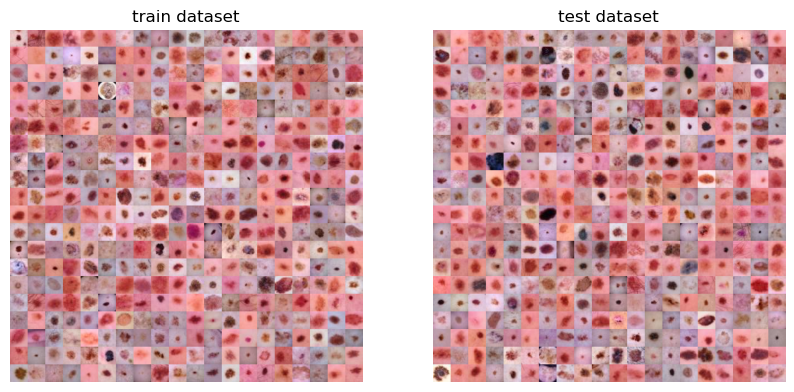

In [277]:
dermaDataPreprocessing.viewDataset()

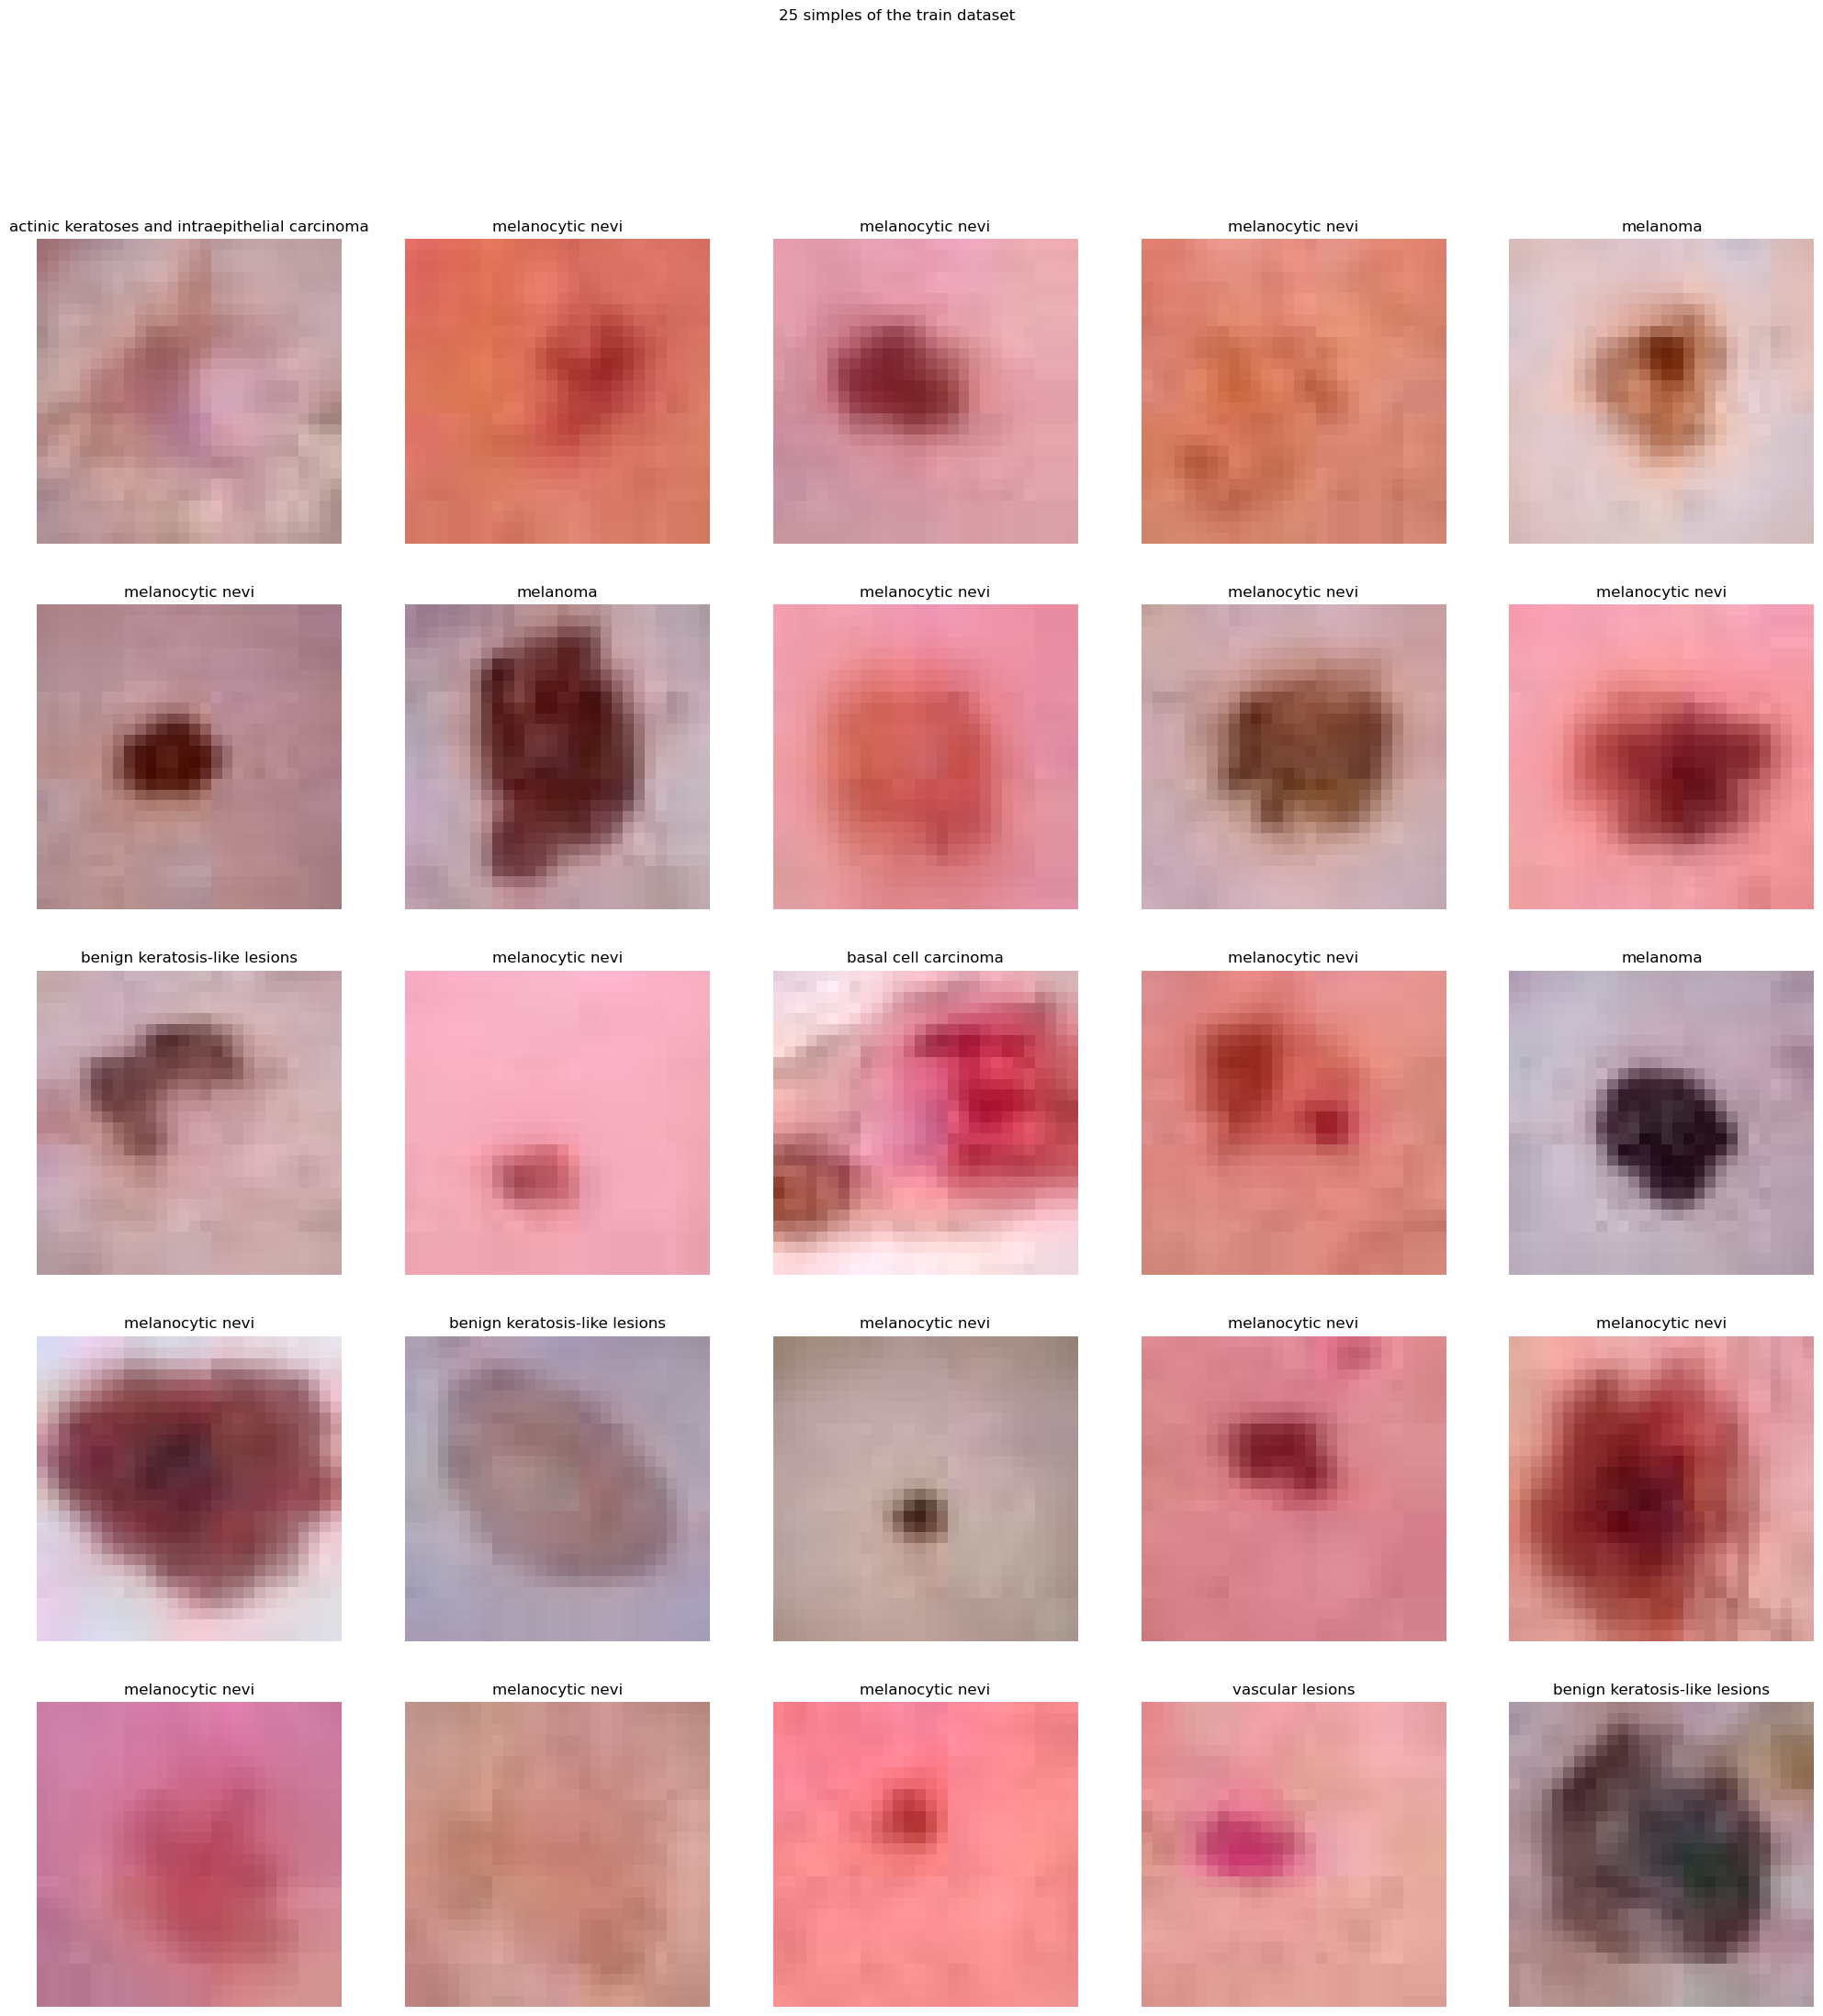

In [278]:
dermaDataPreprocessing.viewNSimple(25,5,5,"original")

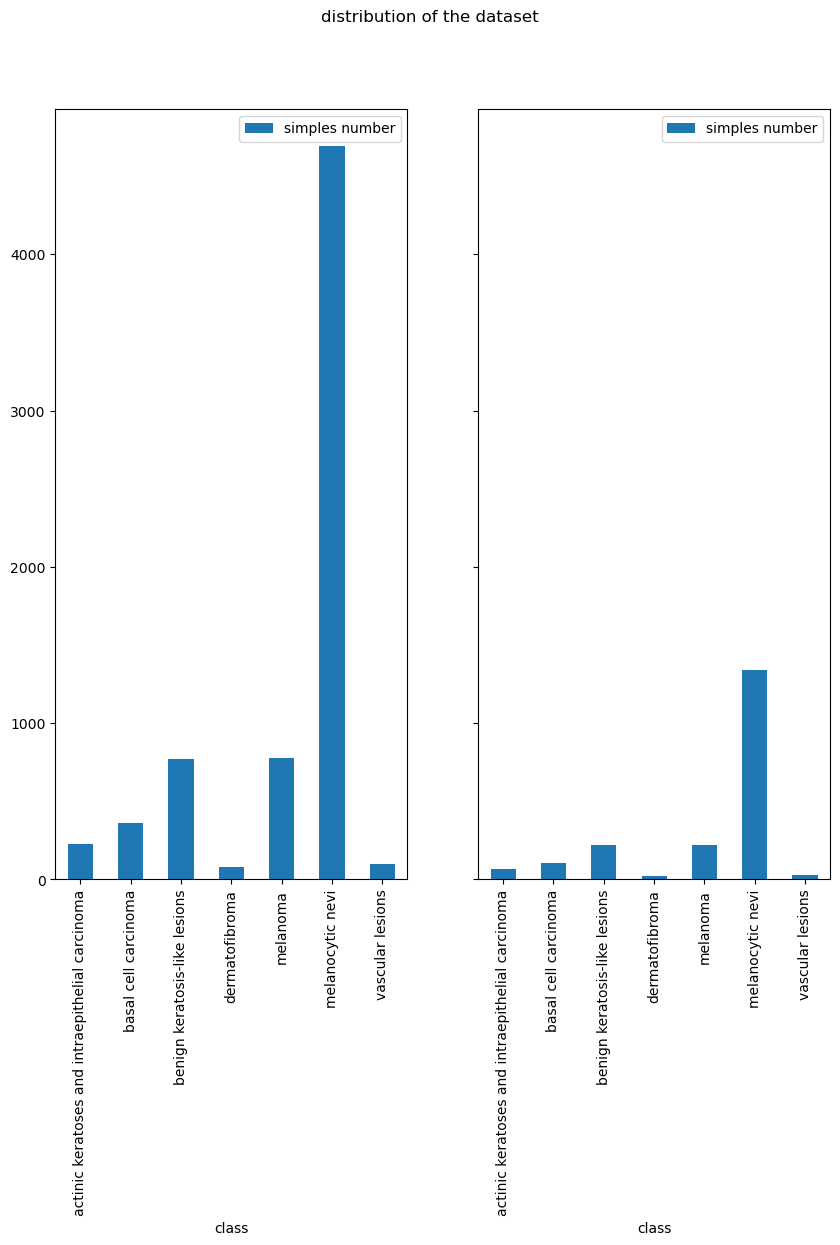

In [279]:
dermaDataPreprocessing.plotLabelsDistribution("original")

In [280]:
dermaDataPreprocessing.cleanImblanceData("original","clean")

In [281]:
len(dermaDataPreprocessing)

2

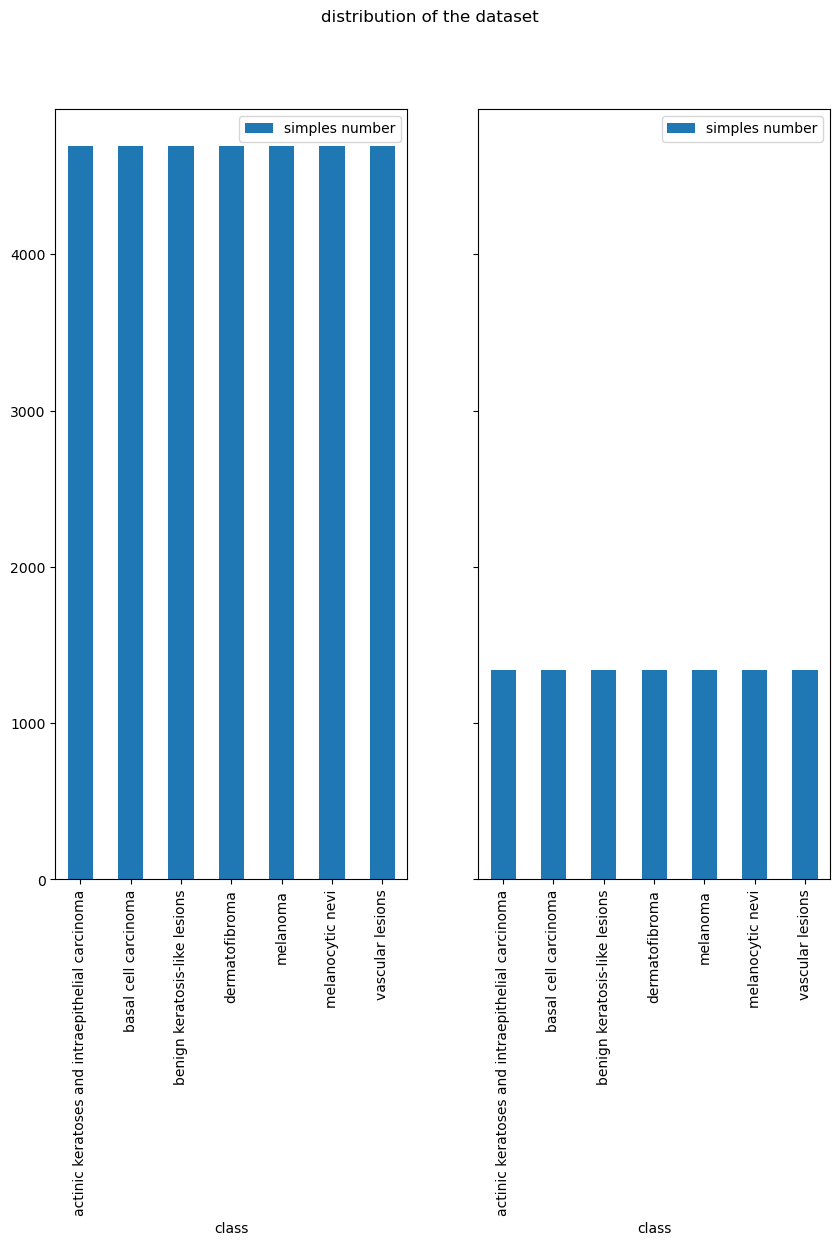

In [282]:
dermaDataPreprocessing.plotLabelsDistribution("clean")

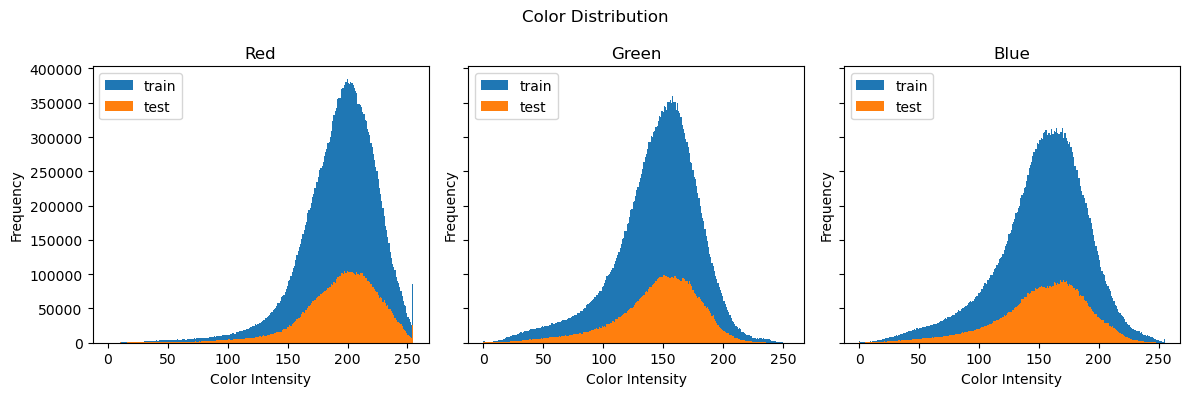

In [283]:
dermaDataPreprocessing.plotColorDistribution('clean')

In [284]:
dermaDataPreprocessing.makeDomainshift("clean",[0.5,0.5,0.5])

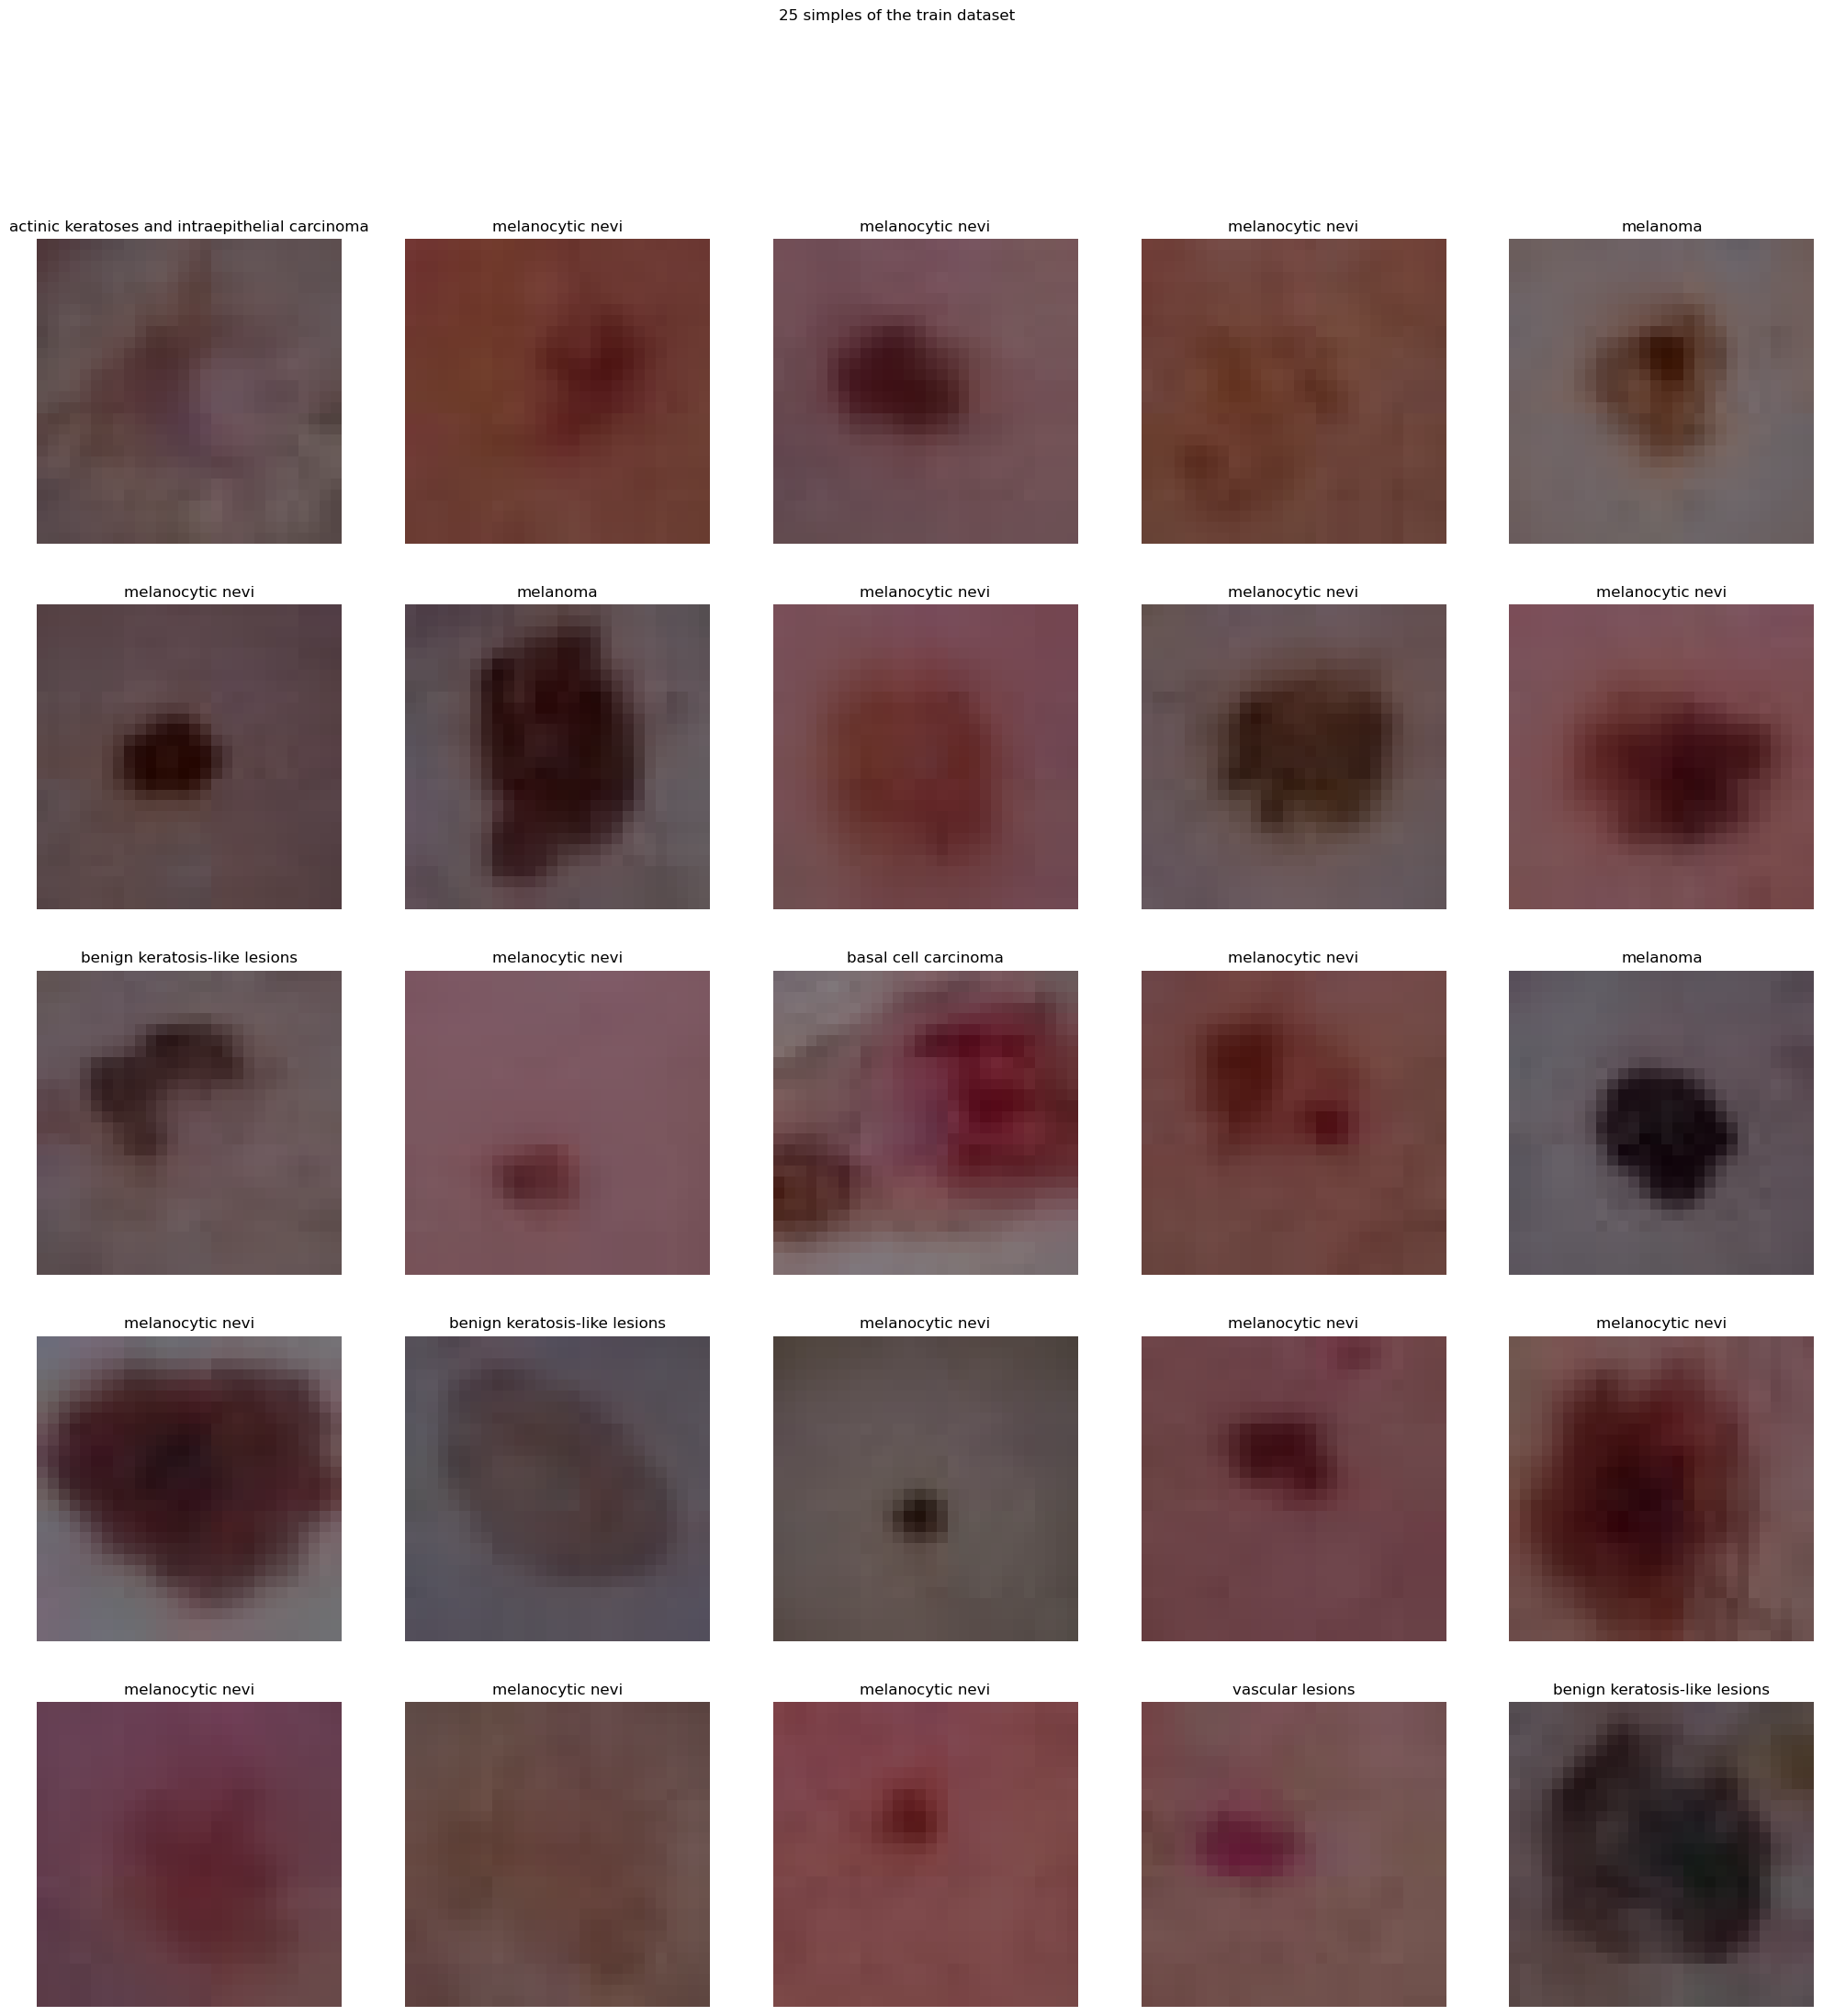

In [285]:
dermaDataPreprocessing.viewNSimple(25,5,5,"shift")

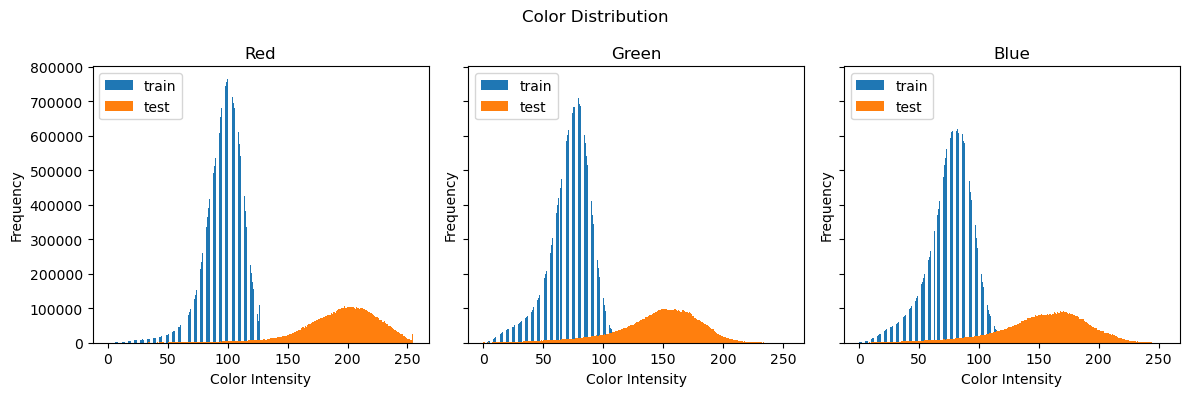

In [286]:
dermaDataPreprocessing.plotColorDistribution('shift')

# IV - Model definition

In [17]:
class CNN(nn.Module):

    def __init__(self,num_class):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_class))


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [18]:
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.resnet = torchvision.models.resnet18()
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [19]:
class ResNet18_pretrainied(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

Epoch [1/100], D Loss: 2.2700, G Loss: 0.1474
Epoch [2/100], D Loss: 0.9709, G Loss: 0.5024
Epoch [3/100], D Loss: 0.5151, G Loss: 0.9309
Epoch [4/100], D Loss: 0.6292, G Loss: 0.7555
Epoch [5/100], D Loss: 0.3830, G Loss: 1.1110
Epoch [6/100], D Loss: 0.3269, G Loss: 1.1412
Epoch [7/100], D Loss: 0.2618, G Loss: 1.2745
Epoch [8/100], D Loss: 0.5394, G Loss: 0.8927
Epoch [9/100], D Loss: 0.5665, G Loss: 0.8123
Epoch [10/100], D Loss: 0.4917, G Loss: 1.1540
Epoch [11/100], D Loss: 8.9146, G Loss: 0.0003
Epoch [12/100], D Loss: 4.0247, G Loss: 0.0247
Epoch [13/100], D Loss: 0.9680, G Loss: 0.5063
Epoch [14/100], D Loss: 0.6054, G Loss: 0.8212
Epoch [15/100], D Loss: 0.4397, G Loss: 1.1363
Epoch [16/100], D Loss: 0.2528, G Loss: 1.5967
Epoch [17/100], D Loss: 0.2426, G Loss: 1.6126
Epoch [18/100], D Loss: 0.2343, G Loss: 1.5738
Epoch [19/100], D Loss: 0.1583, G Loss: 2.0147
Epoch [20/100], D Loss: 0.3579, G Loss: 1.2123
Epoch [21/100], D Loss: 0.2808, G Loss: 1.3865
Epoch [22/100], D Loss

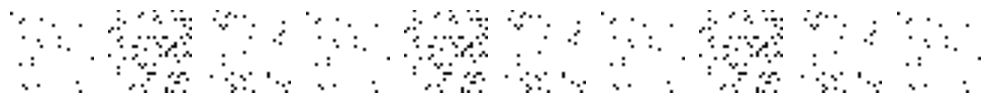

In [295]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()  # Output image values between -1 and 1
        )

    def forward(self, x):
        return self.model(x)

# Discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output a probability
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_dim = 2352  # Size of random noise vector
output_dim = 2352  # Size of generated image (28x28)
lr = 0.0002
batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the generator and discriminator
generator = Generator(input_dim, output_dim).to(device)
discriminator = Discriminator(output_dim).to(device)

# Loss and optimizers
criterion = nn.BCELoss()  # Binary Cross Entropy loss
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

train_dataset = data.TensorDataset(torch.tensor(dermaDataPreprocessing.dataset["original"]["train"]["image"]).float(), torch.tensor(dermaDataPreprocessing.dataset["original"]["train"]["labels"]).long())
data_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Training loop
num_epochs = 100
sample_noise = torch.randn(10, input_dim).to(device)

for epoch in range(num_epochs):
    for batch_idx in range(len(data_loader)):
        # Train discriminator
        real_data,_ = next(iter(data_loader))
        real_data = real_data.view(-1, output_dim).to(device)
        fake_data = generator(real_data.to(device))

        optimizer_d.zero_grad()

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        real_output = discriminator(real_data)
        fake_output = discriminator(fake_data.detach())  # Detach generator gradient

        loss_real = criterion(real_output, real_labels)
        loss_fake = criterion(fake_output, fake_labels)

        d_loss = loss_real + loss_fake
        d_loss.backward()
        optimizer_d.step()

        # Train generator
        optimizer_g.zero_grad()
        fake_data = generator(torch.randn(batch_size, input_dim).to(device))
        fake_output = discriminator(fake_data)

        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_g.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
    

# Generate samples
num_samples = 10
sample_noise = torch.randn(num_samples, input_dim).to(device)
generated_samples = generator(real_data)

if (epoch + 1) % 10 == 0:
    generated_samples = generator(real_data).cpu().detach()
    generated_samples = generated_samples.view(-1, 28, 28).numpy()

    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(generated_samples[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# V - training Models

## 1 - object definition

In [28]:
class fitting():
    def __init__(self, num_fold=4, training_type=0, num_class=7, ModelType=CNN, img_train=X_train_oversampled, labels_train=y_train_oversampled,img_test=X_test_oversampled, labels_test=y_test_oversampled, optimizer=optim.SGD):
        self.KFold = StratifiedKFold(n_splits=num_fold, shuffle=True)
        self.num_class = num_class
        self.model = ModelType
        self.img_train = img_train.reshape(img_train.shape[0], 28, 28, 3)
        self.labels_train = labels_train
        self.img_test = img_test.reshape(img_test.shape[0], 28, 28, 3)
        self.labels_test = labels_test
        self.Optimizer = optimizer
        self.num_client = num_fold

    def train(self, epoch_num, batch_size, lr):
        models_list = []
        acc = []
        loss_train = []
        loss_validation = []
        test_results = [[],[],[]]
        for fold, (train_index, val_index) in enumerate(self.KFold.split(self.img_train, self.labels_train)):
            print(f"Fold {fold+1}:")
            loss_train_f = []
            loss_validation_f = []

            X_train, X_val = self.img_train[train_index], self.img_train[val_index]
            y_train, y_val = self.labels_train[train_index], self.labels_train[val_index]

            model = self.model(self.num_class)

            criterion = nn.CrossEntropyLoss()
            optimizer = self.Optimizer(model.parameters(), lr=lr, weight_decay=0.0001)

            train_dataset = data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
            val_dataset = data.TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())

            train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = data.DataLoader(val_dataset)

            for epoch in range(epoch_num):
                model.train()
                train_loss = 0.0
                for batch, (X_, y_) in enumerate(train_loader):
                    optimizer.zero_grad()
                    outputs = model(X_.permute(0, 3, 1, 2))  # Transpose the channels to match the model's input shape
                    loss = criterion(outputs, y_)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                avg_train_loss = train_loss / len(train_loader)

                model.eval()
                with torch.no_grad():
                    val_loss = 0.0
                    correct = 0
                    total = 0
                    for val_batch_X, val_batch_y in val_loader:
                        val_batch_X = val_batch_X.permute(0, 3, 1, 2)  # Transpose the channels
                        val_outputs = model(val_batch_X)
                        _, predicted = torch.max(val_outputs.data, 1)
                        total += val_batch_y.size(0)
                        correct += (predicted == val_batch_y).sum().item()
                        val_loss += criterion(val_outputs, val_batch_y).item()

                    val_accuracy = 100 * correct / total
                    avg_val_loss = val_loss / len(val_loader)

                # Print metrics for each epoch
                print(f"Epoch {epoch+1}:")
                print(f"Train Loss: {avg_train_loss:.4f}")
                print(f"Validation Loss: {avg_val_loss:.4f}")
                print(f"Validation Accuracy: {val_accuracy:.2f}%")

                acc_list,sens_list,spec_list = self.test([model])
                print(f"Test Accuracy: {acc_list[0]:.2f}%")
                print()

                loss_train_f.append(avg_train_loss)
                loss_validation_f.append(avg_val_loss)
                test_results[fold].append(acc_list)

            loss_train.append(loss_train_f)
            loss_validation.append(loss_validation_f)

            models_list.append(model)
            acc.append(val_accuracy)

        return models_list, acc, loss_train, loss_validation,test_results

    def train_federated(self,lr,epoch_num,periode_num,algo):


        server_model = self.model(self.num_class)
        models_list_federated = [copy.deepcopy(server_model) for _ in range(self.num_client)]
        models_list_non_federated = [copy.deepcopy(server_model) for _ in range(self.num_client)]
        acc = [[],[],[],[],[],[],[],[],[]]
        loss_train = [[],[],[],[],[],[],[],[],[]]
        loss_test = [[],[],[],[],[],[],[],[],[]]

        optimizers_federated = [self.Optimizer(models_list_federated[i].parameters(), lr=lr,weight_decay=0.0001) for i in range(self.num_client)]
        optimizers_non_federated = [self.Optimizer(models_list_non_federated[i].parameters(), lr=lr,weight_decay=0.0001) for i in range(self.num_client)]

        test_results =[]

        fold_data = []

        for train_index, val_index in self.KFold.split(self.img_train, self.labels_train):
            X_train, X_val = self.img_train[train_index], self.img_train[val_index]
            y_train, y_val = self.labels_train[train_index], self.labels_train[val_index]

            train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train).float().clone().detach(), torch.tensor(y_train).long().clone().detach())
            val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val).float().clone().detach(), torch.tensor(y_val).long().clone().detach())

            fold_data.append({'train': train_dataset, 'val': val_dataset})

        for periode in range(periode_num):
            print(f"round {periode+1} : ")
            for fold in range(len(fold_data)):


                print(f"Client {fold+1} : ")
                model = models_list_federated[fold]
                model_alone = models_list_non_federated[fold]

                criterion = nn.CrossEntropyLoss()
                optimizer = optimizers_federated[fold]
                criterion1 = nn.CrossEntropyLoss()
                optimizer1 = optimizers_non_federated[fold]
                train_loader = data.DataLoader(fold_data[fold]['train'], batch_size=128, shuffle=True)
                val_loader = data.DataLoader(fold_data[fold]['val'])

                for epoch in range(epoch_num):

                    model.train()
                    model_alone.train()


                    for batch, (X_, y_) in enumerate(train_loader):
                        X_ = X_.view(-1, 3, 28, 28)
                        y_ = y_.squeeze().long()

                        optimizer.zero_grad()
                        optimizer1.zero_grad()


                        outputs = model(X_)
                        outputs1 = model_alone(X_)


                        loss = criterion(outputs, y_)
                        loss1 = criterion1(outputs1, y_)


                        loss.backward()
                        loss1.backward()


                        optimizer.step()
                        optimizer1.step()

                    model.eval()
                    model_alone.eval()
                    with torch.no_grad():
                        val_loss = 0.0
                        correct = 0
                        total = 0
                        val_loss1 = 0.0
                        correct1 = 0
                        for val_batch_X, val_batch_y in val_loader:
                            val_batch_X = val_batch_X.view(-1, 3, 28, 28)
                            val_outputs = model(val_batch_X)
                            val_outputs1 = model_alone(val_batch_X)
                            _, predicted = torch.max(val_outputs.data, 1)
                            _, predicted1 = torch.max(val_outputs1.data, 1)
                            total += val_batch_y.size(0)
                            correct += (predicted == val_batch_y).sum().item()
                            correct1 += (predicted1 == val_batch_y).sum().item()
                            val_loss += criterion(val_outputs, val_batch_y).item()
                            val_loss1 += criterion1(val_outputs1, val_batch_y).item()

            # Calculate accuracy and average loss for validation
                        val_accuracy = 100 * correct / total
                        avg_val_loss = val_loss / len(val_loader)

                        val_accuracy1 = 100 * correct1 / total
                        avg_val_loss1 = val_loss1 / len(val_loader)

                    acc[fold].append(val_accuracy)
                    loss_train[fold].append(loss.item())
                    loss_test[fold].append(val_accuracy)

                    acc[fold+self.num_client].append(val_accuracy1)
                    loss_train[fold+self.num_client].append(loss1.item())
                    loss_test[fold+self.num_client].append(val_accuracy1)

                    models_list_federated[fold] = model
                    models_list_non_federated[fold] = model_alone

                    optimizers_federated[fold] = optimizer
                    optimizers_non_federated[fold] = optimizer1

        # Print metrics for each epoch
                    print(f"Epoch {epoch+1}:")
                    print(f"Train Loss: {loss.item():.4f}")
                    print(f"Validation Loss: {avg_val_loss:.4f}")
                    print(f"Validation Accuracy: {val_accuracy:.2f}%")
                    print("------------------------------------")
                    print(f"Train Loss (alone): {loss1.item():.4f}")
                    print(f"Validation Loss (alone): {avg_val_loss1:.4f}")
                    print(f"Validation Accuracy (alone): {val_accuracy1:.2f}%")
                    print()
                    t = self.test(models_list_federated)
                    t1 = self.test([server_model])
                    t2 = self.test(models_list_non_federated)
                    test_results.append(t)
                    print("server acc : ",t1[0])
                    print()
                    print("Hospital 1 : federated : ",t[0][0]," non federated : ",t2[0][0])
                    print("Hospital 2 : federated : ",t[0][1]," non federated : ",t2[0][1])

                    print()


          #acc.append(val_accuracy)

            if algo=="FedAVG":
                for key in server_model.state_dict().keys():
                    if 'num_batches_tracked' in key:
                        server_model.state_dict()[key].data.copy_(models_list_federated[1].state_dict()[key])
                    else:
                        temp = torch.zeros_like(server_model.state_dict()[key])
                        for client_idx in range(self.num_client):
                            temp += (1/self.num_client) * models_list_federated[client_idx].state_dict()[key]
                        server_model.state_dict()[key].data.copy_(temp)
                        for client_idx in range(self.num_client):
                            models_list_federated[client_idx].state_dict()[key].data.copy_(server_model.state_dict()[key])
            elif algo=="FedALA":
                pass
            elif algo=="FedBN":
                pass




        return models_list_federated,models_list_non_federated,acc,loss_train,loss_test,test_results

    def test(self,model_list):

        test_loader = data.DataLoader(data.TensorDataset(torch.tensor(self.img_test).float(), torch.tensor(self.labels_test).long()))

        acc_list = []
        spec_list = []
        sens_list = []

        for m in model_list:
            correct , total = 0,0
            prediction = []

            true_negatives = [0] * 7
            total_negatives = [0] * 7
            class_correct = [0] * 7
            class_total = [0] * 7

            m.eval()

            spec = [0] * 7
            sens = [0] * 7

            predicted_list = []

            for img, labels in test_loader:

                img = img.permute(0, 3, 1, 2)

                output = m(img)
                _, predicted = torch.max(output.data, 1)

                predicted_list.append(predicted.long().detach().numpy())

            predicted_list = np.array(predicted_list).reshape(len(predicted_list))
            target = torch.tensor(self.labels_test).long().detach().numpy()


            accuracy = metrics.accuracy_score(target, predicted_list)
            precision = metrics.precision_score(target, predicted_list, average='weighted')
            recall = metrics.recall_score(target, predicted_list, average='weighted')
            f1_score = metrics.f1_score(target, predicted_list, average='weighted')

            spec_list.append(precision*100)
            acc_list.append(accuracy*100)
            sens_list.append(recall*100)

        return acc_list,sens_list,spec_list



In [92]:
class evaluation:
    
    def __init__(self,img_test,labels_test):
        self.img_test = img_test
        self.labels_test = labels_test
        
        
    def test(self,model_list):

        test_loader = data.DataLoader(data.TensorDataset(torch.tensor(self.img_test).float(), torch.tensor(self.labels_test).long()))

        acc_list = []
        spec_list = []
        sens_list = []

        for m in model_list:
            correct , total = 0,0
            prediction = []

            true_negatives = [0] * 7
            total_negatives = [0] * 7
            class_correct = [0] * 7
            class_total = [0] * 7

            m.eval()

            spec = [0] * 7
            sens = [0] * 7

            predicted_list = []

            for img, labels in test_loader:

                img = img.permute(0, 3, 1, 2)

                output = m(img)
                _, predicted = torch.max(output.data, 1)

                predicted_list.append(predicted.long().detach().numpy())

            predicted_list = np.array(predicted_list).reshape(len(predicted_list))
            target = torch.tensor(self.labels_test).long().detach().numpy()


            accuracy = metrics.accuracy_score(target, predicted_list)
            precision = metrics.precision_score(target, predicted_list, average=None, zero_division=1)
            recall = metrics.recall_score(target, predicted_list, average=None)
            f1_score = metrics.f1_score(target, predicted_list, average=None)

            spec_list.append(precision*100)
            acc_list.append(accuracy*100)
            sens_list.append(recall*100)

        return acc_list,sens_list,spec_list

In [29]:
CNN_baseline = fitting(num_fold=3)
#ResNet18_baseline = fitting(num_fold=2, ModelType=ResNet18,optimizer=optim.Adam)

CNN_federated = fitting(num_fold=3,training_type=1)
#ResNet18_federated = fitting(num_fold=2, ModelType=ResNet18,optimizer=optim.Adam,training_type=1)

CNN_federated_shifted = fitting(num_fold=3,training_type=1,img_test=test_X)
#ResNet18_federated_shifted = fitting(num_fold=2, ModelType=ResNet18,optimizer=optim.Adam,training_type=1,img_test=test_X)

#models_list_ResNet18_baseline, acc_ResNet18_baseline, loss_train_ResNet18_baseline, loss_validation_ResNet18_baseline,test_RestNet50 = ResNet18_baseline.train(5,32,1e-6)
models_list_cnn_baseline, acc_cnn_baseline, loss_train_cnn_baseline, loss_validation_cnn_baseline,test_CNN = CNN_baseline.train(100,128,1e-3)

models_list_cnn_fedAVG_fed,models_list_cnn_fedAVG,acc_cnn_fedAVG,loss_train_cnn_fedAVG,loss_test_cnn_fedAVG,test_results_cnn_fedAVG = CNN_federated.train_federated(1e-3,10,10,"FedAVG")
#models_list_ResNet18_fedAVG_fed,models_list_ResNet18_fedAVG,acc_ResNet18_fedAVG,loss_train_ResNet18_fedAVG,loss_test_ResNet18_fedAVG,test_results_ResNet18_fedAVG = ResNet18_federated.train_federated(1e-5,1,5,"FedAVG")

models_list_cnn_fedAVG_shift_fed,models_list_cnn_fedAVG_shift,acc_cnn_fedAVG_shift,loss_train_cnn_fedAVG_shift,loss_test_cnn_fedAVG_shift,test_results_cnn_fedAVG_shift  = CNN_federated_shifted.train_federated(1e-3,10,10,"FedAVG")
#models_list_ResNet18_fedAVG_shift_fed,models_list_ResNet18_fedAVG_shift,acc_ResNet18_fedAVG_shift,loss_train_ResNet18_fedAVG_shift,loss_test_ResNet18_fedAVG_shift,test_results_ResNet18_fedAVG_shift  = ResNet18_federated_shifted.train_federated(1e-5,1,5,"FedAVG")


Fold 1:
Epoch 1:
Train Loss: 1.9239
Validation Loss: 1.8986
Validation Accuracy: 28.19%


D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 28.35%

Epoch 2:
Train Loss: 1.8747
Validation Loss: 1.8444
Validation Accuracy: 32.69%


D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 31.60%

Epoch 3:
Train Loss: 1.8204
Validation Loss: 1.7887
Validation Accuracy: 34.36%


D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 33.21%

Epoch 4:
Train Loss: 1.7654
Validation Loss: 1.7353
Validation Accuracy: 36.25%


D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 36.26%

Epoch 5:
Train Loss: 1.7084
Validation Loss: 1.6718
Validation Accuracy: 37.51%


D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 36.24%

Epoch 6:
Train Loss: 1.6435
Validation Loss: 1.6038
Validation Accuracy: 38.54%
Test Accuracy: 36.20%

Epoch 7:
Train Loss: 1.5817
Validation Loss: 1.5405
Validation Accuracy: 41.05%
Test Accuracy: 39.01%

Epoch 8:
Train Loss: 1.5204
Validation Loss: 1.4887
Validation Accuracy: 43.27%
Test Accuracy: 40.48%

Epoch 9:
Train Loss: 1.4623
Validation Loss: 1.4238
Validation Accuracy: 45.40%
Test Accuracy: 41.61%

Epoch 10:
Train Loss: 1.4034
Validation Loss: 1.3704
Validation Accuracy: 48.07%
Test Accuracy: 43.53%

Epoch 11:
Train Loss: 1.3544
Validation Loss: 1.3234
Validation Accuracy: 49.95%
Test Accuracy: 43.39%

Epoch 12:
Train Loss: 1.3056
Validation Loss: 1.3047
Validation Accuracy: 50.78%
Test Accuracy: 46.95%

Epoch 13:
Train Loss: 1.2657
Validation Loss: 1.3053
Validation Accuracy: 49.62%
Test Accuracy: 45.10%

Epoch 14:
Train Loss: 1.2272
Validation Loss: 1.2291
Validation Accuracy: 54.36%
Test Accuracy: 47.70%

Epoch 15:
Train Loss: 1.1916
Validation Loss:

D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 36.67%

Epoch 54:
Train Loss: 0.2732
Validation Loss: 0.4262
Validation Accuracy: 85.43%
Test Accuracy: 51.98%

Epoch 55:
Train Loss: 0.2589
Validation Loss: 0.4760
Validation Accuracy: 81.77%
Test Accuracy: 46.79%

Epoch 56:
Train Loss: 0.2505
Validation Loss: 0.3195
Validation Accuracy: 90.86%
Test Accuracy: 52.40%

Epoch 57:
Train Loss: 0.2390
Validation Loss: 0.6313
Validation Accuracy: 76.87%
Test Accuracy: 51.84%

Epoch 58:
Train Loss: 0.2354
Validation Loss: 0.5959
Validation Accuracy: 80.00%
Test Accuracy: 52.91%

Epoch 59:
Train Loss: 0.2251
Validation Loss: 0.3235
Validation Accuracy: 90.09%
Test Accuracy: 53.76%

Epoch 60:
Train Loss: 0.2163
Validation Loss: 0.3627
Validation Accuracy: 88.28%
Test Accuracy: 51.95%

Epoch 61:
Train Loss: 0.2095
Validation Loss: 1.8598
Validation Accuracy: 46.62%
Test Accuracy: 33.89%

Epoch 62:
Train Loss: 0.2052
Validation Loss: 1.2222
Validation Accuracy: 60.91%
Test Accuracy: 44.34%

Epoch 63:
Train Loss: 0.1973
Validation L

D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 24.58%

Epoch 2:
Train Loss: 1.8421
Validation Loss: 1.8013
Validation Accuracy: 30.99%


D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 30.47%

Epoch 3:
Train Loss: 1.7752
Validation Loss: 1.7297
Validation Accuracy: 34.26%
Test Accuracy: 33.21%

Epoch 4:
Train Loss: 1.7095
Validation Loss: 1.6657
Validation Accuracy: 36.56%
Test Accuracy: 35.62%

Epoch 5:
Train Loss: 1.6470
Validation Loss: 1.6057
Validation Accuracy: 37.74%
Test Accuracy: 36.66%

Epoch 6:
Train Loss: 1.5861
Validation Loss: 1.5435
Validation Accuracy: 43.28%
Test Accuracy: 39.93%

Epoch 7:
Train Loss: 1.5267
Validation Loss: 1.4826
Validation Accuracy: 45.33%
Test Accuracy: 41.81%

Epoch 8:
Train Loss: 1.4695
Validation Loss: 1.4253
Validation Accuracy: 47.23%
Test Accuracy: 44.75%

Epoch 9:
Train Loss: 1.4181
Validation Loss: 1.3777
Validation Accuracy: 49.37%
Test Accuracy: 45.98%

Epoch 10:
Train Loss: 1.3657
Validation Loss: 1.3367
Validation Accuracy: 51.69%
Test Accuracy: 47.33%

Epoch 11:
Train Loss: 1.3221
Validation Loss: 1.2850
Validation Accuracy: 52.68%
Test Accuracy: 46.68%

Epoch 12:
Train Loss: 1.2802
Validation Loss: 1.

Test Accuracy: 50.48%

Epoch 82:
Train Loss: 0.1069
Validation Loss: 0.5224
Validation Accuracy: 82.41%
Test Accuracy: 48.17%

Epoch 83:
Train Loss: 0.1053
Validation Loss: 0.3869
Validation Accuracy: 85.12%
Test Accuracy: 49.32%

Epoch 84:
Train Loss: 0.1015
Validation Loss: 0.2979
Validation Accuracy: 87.92%
Test Accuracy: 51.25%

Epoch 85:
Train Loss: 0.0955
Validation Loss: 0.3038
Validation Accuracy: 89.65%
Test Accuracy: 51.35%

Epoch 86:
Train Loss: 0.0953
Validation Loss: 0.2036
Validation Accuracy: 94.30%
Test Accuracy: 49.47%

Epoch 87:
Train Loss: 0.0904
Validation Loss: 1.3784
Validation Accuracy: 60.93%
Test Accuracy: 44.19%

Epoch 88:
Train Loss: 0.0910
Validation Loss: 0.7188
Validation Accuracy: 78.37%
Test Accuracy: 52.20%

Epoch 89:
Train Loss: 0.0905
Validation Loss: 2.9696
Validation Accuracy: 41.24%
Test Accuracy: 37.51%

Epoch 90:
Train Loss: 0.0962
Validation Loss: 1.4907
Validation Accuracy: 63.63%
Test Accuracy: 45.16%

Epoch 91:
Train Loss: 0.0838
Validation L

D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 32.04%

Epoch 96:
Train Loss: 0.1051
Validation Loss: 5.2273
Validation Accuracy: 33.41%
Test Accuracy: 27.51%

Epoch 97:
Train Loss: 0.0907
Validation Loss: 1.1547
Validation Accuracy: 64.12%
Test Accuracy: 34.05%

Epoch 98:
Train Loss: 0.0666
Validation Loss: 3.1156
Validation Accuracy: 42.51%
Test Accuracy: 30.13%

Epoch 99:
Train Loss: 0.0674
Validation Loss: 0.1645
Validation Accuracy: 95.30%
Test Accuracy: 52.43%

Epoch 100:
Train Loss: 0.0611
Validation Loss: 0.4753
Validation Accuracy: 82.65%
Test Accuracy: 47.11%

Fold 3:
Epoch 1:
Train Loss: 1.9316
Validation Loss: 1.9090
Validation Accuracy: 21.11%


D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 19.75%

Epoch 2:
Train Loss: 1.8892
Validation Loss: 1.8673
Validation Accuracy: 34.26%


D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 34.16%

Epoch 3:
Train Loss: 1.8374
Validation Loss: 1.8099
Validation Accuracy: 42.12%


D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 41.11%

Epoch 4:
Train Loss: 1.7714
Validation Loss: 1.7376
Validation Accuracy: 42.66%


D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 41.83%

Epoch 5:
Train Loss: 1.6900
Validation Loss: 1.6483
Validation Accuracy: 43.68%


D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 42.49%

Epoch 6:
Train Loss: 1.6013
Validation Loss: 1.5687
Validation Accuracy: 42.97%


D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 42.72%

Epoch 7:
Train Loss: 1.5163
Validation Loss: 1.4940
Validation Accuracy: 45.69%


D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 43.79%

Epoch 8:
Train Loss: 1.4474
Validation Loss: 1.4407
Validation Accuracy: 44.90%
Test Accuracy: 43.29%

Epoch 9:
Train Loss: 1.3870
Validation Loss: 1.3793
Validation Accuracy: 48.48%
Test Accuracy: 47.71%

Epoch 10:
Train Loss: 1.3407
Validation Loss: 1.3596
Validation Accuracy: 48.25%
Test Accuracy: 46.72%

Epoch 11:
Train Loss: 1.2975
Validation Loss: 1.2945
Validation Accuracy: 50.65%
Test Accuracy: 48.64%

Epoch 12:
Train Loss: 1.2617
Validation Loss: 1.2660
Validation Accuracy: 52.93%
Test Accuracy: 49.11%

Epoch 13:
Train Loss: 1.2267
Validation Loss: 1.2562
Validation Accuracy: 52.11%
Test Accuracy: 50.11%

Epoch 14:
Train Loss: 1.1958
Validation Loss: 1.2379
Validation Accuracy: 53.27%
Test Accuracy: 52.46%

Epoch 15:
Train Loss: 1.1651
Validation Loss: 1.2274
Validation Accuracy: 52.91%
Test Accuracy: 50.81%

Epoch 16:
Train Loss: 1.1395
Validation Loss: 1.1525
Validation Accuracy: 56.41%
Test Accuracy: 52.13%

Epoch 17:
Train Loss: 1.1128
Validation Los

Test Accuracy: 51.95%

Epoch 87:
Train Loss: 0.0760
Validation Loss: 1.8492
Validation Accuracy: 61.91%
Test Accuracy: 41.57%

Epoch 88:
Train Loss: 0.0828
Validation Loss: 1.7747
Validation Accuracy: 55.85%
Test Accuracy: 44.12%

Epoch 89:
Train Loss: 0.0724
Validation Loss: 0.5922
Validation Accuracy: 77.90%
Test Accuracy: 45.00%

Epoch 90:
Train Loss: 0.0669
Validation Loss: 0.4474
Validation Accuracy: 83.20%
Test Accuracy: 47.26%

Epoch 91:
Train Loss: 0.0639
Validation Loss: 0.2786
Validation Accuracy: 90.48%
Test Accuracy: 51.80%

Epoch 92:
Train Loss: 0.0609
Validation Loss: 0.6602
Validation Accuracy: 77.35%
Test Accuracy: 48.92%

Epoch 93:
Train Loss: 0.0632
Validation Loss: 2.3315
Validation Accuracy: 54.37%
Test Accuracy: 42.18%

Epoch 94:
Train Loss: 0.0598
Validation Loss: 0.3345
Validation Accuracy: 88.24%
Test Accuracy: 54.43%

Epoch 95:
Train Loss: 0.0551
Validation Loss: 0.6210
Validation Accuracy: 77.65%
Test Accuracy: 46.97%

Epoch 96:
Train Loss: 0.0523
Validation L

D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  16.533503781825928  non federated :  16.533503781825928
Hospital 2 : federated :  14.711835517204644  non federated :  14.711835517204644

Epoch 2:
Train Loss: 1.8712
Validation Loss: 1.8869
Validation Accuracy: 24.31%
------------------------------------
Train Loss (alone): 1.8712
Validation Loss (alone): 1.8869
Validation Accuracy (alone): 24.31%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  18.568232662192393  non federated :  18.568232662192393
Hospital 2 : federated :  14.711835517204644  non federated :  14.711835517204644

Epoch 3:
Train Loss: 1.8364
Validation Loss: 1.8517
Validation Accuracy: 30.54%
------------------------------------
Train Loss (alone): 1.8364
Validation Loss (alone): 1.8517
Validation Accuracy (alone): 30.54%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  19.782678171939917  non federated :  19.782678171939917
Hospital 2 : federated :  14.711835517204644  non federated :  14.711835517204644

Epoch 4:
Train Loss: 1.7450
Validation Loss: 1.8102
Validation Accuracy: 35.65%
------------------------------------
Train Loss (alone): 1.7450
Validation Loss (alone): 1.8102
Validation Accuracy (alone): 35.65%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  19.13284329391712  non federated :  19.13284329391712
Hospital 2 : federated :  14.711835517204644  non federated :  14.711835517204644

Epoch 5:
Train Loss: 1.8570
Validation Loss: 1.7610
Validation Accuracy: 36.71%
------------------------------------
Train Loss (alone): 1.8570
Validation Loss (alone): 1.7610
Validation Accuracy (alone): 36.71%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  19.505699371471184  non federated :  19.505699371471184
Hospital 2 : federated :  14.711835517204644  non federated :  14.711835517204644

Epoch 6:
Train Loss: 1.8054
Validation Loss: 1.7132
Validation Accuracy: 37.32%
------------------------------------
Train Loss (alone): 1.8054
Validation Loss (alone): 1.7132
Validation Accuracy (alone): 37.32%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  19.324597848087784  non federated :  19.324597848087784
Hospital 2 : federated :  14.711835517204644  non federated :  14.711835517204644

Epoch 7:
Train Loss: 1.7764
Validation Loss: 1.6711
Validation Accuracy: 38.79%
------------------------------------
Train Loss (alone): 1.7764
Validation Loss (alone): 1.6711
Validation Accuracy (alone): 38.79%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  19.09023117076808  non federated :  19.09023117076808
Hospital 2 : federated :  14.711835517204644  non federated :  14.711835517204644

Epoch 8:
Train Loss: 1.6104
Validation Loss: 1.6142
Validation Accuracy: 41.47%
------------------------------------
Train Loss (alone): 1.6104
Validation Loss (alone): 1.6142
Validation Accuracy (alone): 41.47%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  18.770640247150315  non federated :  18.770640247150315
Hospital 2 : federated :  14.711835517204644  non federated :  14.711835517204644

Epoch 9:
Train Loss: 1.7015
Validation Loss: 1.5556
Validation Accuracy: 44.67%
------------------------------------
Train Loss (alone): 1.7015
Validation Loss (alone): 1.5556
Validation Accuracy (alone): 44.67%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  20.826675189091297  non federated :  20.826675189091297
Hospital 2 : federated :  14.711835517204644  non federated :  14.711835517204644

Epoch 10:
Train Loss: 1.4135
Validation Loss: 1.5000
Validation Accuracy: 47.56%
------------------------------------
Train Loss (alone): 1.4135
Validation Loss (alone): 1.5000
Validation Accuracy (alone): 47.56%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  14.711835517204644  non federated :  14.711835517204644

Client 2 : 
Epoch 1:
Train Loss: 1.8922
Validation Loss: 1.9235
Validation Accuracy: 17.02%
------------------------------------
Train Loss (alone): 1.8922
Validation Loss (alone): 1.9235
Validation Accuracy (alone): 17.02%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  16.52285075103867  non federated :  16.52285075103867

Epoch 2:
Train Loss: 1.8996
Validation Loss: 1.8865
Validation Accuracy: 24.45%
------------------------------------
Train Loss (alone): 1.8996
Validation Loss (alone): 1.8865
Validation Accuracy (alone): 24.45%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  18.493661446681582  non federated :  18.493661446681582

Epoch 3:
Train Loss: 1.9967
Validation Loss: 1.8494
Validation Accuracy: 29.61%
------------------------------------
Train Loss (alone): 1.9967
Validation Loss (alone): 1.8494
Validation Accuracy (alone): 29.61%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  18.52562053904336  non federated :  18.52562053904336

Epoch 4:
Train Loss: 1.7120
Validation Loss: 1.8095
Validation Accuracy: 35.02%
------------------------------------
Train Loss (alone): 1.7120
Validation Loss (alone): 1.8095
Validation Accuracy (alone): 35.02%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  18.82390540108661  non federated :  18.82390540108661

Epoch 5:
Train Loss: 1.8544
Validation Loss: 1.7613
Validation Accuracy: 35.88%
------------------------------------
Train Loss (alone): 1.8544
Validation Loss (alone): 1.7613
Validation Accuracy (alone): 35.88%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  18.898476616597424  non federated :  18.898476616597424

Epoch 6:
Train Loss: 1.8755
Validation Loss: 1.7192
Validation Accuracy: 37.83%
------------------------------------
Train Loss (alone): 1.8755
Validation Loss (alone): 1.7192
Validation Accuracy (alone): 37.83%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  19.82529029508895  non federated :  19.82529029508895

Epoch 7:
Train Loss: 1.8256
Validation Loss: 1.6647
Validation Accuracy: 38.61%
------------------------------------
Train Loss (alone): 1.8256
Validation Loss (alone): 1.6647
Validation Accuracy (alone): 38.61%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  19.377863002024075  non federated :  19.377863002024075

Epoch 8:
Train Loss: 1.4868
Validation Loss: 1.6155
Validation Accuracy: 39.19%
------------------------------------
Train Loss (alone): 1.4868
Validation Loss (alone): 1.6155
Validation Accuracy (alone): 39.19%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  19.175455417066157  non federated :  19.175455417066157

Epoch 9:
Train Loss: 1.8464
Validation Loss: 1.5541
Validation Accuracy: 43.26%
------------------------------------
Train Loss (alone): 1.8464
Validation Loss (alone): 1.5541
Validation Accuracy (alone): 43.26%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  20.634920634920633  non federated :  20.634920634920633

Epoch 10:
Train Loss: 1.4942
Validation Loss: 1.4961
Validation Accuracy: 47.55%
------------------------------------
Train Loss (alone): 1.4942
Validation Loss (alone): 1.4961
Validation Accuracy (alone): 47.55%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  20.816022158304037  non federated :  20.816022158304037

Client 3 : 
Epoch 1:
Train Loss: 1.9395
Validation Loss: 1.9215
Validation Accuracy: 17.58%
------------------------------------
Train Loss (alone): 1.9395
Validation Loss (alone): 1.9215
Validation Accuracy (alone): 17.58%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  20.816022158304037  non federated :  20.816022158304037

Epoch 2:
Train Loss: 1.9310
Validation Loss: 1.8872
Validation Accuracy: 23.51%
------------------------------------
Train Loss (alone): 1.9310
Validation Loss (alone): 1.8872
Validation Accuracy (alone): 23.51%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  20.816022158304037  non federated :  20.816022158304037

Epoch 3:
Train Loss: 1.8635
Validation Loss: 1.8516
Validation Accuracy: 29.57%
------------------------------------
Train Loss (alone): 1.8635
Validation Loss (alone): 1.8516
Validation Accuracy (alone): 29.57%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  20.816022158304037  non federated :  20.816022158304037

Epoch 4:
Train Loss: 1.8126
Validation Loss: 1.8062
Validation Accuracy: 33.91%
------------------------------------
Train Loss (alone): 1.8126
Validation Loss (alone): 1.8062
Validation Accuracy (alone): 33.91%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  20.816022158304037  non federated :  20.816022158304037

Epoch 5:
Train Loss: 1.8724
Validation Loss: 1.7610
Validation Accuracy: 36.15%
------------------------------------
Train Loss (alone): 1.8724
Validation Loss (alone): 1.7610
Validation Accuracy (alone): 36.15%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  20.816022158304037  non federated :  20.816022158304037

Epoch 6:
Train Loss: 1.8929
Validation Loss: 1.7130
Validation Accuracy: 37.63%
------------------------------------
Train Loss (alone): 1.8929
Validation Loss (alone): 1.7130
Validation Accuracy (alone): 37.63%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  20.816022158304037  non federated :  20.816022158304037

Epoch 7:
Train Loss: 1.7256
Validation Loss: 1.6621
Validation Accuracy: 39.49%
------------------------------------
Train Loss (alone): 1.7256
Validation Loss (alone): 1.6621
Validation Accuracy (alone): 39.49%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  20.816022158304037  non federated :  20.816022158304037

Epoch 8:
Train Loss: 1.7105
Validation Loss: 1.6084
Validation Accuracy: 41.32%
------------------------------------
Train Loss (alone): 1.7105
Validation Loss (alone): 1.6084
Validation Accuracy (alone): 41.32%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  20.816022158304037  non federated :  20.816022158304037

Epoch 9:
Train Loss: 1.4946
Validation Loss: 1.5496
Validation Accuracy: 44.02%
------------------------------------
Train Loss (alone): 1.4946
Validation Loss (alone): 1.5496
Validation Accuracy (alone): 44.02%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  20.816022158304037  non federated :  20.816022158304037

Epoch 10:
Train Loss: 1.4280
Validation Loss: 1.4939
Validation Accuracy: 48.52%
------------------------------------
Train Loss (alone): 1.4280
Validation Loss (alone): 1.4939
Validation Accuracy (alone): 48.52%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.711835517204644]

Hospital 1 : federated :  21.508469159475872  non federated :  21.508469159475872
Hospital 2 : federated :  20.816022158304037  non federated :  20.816022158304037

round 2 : 
Client 1 : 
Epoch 1:
Train Loss: 1.3674
Validation Loss: 1.4425
Validation Accuracy: 50.30%
------------------------------------
Train Loss (alone): 1.3694
Validation Loss (alone): 1.4430
Validation Accuracy (alone): 49.56%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  23.404708639607968  non federated :  23.862788963460105
Hospital 2 : federated :  21.870672206242673  non federated :  20.816022158304037

Epoch 2:
Train Loss: 1.5764
Validation Loss: 1.3728
Validation Accuracy: 53.21%
------------------------------------
Train Loss (alone): 1.5805
Validation Loss (alone): 1.3752
Validation Accuracy (alone): 52.28%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  24.10780867156706  non federated :  24.800255672738896
Hospital 2 : federated :  21.870672206242673  non federated :  20.816022158304037

Epoch 3:
Train Loss: 1.3776
Validation Loss: 1.3426
Validation Accuracy: 52.16%
------------------------------------
Train Loss (alone): 1.3680
Validation Loss (alone): 1.3388
Validation Accuracy (alone): 51.71%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  22.56311920741451  non federated :  22.499201022690958
Hospital 2 : federated :  21.870672206242673  non federated :  20.816022158304037

Epoch 4:
Train Loss: 1.1567
Validation Loss: 1.2804
Validation Accuracy: 54.70%
------------------------------------
Train Loss (alone): 1.1511
Validation Loss (alone): 1.2810
Validation Accuracy (alone): 54.42%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  24.075849579205283  non federated :  24.384787472035793
Hospital 2 : federated :  21.870672206242673  non federated :  20.816022158304037

Epoch 5:
Train Loss: 1.6144
Validation Loss: 1.2205
Validation Accuracy: 57.34%
------------------------------------
Train Loss (alone): 1.6138
Validation Loss (alone): 1.2222
Validation Accuracy (alone): 57.41%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.86555875146479  non federated :  25.151805688718444
Hospital 2 : federated :  21.870672206242673  non federated :  20.816022158304037

Epoch 6:
Train Loss: 1.6396
Validation Loss: 1.2313
Validation Accuracy: 53.68%
------------------------------------
Train Loss (alone): 1.6364
Validation Loss (alone): 1.2299
Validation Accuracy (alone): 53.89%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  24.21433897943965  non federated :  22.829444977095985
Hospital 2 : federated :  21.870672206242673  non federated :  20.816022158304037

Epoch 7:
Train Loss: 1.3325
Validation Loss: 1.1604
Validation Accuracy: 59.10%
------------------------------------
Train Loss (alone): 1.3416
Validation Loss (alone): 1.1619
Validation Accuracy (alone): 58.82%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.70576328965591  non federated :  25.13049962714392
Hospital 2 : federated :  21.870672206242673  non federated :  20.816022158304037

Epoch 8:
Train Loss: 0.9492
Validation Loss: 1.1346
Validation Accuracy: 60.06%
------------------------------------
Train Loss (alone): 0.9504
Validation Loss (alone): 1.1295
Validation Accuracy (alone): 60.11%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.237029935016515  non federated :  25.151805688718444
Hospital 2 : federated :  21.870672206242673  non federated :  20.816022158304037

Epoch 9:
Train Loss: 1.1865
Validation Loss: 1.1018
Validation Accuracy: 61.75%
------------------------------------
Train Loss (alone): 1.1901
Validation Loss (alone): 1.1020
Validation Accuracy (alone): 62.07%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  27.293064876957494  non federated :  27.037392138063275
Hospital 2 : federated :  21.870672206242673  non federated :  20.816022158304037

Epoch 10:
Train Loss: 0.9440
Validation Loss: 1.1563
Validation Accuracy: 58.05%
------------------------------------
Train Loss (alone): 0.9381
Validation Loss (alone): 1.1498
Validation Accuracy (alone): 58.06%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  21.870672206242673  non federated :  20.816022158304037

Client 2 : 
Epoch 1:
Train Loss: 1.4953
Validation Loss: 1.4306
Validation Accuracy: 51.11%
------------------------------------
Train Loss (alone): 1.4968
Validation Loss (alone): 1.4336
Validation Accuracy (alone): 50.56%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  23.351443485671673  non federated :  22.95728134654309

Epoch 2:
Train Loss: 1.5777
Validation Loss: 1.4220
Validation Accuracy: 47.33%
------------------------------------
Train Loss (alone): 1.5709
Validation Loss (alone): 1.4200
Validation Accuracy (alone): 47.86%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  21.433897943965057  non federated :  21.561734313412163

Epoch 3:
Train Loss: 1.3991
Validation Loss: 1.3111
Validation Accuracy: 53.38%
------------------------------------
Train Loss (alone): 1.3944
Validation Loss (alone): 1.3121
Validation Accuracy (alone): 53.19%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  23.809523809523807  non federated :  23.979972302119954

Epoch 4:
Train Loss: 1.1447
Validation Loss: 1.2579
Validation Accuracy: 55.49%
------------------------------------
Train Loss (alone): 1.1473
Validation Loss (alone): 1.2590
Validation Accuracy (alone): 55.98%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  25.47139661233621  non federated :  24.906785980611485

Epoch 5:
Train Loss: 1.2380
Validation Loss: 1.2357
Validation Accuracy: 54.51%
------------------------------------
Train Loss (alone): 1.2322
Validation Loss (alone): 1.2421
Validation Accuracy (alone): 53.94%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  25.514008735485245  non federated :  25.886864813039313

Epoch 6:
Train Loss: 1.3193
Validation Loss: 1.1899
Validation Accuracy: 58.61%
------------------------------------
Train Loss (alone): 1.3127
Validation Loss (alone): 1.1928
Validation Accuracy (alone): 58.50%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  25.620539043357837  non federated :  25.364866304463618

Epoch 7:
Train Loss: 1.0601
Validation Loss: 1.1855
Validation Accuracy: 58.78%
------------------------------------
Train Loss (alone): 1.0551
Validation Loss (alone): 1.1776
Validation Accuracy (alone): 59.17%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  23.756258655587516  non federated :  24.21433897943965

Epoch 8:
Train Loss: 1.0234
Validation Loss: 1.1902
Validation Accuracy: 54.37%
------------------------------------
Train Loss (alone): 1.0077
Validation Loss (alone): 1.1835
Validation Accuracy (alone): 55.32%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  24.022584425268988  non federated :  24.384787472035793

Epoch 9:
Train Loss: 0.7813
Validation Loss: 1.1366
Validation Accuracy: 58.95%
------------------------------------
Train Loss (alone): 0.7743
Validation Loss (alone): 1.1243
Validation Accuracy (alone): 59.21%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  26.238414829018858  non federated :  25.07723447320763

Epoch 10:
Train Loss: 0.8822
Validation Loss: 1.0424
Validation Accuracy: 63.35%
------------------------------------
Train Loss (alone): 0.8771
Validation Loss (alone): 1.0450
Validation Accuracy (alone): 63.16%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  25.91882390540109  non federated :  25.109193565569406

Client 3 : 
Epoch 1:
Train Loss: 1.3960
Validation Loss: 1.4293
Validation Accuracy: 50.78%
------------------------------------
Train Loss (alone): 1.4003
Validation Loss (alone): 1.4319
Validation Accuracy (alone): 51.00%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  25.91882390540109  non federated :  25.109193565569406

Epoch 2:
Train Loss: 1.4485
Validation Loss: 1.3625
Validation Accuracy: 52.34%
------------------------------------
Train Loss (alone): 1.4474
Validation Loss (alone): 1.3670
Validation Accuracy (alone): 52.46%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  25.91882390540109  non federated :  25.109193565569406

Epoch 3:
Train Loss: 1.1573
Validation Loss: 1.3145
Validation Accuracy: 53.62%
------------------------------------
Train Loss (alone): 1.1497
Validation Loss (alone): 1.3172
Validation Accuracy (alone): 53.45%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  25.91882390540109  non federated :  25.109193565569406

Epoch 4:
Train Loss: 1.4508
Validation Loss: 1.3148
Validation Accuracy: 50.72%
------------------------------------
Train Loss (alone): 1.4376
Validation Loss (alone): 1.3117
Validation Accuracy (alone): 51.04%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  25.91882390540109  non federated :  25.109193565569406

Epoch 5:
Train Loss: 1.4339
Validation Loss: 1.2828
Validation Accuracy: 52.19%
------------------------------------
Train Loss (alone): 1.4446
Validation Loss (alone): 1.2947
Validation Accuracy (alone): 51.68%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  25.91882390540109  non federated :  25.109193565569406

Epoch 6:
Train Loss: 1.0628
Validation Loss: 1.2278
Validation Accuracy: 54.84%
------------------------------------
Train Loss (alone): 1.0630
Validation Loss (alone): 1.2247
Validation Accuracy (alone): 55.61%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  25.91882390540109  non federated :  25.109193565569406

Epoch 7:
Train Loss: 1.0358
Validation Loss: 1.1382
Validation Accuracy: 59.98%
------------------------------------
Train Loss (alone): 1.0384
Validation Loss (alone): 1.1419
Validation Accuracy (alone): 59.54%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  25.91882390540109  non federated :  25.109193565569406

Epoch 8:
Train Loss: 1.1583
Validation Loss: 1.1154
Validation Accuracy: 60.41%
------------------------------------
Train Loss (alone): 1.1620
Validation Loss (alone): 1.1163
Validation Accuracy (alone): 60.55%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  25.91882390540109  non federated :  25.109193565569406

Epoch 9:
Train Loss: 1.3015
Validation Loss: 1.1024
Validation Accuracy: 60.26%
------------------------------------
Train Loss (alone): 1.3033
Validation Loss (alone): 1.0951
Validation Accuracy (alone): 61.00%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  25.91882390540109  non federated :  25.109193565569406

Epoch 10:
Train Loss: 1.1104
Validation Loss: 1.0605
Validation Accuracy: 62.67%
------------------------------------
Train Loss (alone): 1.1086
Validation Loss (alone): 1.0643
Validation Accuracy (alone): 62.17%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.870672206242673]

Hospital 1 : federated :  25.929476936188344  non federated :  24.874826888249707
Hospital 2 : federated :  25.91882390540109  non federated :  25.109193565569406

round 3 : 
Client 1 : 
Epoch 1:
Train Loss: 1.1307
Validation Loss: 1.0304
Validation Accuracy: 64.59%
------------------------------------
Train Loss (alone): 1.1316
Validation Loss (alone): 1.0465
Validation Accuracy (alone): 63.85%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  27.0586981996378  non federated :  27.21849366144668
Hospital 2 : federated :  26.259720890593375  non federated :  25.109193565569406

Epoch 2:
Train Loss: 1.2583
Validation Loss: 0.9819
Validation Accuracy: 67.45%
------------------------------------
Train Loss (alone): 1.2562
Validation Loss (alone): 0.9896
Validation Accuracy (alone): 66.44%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  24.64046021093001  non federated :  23.61776925535315
Hospital 2 : federated :  26.259720890593375  non federated :  25.109193565569406

Epoch 3:
Train Loss: 1.3775
Validation Loss: 1.5187
Validation Accuracy: 44.42%
------------------------------------
Train Loss (alone): 1.3731
Validation Loss (alone): 1.4197
Validation Accuracy (alone): 48.14%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  25.631192074145094  non federated :  25.98274209012464
Hospital 2 : federated :  26.259720890593375  non federated :  25.109193565569406

Epoch 4:
Train Loss: 1.3125
Validation Loss: 1.0211
Validation Accuracy: 62.93%
------------------------------------
Train Loss (alone): 1.3090
Validation Loss (alone): 1.0343
Validation Accuracy (alone): 62.36%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  22.712261638436136  non federated :  23.07446468520294
Hospital 2 : federated :  26.259720890593375  non federated :  25.109193565569406

Epoch 5:
Train Loss: 0.7542
Validation Loss: 0.8687
Validation Accuracy: 71.06%
------------------------------------
Train Loss (alone): 0.7634
Validation Loss (alone): 0.8783
Validation Accuracy (alone): 70.72%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  25.58857995099606  non federated :  25.609886012570577
Hospital 2 : federated :  26.259720890593375  non federated :  25.109193565569406

Epoch 6:
Train Loss: 0.8099
Validation Loss: 0.8667
Validation Accuracy: 71.49%
------------------------------------
Train Loss (alone): 0.8128
Validation Loss (alone): 0.8675
Validation Accuracy (alone): 71.39%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  25.023969319271334  non federated :  25.17311175029296
Hospital 2 : federated :  26.259720890593375  non federated :  25.109193565569406

Epoch 7:
Train Loss: 0.6398
Validation Loss: 0.8082
Validation Accuracy: 73.06%
------------------------------------
Train Loss (alone): 0.6463
Validation Loss (alone): 0.8224
Validation Accuracy (alone): 72.39%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  22.935975284968574  non federated :  23.2662192393736
Hospital 2 : federated :  26.259720890593375  non federated :  25.109193565569406

Epoch 8:
Train Loss: 1.0798
Validation Loss: 0.8306
Validation Accuracy: 70.68%
------------------------------------
Train Loss (alone): 1.0815
Validation Loss (alone): 0.8422
Validation Accuracy (alone): 70.31%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  25.418131458399916  non federated :  24.94939810376052
Hospital 2 : federated :  26.259720890593375  non federated :  25.109193565569406

Epoch 9:
Train Loss: 0.6909
Validation Loss: 0.7759
Validation Accuracy: 74.34%
------------------------------------
Train Loss (alone): 0.6894
Validation Loss (alone): 0.7887
Validation Accuracy (alone): 73.93%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  25.524661766272505  non federated :  26.06796633642271
Hospital 2 : federated :  26.259720890593375  non federated :  25.109193565569406

Epoch 10:
Train Loss: 0.8433
Validation Loss: 0.7822
Validation Accuracy: 71.95%
------------------------------------
Train Loss (alone): 0.8264
Validation Loss (alone): 0.7858
Validation Accuracy (alone): 71.61%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  26.259720890593375  non federated :  25.109193565569406

Client 2 : 
Epoch 1:
Train Loss: 0.7897
Validation Loss: 1.0097
Validation Accuracy: 65.13%
------------------------------------
Train Loss (alone): 0.7806
Validation Loss (alone): 1.0094
Validation Accuracy (alone): 64.87%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  26.344945136891447  non federated :  24.77894961116438

Epoch 2:
Train Loss: 1.0163
Validation Loss: 0.9867
Validation Accuracy: 65.72%
------------------------------------
Train Loss (alone): 1.0214
Validation Loss (alone): 0.9882
Validation Accuracy (alone): 66.32%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  26.259720890593375  non federated :  26.462128475551296

Epoch 3:
Train Loss: 1.2234
Validation Loss: 0.9426
Validation Accuracy: 67.16%
------------------------------------
Train Loss (alone): 1.2158
Validation Loss (alone): 0.9547
Validation Accuracy (alone): 66.61%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  25.609886012570577  non federated :  25.364866304463618

Epoch 4:
Train Loss: 1.2177
Validation Loss: 1.2002
Validation Accuracy: 53.21%
------------------------------------
Train Loss (alone): 1.1818
Validation Loss (alone): 1.2451
Validation Accuracy (alone): 51.44%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  22.58442526898903  non federated :  24.86417385746245

Epoch 5:
Train Loss: 0.9710
Validation Loss: 0.8809
Validation Accuracy: 69.11%
------------------------------------
Train Loss (alone): 0.9855
Validation Loss (alone): 0.9239
Validation Accuracy (alone): 67.93%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  25.21572387344199  non federated :  25.716416320443162

Epoch 6:
Train Loss: 1.3256
Validation Loss: 0.9826
Validation Accuracy: 62.96%
------------------------------------
Train Loss (alone): 1.3308
Validation Loss (alone): 1.0008
Validation Accuracy (alone): 60.76%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  26.69649515287099  non federated :  26.142537551933525

Epoch 7:
Train Loss: 0.8210
Validation Loss: 0.8143
Validation Accuracy: 71.75%
------------------------------------
Train Loss (alone): 0.8306
Validation Loss (alone): 0.8133
Validation Accuracy (alone): 71.65%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  26.025354213273676  non federated :  26.48343453712581

Epoch 8:
Train Loss: 1.0267
Validation Loss: 0.7988
Validation Accuracy: 71.89%
------------------------------------
Train Loss (alone): 1.0352
Validation Loss (alone): 0.8197
Validation Accuracy (alone): 71.00%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  22.96793437733035  non federated :  24.384787472035793

Epoch 9:
Train Loss: 0.9990
Validation Loss: 0.8479
Validation Accuracy: 69.28%
------------------------------------
Train Loss (alone): 0.9909
Validation Loss (alone): 0.8545
Validation Accuracy (alone): 69.11%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  24.55523596463194  non federated :  25.58857995099606

Epoch 10:
Train Loss: 0.8024
Validation Loss: 0.7308
Validation Accuracy: 74.58%
------------------------------------
Train Loss (alone): 0.7983
Validation Loss (alone): 0.7245
Validation Accuracy (alone): 75.41%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  24.597848087780974  non federated :  25.79098753595398

Client 3 : 
Epoch 1:
Train Loss: 1.3201
Validation Loss: 1.0097
Validation Accuracy: 65.26%
------------------------------------
Train Loss (alone): 1.3236
Validation Loss (alone): 1.0210
Validation Accuracy (alone): 65.17%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  24.597848087780974  non federated :  25.79098753595398

Epoch 2:
Train Loss: 1.2065
Validation Loss: 1.0435
Validation Accuracy: 63.27%
------------------------------------
Train Loss (alone): 1.1944
Validation Loss (alone): 1.0332
Validation Accuracy (alone): 64.60%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  24.597848087780974  non federated :  25.79098753595398

Epoch 3:
Train Loss: 1.3728
Validation Loss: 1.0666
Validation Accuracy: 61.69%
------------------------------------
Train Loss (alone): 1.3770
Validation Loss (alone): 1.0952
Validation Accuracy (alone): 59.75%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  24.597848087780974  non federated :  25.79098753595398

Epoch 4:
Train Loss: 0.8646
Validation Loss: 1.1656
Validation Accuracy: 56.02%
------------------------------------
Train Loss (alone): 0.8924
Validation Loss (alone): 1.1349
Validation Accuracy (alone): 57.00%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  24.597848087780974  non federated :  25.79098753595398

Epoch 5:
Train Loss: 0.9015
Validation Loss: 0.9015
Validation Accuracy: 68.94%
------------------------------------
Train Loss (alone): 0.9079
Validation Loss (alone): 0.9117
Validation Accuracy (alone): 68.52%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  24.597848087780974  non federated :  25.79098753595398

Epoch 6:
Train Loss: 0.9749
Validation Loss: 0.9201
Validation Accuracy: 67.73%
------------------------------------
Train Loss (alone): 0.9832
Validation Loss (alone): 0.9235
Validation Accuracy (alone): 67.90%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  24.597848087780974  non federated :  25.79098753595398

Epoch 7:
Train Loss: 0.8201
Validation Loss: 1.5317
Validation Accuracy: 47.28%
------------------------------------
Train Loss (alone): 0.8370
Validation Loss (alone): 1.6226
Validation Accuracy (alone): 45.03%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  24.597848087780974  non federated :  25.79098753595398

Epoch 8:
Train Loss: 0.8117
Validation Loss: 0.9461
Validation Accuracy: 65.79%
------------------------------------
Train Loss (alone): 0.8404
Validation Loss (alone): 0.8823
Validation Accuracy (alone): 68.92%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  24.597848087780974  non federated :  25.79098753595398

Epoch 9:
Train Loss: 0.7648
Validation Loss: 0.7621
Validation Accuracy: 73.59%
------------------------------------
Train Loss (alone): 0.7643
Validation Loss (alone): 0.7769
Validation Accuracy (alone): 73.29%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  24.597848087780974  non federated :  25.79098753595398

Epoch 10:
Train Loss: 0.9589
Validation Loss: 1.0154
Validation Accuracy: 62.42%
------------------------------------
Train Loss (alone): 0.9626
Validation Loss (alone): 0.9710
Validation Accuracy (alone): 64.17%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [26.259720890593375]

Hospital 1 : federated :  26.643229998934697  non federated :  26.408863321615
Hospital 2 : federated :  24.597848087780974  non federated :  25.79098753595398

round 4 : 
Client 1 : 
Epoch 1:
Train Loss: 0.9714
Validation Loss: 0.8072
Validation Accuracy: 69.77%
------------------------------------
Train Loss (alone): 0.9539
Validation Loss (alone): 0.7962
Validation Accuracy (alone): 70.80%

server acc :  [24.928092042186]

Hospital 1 : federated :  25.46074358154895  non federated :  26.44082241397678
Hospital 2 : federated :  24.928092042186  non federated :  25.79098753595398

Epoch 2:
Train Loss: 0.8946
Validation Loss: 0.7770
Validation Accuracy: 72.21%
------------------------------------
Train Loss (alone): 0.8920
Validation Loss (alone): 0.8649
Validation Accuracy (alone): 68.37%

server acc :  [24.928092042186]

Hospital 1 : federated :  25.503355704697988  non federated :  25.22637690422925
Hospital 2 : federated :  24.928092042186  non f

D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.928092042186]

Hospital 1 : federated :  26.153190582720786  non federated :  25.929476936188344
Hospital 2 : federated :  24.928092042186  non federated :  25.79098753595398

Epoch 7:
Train Loss: 0.5675
Validation Loss: 0.6071
Validation Accuracy: 80.39%
------------------------------------
Train Loss (alone): 0.5949
Validation Loss (alone): 0.6664
Validation Accuracy (alone): 77.63%

server acc :  [24.928092042186]

Hospital 1 : federated :  25.151805688718444  non federated :  25.35421327367636
Hospital 2 : federated :  24.928092042186  non federated :  25.79098753595398

Epoch 8:
Train Loss: 0.4842
Validation Loss: 0.5935
Validation Accuracy: 79.13%
------------------------------------
Train Loss (alone): 0.4947
Validation Loss (alone): 0.6197
Validation Accuracy (alone): 78.12%

server acc :  [24.928092042186]

Hospital 1 : federated :  25.162458719505697  non federated :  25.58857995099606
Hospital 2 : federated :  24.928092042186  non federated :  25.7909875359

D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  26.08927239799723  non federated :  25.854905720677536

Epoch 4:
Train Loss: 0.7654
Validation Loss: 0.7799
Validation Accuracy: 71.73%
------------------------------------
Train Loss (alone): 0.7975
Validation Loss (alone): 0.8408
Validation Accuracy (alone): 67.79%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  27.942899754980292  non federated :  26.834984553105357

Epoch 5:
Train Loss: 0.6919
Validation Loss: 0.6065
Validation Accuracy: 79.53%
------------------------------------
Train Loss (alone): 0.6673
Validation Loss (alone): 0.6122
Validation Accuracy (alone): 79.95%

server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  24.118461702354317  non federated :  25.119846596356666

Epoch 6:
Train Loss: 1.1354
Validation Loss: 0.6459
Validation Accuracy: 78.62%
------------------------------------
Train Loss (alone): 1.1696
Validation Loss (alone): 0.6942
Validation Accuracy (alone): 75.96%

server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  23.18099499307553  non federated :  23.3

D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  25.08788750399489  non federated :  24.96005113454778

Epoch 8:
Train Loss: 0.8430
Validation Loss: 0.5400
Validation Accuracy: 82.91%
------------------------------------
Train Loss (alone): 0.8667
Validation Loss (alone): 0.5712
Validation Accuracy (alone): 80.78%

server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  24.086502609992543  non federated :  24.288910194950464

Epoch 9:
Train Loss: 0.7285
Validation Loss: 0.5326
Validation Accuracy: 82.30%
------------------------------------
Train Loss (alone): 0.7560
Validation Loss (alone): 0.5452
Validation Accuracy (alone): 81.93%

server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  25.18376478108022  non federated :  26.344

D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  24.683072334079046  non federated :  25.151805688718444

Client 3 : 
Epoch 1:
Train Loss: 0.6940
Validation Loss: 0.7154
Validation Accuracy: 75.05%
------------------------------------
Train Loss (alone): 0.7168
Validation Loss (alone): 0.7435
Validation Accuracy (alone): 74.29%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  24.683072334079046  non federated :  25.151805688718444

Epoch 2:
Train Loss: 0.4987
Validation Loss: 0.6891
Validation Accuracy: 76.19%
------------------------------------
Train Loss (alone): 0.5033
Validation Loss (alone): 0.7150
Validation Accuracy (alone): 75.11%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  24.683072334079046  non federated :  25.151805688718444

Epoch 3:
Train Loss: 1.2498
Validation Loss: 0.7083
Validation Accuracy: 75.27%
------------------------------------
Train Loss (alone): 1.2026
Validation Loss (alone): 0.7205
Validation Accuracy (alone): 75.13%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  24.683072334079046  non federated :  25.151805688718444

Epoch 4:
Train Loss: 0.6847
Validation Loss: 0.6328
Validation Accuracy: 78.95%
------------------------------------
Train Loss (alone): 0.6680
Validation Loss (alone): 0.6431
Validation Accuracy (alone): 78.03%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  24.683072334079046  non federated :  25.151805688718444

Epoch 5:
Train Loss: 0.6829
Validation Loss: 0.7830
Validation Accuracy: 71.61%
------------------------------------
Train Loss (alone): 0.6943
Validation Loss (alone): 0.7481
Validation Accuracy (alone): 74.25%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  24.683072334079046  non federated :  25.151805688718444

Epoch 6:
Train Loss: 0.7460
Validation Loss: 0.7599
Validation Accuracy: 71.63%
------------------------------------
Train Loss (alone): 0.7441
Validation Loss (alone): 0.7152
Validation Accuracy (alone): 73.75%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  24.683072334079046  non federated :  25.151805688718444

Epoch 7:
Train Loss: 0.4741
Validation Loss: 0.5621
Validation Accuracy: 80.92%
------------------------------------
Train Loss (alone): 0.4635
Validation Loss (alone): 0.5762
Validation Accuracy (alone): 81.13%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  24.683072334079046  non federated :  25.151805688718444

Epoch 8:
Train Loss: 1.1862
Validation Loss: 0.6207
Validation Accuracy: 78.92%
------------------------------------
Train Loss (alone): 1.2857
Validation Loss (alone): 0.6249
Validation Accuracy (alone): 79.15%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  24.683072334079046  non federated :  25.151805688718444

Epoch 9:
Train Loss: 0.6959
Validation Loss: 0.5869
Validation Accuracy: 78.79%
------------------------------------
Train Loss (alone): 0.6644
Validation Loss (alone): 0.6423
Validation Accuracy (alone): 76.06%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  24.683072334079046  non federated :  25.151805688718444

Epoch 10:
Train Loss: 0.4231
Validation Loss: 0.5246
Validation Accuracy: 82.07%
------------------------------------
Train Loss (alone): 0.4413
Validation Loss (alone): 0.5538
Validation Accuracy (alone): 80.74%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.928092042186]

Hospital 1 : federated :  24.12911473314158  non federated :  24.810908703526152
Hospital 2 : federated :  24.683072334079046  non federated :  25.151805688718444

round 5 : 
Client 1 : 
Epoch 1:
Train Loss: 0.5117
Validation Loss: 0.5432
Validation Accuracy: 82.31%
------------------------------------
Train Loss (alone): 0.4791
Validation Loss (alone): 0.6041
Validation Accuracy (alone): 79.03%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.162458719505697]

Hospital 1 : federated :  24.34217534888676  non federated :  24.235645041014166
Hospital 2 : federated :  25.162458719505697  non federated :  25.151805688718444

Epoch 2:
Train Loss: 0.9006
Validation Loss: 0.6536
Validation Accuracy: 76.03%
------------------------------------
Train Loss (alone): 0.8190
Validation Loss (alone): 0.6316
Validation Accuracy (alone): 76.81%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.162458719505697]

Hospital 1 : federated :  23.500585916693296  non federated :  24.406093533610314
Hospital 2 : federated :  25.162458719505697  non federated :  25.151805688718444

Epoch 3:
Train Loss: 0.9450
Validation Loss: 0.5708
Validation Accuracy: 80.72%
------------------------------------
Train Loss (alone): 0.9686
Validation Loss (alone): 0.5953
Validation Accuracy (alone): 79.50%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.162458719505697]

Hospital 1 : federated :  24.12911473314158  non federated :  23.72429956322574
Hospital 2 : federated :  25.162458719505697  non federated :  25.151805688718444

Epoch 4:
Train Loss: 0.9504
Validation Loss: 1.7310
Validation Accuracy: 50.93%
------------------------------------
Train Loss (alone): 0.9322
Validation Loss (alone): 1.1006
Validation Accuracy (alone): 62.99%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.162458719505697]

Hospital 1 : federated :  24.874826888249707  non federated :  25.535314797059765
Hospital 2 : federated :  25.162458719505697  non federated :  25.151805688718444

Epoch 5:
Train Loss: 0.7912
Validation Loss: 0.5647
Validation Accuracy: 78.39%
------------------------------------
Train Loss (alone): 0.7630
Validation Loss (alone): 0.6256
Validation Accuracy (alone): 76.30%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.162458719505697]

Hospital 1 : federated :  24.22499201022691  non federated :  24.52327687227016
Hospital 2 : federated :  25.162458719505697  non federated :  25.151805688718444

Epoch 6:
Train Loss: 0.6573
Validation Loss: 0.7326
Validation Accuracy: 77.55%
------------------------------------
Train Loss (alone): 0.5357
Validation Loss (alone): 0.6403
Validation Accuracy (alone): 80.27%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.162458719505697]

Hospital 1 : federated :  24.097155640779803  non federated :  24.278257164163204
Hospital 2 : federated :  25.162458719505697  non federated :  25.151805688718444

Epoch 7:
Train Loss: 0.6721
Validation Loss: 0.5846
Validation Accuracy: 78.90%
------------------------------------
Train Loss (alone): 0.6968
Validation Loss (alone): 0.6515
Validation Accuracy (alone): 75.77%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.162458719505697]

Hospital 1 : federated :  23.56450410141685  non federated :  24.374134441248536
Hospital 2 : federated :  25.162458719505697  non federated :  25.151805688718444

Epoch 8:
Train Loss: 0.4181
Validation Loss: 0.3763
Validation Accuracy: 87.96%
------------------------------------
Train Loss (alone): 0.4148
Validation Loss (alone): 0.3931
Validation Accuracy (alone): 87.43%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.162458719505697]

Hospital 1 : federated :  25.098540534782142  non federated :  25.716416320443162
Hospital 2 : federated :  25.162458719505697  non federated :  25.151805688718444

Epoch 9:
Train Loss: 0.3601
Validation Loss: 0.4348
Validation Accuracy: 86.41%
------------------------------------
Train Loss (alone): 0.3510
Validation Loss (alone): 0.4784
Validation Accuracy (alone): 84.05%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.162458719505697]

Hospital 1 : federated :  25.08788750399489  non federated :  25.716416320443162
Hospital 2 : federated :  25.162458719505697  non federated :  25.151805688718444

Epoch 10:
Train Loss: 0.2946
Validation Loss: 0.3705
Validation Accuracy: 88.59%
------------------------------------
Train Loss (alone): 0.3048
Validation Loss (alone): 0.4033
Validation Accuracy (alone): 87.12%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.162458719505697]

Hospital 1 : federated :  25.268989027378293  non federated :  25.9933951209119
Hospital 2 : federated :  25.162458719505697  non federated :  25.151805688718444

Client 2 : 
Epoch 1:
Train Loss: 0.5448
Validation Loss: 0.6280
Validation Accuracy: 78.21%
------------------------------------
Train Loss (alone): 0.5915
Validation Loss (alone): 0.7807
Validation Accuracy (alone): 73.99%

server acc :  [25.162458719505697]

Hospital 1 : federated :  25.268989027378293  non federated :  25.9933951209119
Hospital 2 : federated :  25.279642058165546  non federated :  24.672419303291786

Epoch 2:
Train Loss: 0.6803
Validation Loss: 0.5967
Validation Accuracy: 78.64%
------------------------------------
Train Loss (alone): 0.7046
Validation Loss (alone): 0.7418
Validation Accuracy (alone): 73.34%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.162458719505697]

Hospital 1 : federated :  25.268989027378293  non federated :  25.9933951209119
Hospital 2 : federated :  24.576542026206454  non federated :  24.693725364866303

Epoch 3:
Train Loss: 0.5807
Validation Loss: 0.4866
Validation Accuracy: 83.24%
------------------------------------
Train Loss (alone): 0.6359
Validation Loss (alone): 0.5183
Validation Accuracy (alone): 82.23%

server acc :  [25.162458719505697]

Hospital 1 : federated :  25.268989027378293  non federated :  25.9933951209119
Hospital 2 : federated :  24.94939810376052  non federated :  24.810908703526152

Epoch 4:
Train Loss: 0.5729
Validation Loss: 0.6285
Validation Accuracy: 76.73%
------------------------------------
Train Loss (alone): 0.5758
Validation Loss (alone): 0.5898
Validation Accuracy (alone): 78.00%

server acc :  [25.162458719505697]

Hospital 1 : federated :  25.268989027378293  non federated :  25.9933951209119
Hospital 2 : federated :  25.33290721210184  non federated : 

D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.162458719505697]

Hospital 1 : federated :  25.268989027378293  non federated :  25.9933951209119
Hospital 2 : federated :  21.124960051134547  non federated :  20.25141152657931

Epoch 10:
Train Loss: 0.5735
Validation Loss: 0.9866
Validation Accuracy: 65.45%
------------------------------------
Train Loss (alone): 0.6159
Validation Loss (alone): 1.0718
Validation Accuracy (alone): 63.81%

server acc :  [25.162458719505697]

Hospital 1 : federated :  25.268989027378293  non federated :  25.9933951209119
Hospital 2 : federated :  25.18376478108022  non federated :  24.35282837967402

Client 3 : 
Epoch 1:
Train Loss: 0.4715
Validation Loss: 0.5128
Validation Accuracy: 82.49%
------------------------------------
Train Loss (alone): 0.4111
Validation Loss (alone): 0.5119
Validation Accuracy (alone): 83.31%

server acc :  [25.162458719505697]

Hospital 1 : federated :  25.268989027378293  non federated :  25.9933951209119
Hospital 2 : federated :  25.18376478108022  non f

D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.162458719505697]

Hospital 1 : federated :  25.268989027378293  non federated :  25.9933951209119
Hospital 2 : federated :  25.18376478108022  non federated :  24.35282837967402

Epoch 4:
Train Loss: 0.6892
Validation Loss: 0.5006
Validation Accuracy: 84.16%
------------------------------------
Train Loss (alone): 0.7019
Validation Loss (alone): 0.5274
Validation Accuracy (alone): 83.44%

server acc :  [25.162458719505697]

Hospital 1 : federated :  25.268989027378293  non federated :  25.9933951209119
Hospital 2 : federated :  25.18376478108022  non federated :  24.35282837967402

Epoch 5:
Train Loss: 0.8486
Validation Loss: 0.7152
Validation Accuracy: 73.39%
------------------------------------
Train Loss (alone): 0.8393
Validation Loss (alone): 1.0819
Validation Accuracy (alone): 63.24%

server acc :  [25.162458719505697]

Hospital 1 : federated :  25.268989027378293  non federated :  25.9933951209119
Hospital 2 : federated :  25.18376478108022  non federated :  24

D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.162458719505697]

Hospital 1 : federated :  25.268989027378293  non federated :  25.9933951209119
Hospital 2 : federated :  25.18376478108022  non federated :  24.35282837967402

Epoch 7:
Train Loss: 0.2982
Validation Loss: 0.3877
Validation Accuracy: 87.84%
------------------------------------
Train Loss (alone): 0.2904
Validation Loss (alone): 0.4197
Validation Accuracy (alone): 86.42%

server acc :  [25.162458719505697]

Hospital 1 : federated :  25.268989027378293  non federated :  25.9933951209119
Hospital 2 : federated :  25.18376478108022  non federated :  24.35282837967402

Epoch 8:
Train Loss: 0.2742
Validation Loss: 0.5766
Validation Accuracy: 78.81%
------------------------------------
Train Loss (alone): 0.2663
Validation Loss (alone): 0.5127
Validation Accuracy (alone): 82.61%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.162458719505697]

Hospital 1 : federated :  25.268989027378293  non federated :  25.9933951209119
Hospital 2 : federated :  25.18376478108022  non federated :  24.35282837967402

Epoch 9:
Train Loss: 0.4044
Validation Loss: 0.4874
Validation Accuracy: 83.11%
------------------------------------
Train Loss (alone): 0.4192
Validation Loss (alone): 0.5441
Validation Accuracy (alone): 81.34%

server acc :  [25.162458719505697]

Hospital 1 : federated :  25.268989027378293  non federated :  25.9933951209119
Hospital 2 : federated :  25.18376478108022  non federated :  24.35282837967402

Epoch 10:
Train Loss: 0.6458
Validation Loss: 0.7651
Validation Accuracy: 71.75%
------------------------------------
Train Loss (alone): 0.6141
Validation Loss (alone): 1.0180
Validation Accuracy (alone): 64.82%

server acc :  [25.162458719505697]

Hospital 1 : federated :  25.268989027378293  non federated :  25.9933951209119
Hospital 2 : federated :  25.18376478108022  non federated :  2

D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.35421327367636  non federated :  25.759028443592204
Hospital 2 : federated :  25.141152657931183  non federated :  24.35282837967402

Epoch 2:
Train Loss: 0.5063
Validation Loss: 0.3218
Validation Accuracy: 90.23%
------------------------------------
Train Loss (alone): 0.4589
Validation Loss (alone): 0.3465
Validation Accuracy (alone): 89.12%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  27.388942154042827  non federated :  26.376904229253224
Hospital 2 : federated :  25.141152657931183  non federated :  24.35282837967402

Epoch 3:
Train Loss: 0.7011
Validation Loss: 0.7200
Validation Accuracy: 74.29%
------------------------------------
Train Loss (alone): 0.6806
Validation Loss (alone): 0.7582
Validation Accuracy (alone): 74.31%

server acc :  [25.141152657931183]

Hospital 1 : federated :  26.014701182486416  non federated :  25.322254181314584
Hospital 2 : federated :  25.141152657931183  non federated :  24.35282837967402

Epoch 4:
Train Loss: 0.5518
Validation Loss: 0.3330
Validation Accuracy: 89.20%
------------------------------------
Train Loss (alone): 0.5575
Validation Loss (alone): 0.3387
Validation Accuracy (alone): 89.37%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  22.55246617662725  non federated :  23.500585916693296
Hospital 2 : federated :  25.141152657931183  non federated :  24.35282837967402

Epoch 5:
Train Loss: 0.3475
Validation Loss: 0.4340
Validation Accuracy: 84.68%
------------------------------------
Train Loss (alone): 0.3645
Validation Loss (alone): 0.4569
Validation Accuracy (alone): 83.58%

server acc :  [25.141152657931183]

Hospital 1 : federated :  24.72568445722808  non federated :  25.098540534782142
Hospital 2 : federated :  25.141152657931183  non federated :  24.35282837967402

Epoch 6:
Train Loss: 0.4434
Validation Loss: 0.9522
Validation Accuracy: 68.33%
------------------------------------
Train Loss (alone): 0.4552
Validation Loss (alone): 0.9573
Validation Accuracy (alone): 68.40%

server acc :  [25.141152657931183]

Hospital 1 : federated :  25.205070842654738  non federated :  24.683072334079046
Hospital 2 : federated :  25.141152657931183  non federate

D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  23.340790454884413  non federated :  24.480664749121125
Hospital 2 : federated :  25.141152657931183  non federated :  24.35282837967402

Epoch 8:
Train Loss: 0.8392
Validation Loss: 1.1351
Validation Accuracy: 70.98%
------------------------------------
Train Loss (alone): 0.7483
Validation Loss (alone): 0.7155
Validation Accuracy (alone): 77.08%

server acc :  [25.141152657931183]

Hospital 1 : federated :  25.83359965910301  non federated :  26.36625119846596
Hospital 2 : federated :  25.141152657931183  non federated :  24.35282837967402

Epoch 9:
Train Loss: 0.8438
Validation Loss: 4.7749
Validation Accuracy: 34.67%
------------------------------------
Train Loss (alone): 0.8930
Validation Loss (alone): 6.5482
Validation Accuracy (alone): 30.24%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  17.971662938105894  non federated :  18.227335677000106
Hospital 2 : federated :  25.141152657931183  non federated :  24.35282837967402

Epoch 10:
Train Loss: 0.4792
Validation Loss: 1.0231
Validation Accuracy: 65.36%
------------------------------------
Train Loss (alone): 0.4886
Validation Loss (alone): 1.0999
Validation Accuracy (alone): 63.23%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  25.141152657931183  non federated :  24.35282837967402

Client 2 : 
Epoch 1:
Train Loss: 0.7102
Validation Loss: 0.4552
Validation Accuracy: 83.29%
------------------------------------
Train Loss (alone): 0.6926
Validation Loss (alone): 0.9255
Validation Accuracy (alone): 65.04%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  23.021199531266646  non federated :  23.415361670395228

Epoch 2:
Train Loss: 0.4400
Validation Loss: 0.3624
Validation Accuracy: 87.30%
------------------------------------
Train Loss (alone): 0.4181
Validation Loss (alone): 0.4102
Validation Accuracy (alone): 85.59%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  25.268989027378293  non federated :  24.73633748801534

Epoch 3:
Train Loss: 0.2639
Validation Loss: 0.3095
Validation Accuracy: 90.24%
------------------------------------
Train Loss (alone): 0.2568
Validation Loss (alone): 0.3575
Validation Accuracy (alone): 88.43%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  24.512623841482903  non federated :  23.766911686374772

Epoch 4:
Train Loss: 1.1407
Validation Loss: 0.4431
Validation Accuracy: 84.31%
------------------------------------
Train Loss (alone): 1.0337
Validation Loss (alone): 0.4735
Validation Accuracy (alone): 83.63%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  25.38617236603814  non federated :  25.439437519974433

Epoch 5:
Train Loss: 0.7250
Validation Loss: 1.0117
Validation Accuracy: 67.60%
------------------------------------
Train Loss (alone): 0.7570
Validation Loss (alone): 1.4707
Validation Accuracy (alone): 59.95%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  25.268989027378293  non federated :  25.428784489187173

Epoch 6:
Train Loss: 0.4610
Validation Loss: 0.2930
Validation Accuracy: 90.83%
------------------------------------
Train Loss (alone): 0.4147
Validation Loss (alone): 0.3353
Validation Accuracy (alone): 89.63%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  22.58442526898903  non federated :  22.254181314584

Epoch 7:
Train Loss: 0.2410
Validation Loss: 0.3625
Validation Accuracy: 86.75%
------------------------------------
Train Loss (alone): 0.2560
Validation Loss (alone): 0.3314
Validation Accuracy (alone): 88.81%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  24.565888995419197  non federated :  24.193032917865132

Epoch 8:
Train Loss: 0.6475
Validation Loss: 0.3805
Validation Accuracy: 87.58%
------------------------------------
Train Loss (alone): 0.7038
Validation Loss (alone): 0.4667
Validation Accuracy (alone): 84.05%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  21.764141898370088  non federated :  20.56034941940982

Epoch 9:
Train Loss: 0.6042
Validation Loss: 0.3606
Validation Accuracy: 88.70%
------------------------------------
Train Loss (alone): 0.6343
Validation Loss (alone): 0.3501
Validation Accuracy (alone): 88.58%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  20.97581762011292  non federated :  21.72152977522105

Epoch 10:
Train Loss: 0.4395
Validation Loss: 0.2738
Validation Accuracy: 90.94%
------------------------------------
Train Loss (alone): 0.4568
Validation Loss (alone): 0.2899
Validation Accuracy (alone): 90.37%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  24.12911473314158  non federated :  24.267604133375944

Client 3 : 
Epoch 1:
Train Loss: 1.3467
Validation Loss: 0.5831
Validation Accuracy: 78.85%
------------------------------------
Train Loss (alone): 1.2705
Validation Loss (alone): 0.6210
Validation Accuracy (alone): 77.83%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  24.12911473314158  non federated :  24.267604133375944

Epoch 2:
Train Loss: 0.4839
Validation Loss: 0.3674
Validation Accuracy: 88.58%
------------------------------------
Train Loss (alone): 0.4711
Validation Loss (alone): 0.3861
Validation Accuracy (alone): 87.39%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  24.12911473314158  non federated :  24.267604133375944

Epoch 3:
Train Loss: 0.3545
Validation Loss: 0.3564
Validation Accuracy: 89.30%
------------------------------------
Train Loss (alone): 0.3869
Validation Loss (alone): 0.3624
Validation Accuracy (alone): 88.90%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  24.12911473314158  non federated :  24.267604133375944

Epoch 4:
Train Loss: 1.1517
Validation Loss: 0.8595
Validation Accuracy: 69.93%
------------------------------------
Train Loss (alone): 1.1125
Validation Loss (alone): 0.9633
Validation Accuracy (alone): 67.41%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  24.12911473314158  non federated :  24.267604133375944

Epoch 5:
Train Loss: 0.2776
Validation Loss: 0.3365
Validation Accuracy: 89.31%
------------------------------------
Train Loss (alone): 0.2907
Validation Loss (alone): 0.3978
Validation Accuracy (alone): 86.48%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  24.12911473314158  non federated :  24.267604133375944

Epoch 6:
Train Loss: 0.6557
Validation Loss: 1.1604
Validation Accuracy: 64.71%
------------------------------------
Train Loss (alone): 0.6024
Validation Loss (alone): 1.3655
Validation Accuracy (alone): 62.48%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  24.12911473314158  non federated :  24.267604133375944

Epoch 7:
Train Loss: 0.2889
Validation Loss: 0.2891
Validation Accuracy: 90.79%
------------------------------------
Train Loss (alone): 0.3431
Validation Loss (alone): 0.3604
Validation Accuracy (alone): 88.79%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  24.12911473314158  non federated :  24.267604133375944

Epoch 8:
Train Loss: 0.3712
Validation Loss: 0.6152
Validation Accuracy: 76.61%
------------------------------------
Train Loss (alone): 0.3642
Validation Loss (alone): 0.4872
Validation Accuracy (alone): 80.68%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  24.12911473314158  non federated :  24.267604133375944

Epoch 9:
Train Loss: 0.3094
Validation Loss: 0.3766
Validation Accuracy: 87.04%
------------------------------------
Train Loss (alone): 0.3255
Validation Loss (alone): 0.3791
Validation Accuracy (alone): 86.30%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  24.12911473314158  non federated :  24.267604133375944

Epoch 10:
Train Loss: 0.4100
Validation Loss: 1.8823
Validation Accuracy: 52.64%
------------------------------------
Train Loss (alone): 0.4202
Validation Loss (alone): 1.7684
Validation Accuracy (alone): 53.35%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [25.141152657931183]

Hospital 1 : federated :  25.780334505166717  non federated :  24.7469905188026
Hospital 2 : federated :  24.12911473314158  non federated :  24.267604133375944

round 7 : 
Client 1 : 
Epoch 1:
Train Loss: 0.3540
Validation Loss: 0.7037
Validation Accuracy: 72.82%
------------------------------------
Train Loss (alone): 0.3092
Validation Loss (alone): 0.4752
Validation Accuracy (alone): 83.19%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  24.203685948652392  non federated :  24.41674656439757
Hospital 2 : federated :  24.267604133375944  non federated :  24.267604133375944

Epoch 2:
Train Loss: 0.4389
Validation Loss: 0.2697
Validation Accuracy: 92.51%
------------------------------------
Train Loss (alone): 0.4634
Validation Loss (alone): 0.4143
Validation Accuracy (alone): 85.42%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  24.01193139448173  non federated :  25.023969319271334
Hospital 2 : federated :  24.267604133375944  non federated :  24.267604133375944

Epoch 3:
Train Loss: 0.7849
Validation Loss: 1.2871
Validation Accuracy: 70.90%
------------------------------------
Train Loss (alone): 0.7594
Validation Loss (alone): 1.0573
Validation Accuracy (alone): 67.39%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  24.256951102588687  non federated :  25.418131458399916
Hospital 2 : federated :  24.267604133375944  non federated :  24.267604133375944

Epoch 4:
Train Loss: 0.2252
Validation Loss: 0.2518
Validation Accuracy: 92.32%
------------------------------------
Train Loss (alone): 0.2580
Validation Loss (alone): 0.3213
Validation Accuracy (alone): 89.52%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  25.279642058165546  non federated :  24.906785980611485
Hospital 2 : federated :  24.267604133375944  non federated :  24.267604133375944

Epoch 5:
Train Loss: 0.2937
Validation Loss: 0.3331
Validation Accuracy: 88.28%
------------------------------------
Train Loss (alone): 0.3053
Validation Loss (alone): 0.4505
Validation Accuracy (alone): 84.54%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  23.340790454884413  non federated :  22.68030254607436
Hospital 2 : federated :  24.267604133375944  non federated :  24.267604133375944

Epoch 6:
Train Loss: 0.4689
Validation Loss: 1.1507
Validation Accuracy: 69.23%
------------------------------------
Train Loss (alone): 0.4536
Validation Loss (alone): 0.8330
Validation Accuracy (alone): 75.52%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  17.300521998508575  non federated :  16.72525833599659
Hospital 2 : federated :  24.267604133375944  non federated :  24.267604133375944

Epoch 7:
Train Loss: 0.5260
Validation Loss: 0.2844
Validation Accuracy: 91.18%
------------------------------------
Train Loss (alone): 0.4207
Validation Loss (alone): 0.2757
Validation Accuracy (alone): 91.92%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  25.311601150527324  non federated :  26.259720890593375
Hospital 2 : federated :  24.267604133375944  non federated :  24.267604133375944

Epoch 8:
Train Loss: 0.8246
Validation Loss: 2.3201
Validation Accuracy: 46.84%
------------------------------------
Train Loss (alone): 0.8646
Validation Loss (alone): 3.0367
Validation Accuracy (alone): 38.72%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  19.356556940449558  non federated :  18.152764461489294
Hospital 2 : federated :  24.267604133375944  non federated :  24.267604133375944

Epoch 9:
Train Loss: 0.1621
Validation Loss: 0.2080
Validation Accuracy: 93.27%
------------------------------------
Train Loss (alone): 0.1272
Validation Loss (alone): 0.2160
Validation Accuracy (alone): 93.23%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  24.970704165335036  non federated :  24.150420794716094
Hospital 2 : federated :  24.267604133375944  non federated :  24.267604133375944

Epoch 10:
Train Loss: 0.2617
Validation Loss: 0.1922
Validation Accuracy: 94.23%
------------------------------------
Train Loss (alone): 0.2638
Validation Loss (alone): 0.2509
Validation Accuracy (alone): 92.26%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  24.267604133375944  non federated :  24.267604133375944

Client 2 : 
Epoch 1:
Train Loss: 0.3147
Validation Loss: 0.7684
Validation Accuracy: 72.29%
------------------------------------
Train Loss (alone): 0.2923
Validation Loss (alone): 0.7582
Validation Accuracy (alone): 72.65%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  25.514008735485245  non federated :  25.023969319271334

Epoch 2:
Train Loss: 0.4056
Validation Loss: 0.2706
Validation Accuracy: 92.22%
------------------------------------
Train Loss (alone): 0.3570
Validation Loss (alone): 0.3066
Validation Accuracy (alone): 90.12%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  25.17311175029296  non federated :  24.874826888249707

Epoch 3:
Train Loss: 0.1182
Validation Loss: 0.2305
Validation Accuracy: 92.84%
------------------------------------
Train Loss (alone): 0.0942
Validation Loss (alone): 0.2460
Validation Accuracy (alone): 92.06%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  24.18237988707787  non federated :  24.21433897943965

Epoch 4:
Train Loss: 0.2861
Validation Loss: 0.2987
Validation Accuracy: 89.67%
------------------------------------
Train Loss (alone): 0.2621
Validation Loss (alone): 0.3665
Validation Accuracy (alone): 87.24%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  23.07446468520294  non federated :  22.829444977095985

Epoch 5:
Train Loss: 1.1525
Validation Loss: 2.0090
Validation Accuracy: 50.29%
------------------------------------
Train Loss (alone): 1.1408
Validation Loss (alone): 3.8073
Validation Accuracy (alone): 34.44%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  23.671034409289444  non federated :  23.766911686374772

Epoch 6:
Train Loss: 0.7349
Validation Loss: 0.5316
Validation Accuracy: 80.24%
------------------------------------
Train Loss (alone): 0.7596
Validation Loss (alone): 0.6623
Validation Accuracy (alone): 74.85%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  22.424629807180143  non federated :  23.60711622456589

Epoch 7:
Train Loss: 0.5222
Validation Loss: 0.4341
Validation Accuracy: 84.71%
------------------------------------
Train Loss (alone): 0.4238
Validation Loss (alone): 0.4315
Validation Accuracy (alone): 85.53%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  22.14765100671141  non federated :  22.23287525300948

Epoch 8:
Train Loss: 0.3907
Validation Loss: 0.5731
Validation Accuracy: 83.91%
------------------------------------
Train Loss (alone): 0.3573
Validation Loss (alone): 0.2506
Validation Accuracy (alone): 92.45%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  24.874826888249707  non federated :  24.84286779588793

Epoch 9:
Train Loss: 0.5982
Validation Loss: 0.5274
Validation Accuracy: 82.77%
------------------------------------
Train Loss (alone): 0.6412
Validation Loss (alone): 0.5481
Validation Accuracy (alone): 81.57%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  23.30883136252264  non federated :  24.193032917865132

Epoch 10:
Train Loss: 0.5561
Validation Loss: 1.0332
Validation Accuracy: 70.69%
------------------------------------
Train Loss (alone): 0.4456
Validation Loss (alone): 0.7603
Validation Accuracy (alone): 76.87%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  23.38340257803345  non federated :  23.532545009055074

Client 3 : 
Epoch 1:
Train Loss: 0.2308
Validation Loss: 0.2739
Validation Accuracy: 92.46%
------------------------------------
Train Loss (alone): 0.2123
Validation Loss (alone): 0.2791
Validation Accuracy (alone): 91.19%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  23.38340257803345  non federated :  23.532545009055074

Epoch 2:
Train Loss: 0.4344
Validation Loss: 1.1219
Validation Accuracy: 66.53%
------------------------------------
Train Loss (alone): 0.3501
Validation Loss (alone): 0.7083
Validation Accuracy (alone): 76.54%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  23.38340257803345  non federated :  23.532545009055074

Epoch 3:
Train Loss: 0.4167
Validation Loss: 0.5208
Validation Accuracy: 80.50%
------------------------------------
Train Loss (alone): 0.3870
Validation Loss (alone): 0.4765
Validation Accuracy (alone): 82.15%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  23.38340257803345  non federated :  23.532545009055074

Epoch 4:
Train Loss: 0.8853
Validation Loss: 2.6062
Validation Accuracy: 48.99%
------------------------------------
Train Loss (alone): 0.8909
Validation Loss (alone): 2.8705
Validation Accuracy (alone): 46.44%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  23.38340257803345  non federated :  23.532545009055074

Epoch 5:
Train Loss: 0.4194
Validation Loss: 0.5592
Validation Accuracy: 79.84%
------------------------------------
Train Loss (alone): 0.4297
Validation Loss (alone): 0.7593
Validation Accuracy (alone): 75.81%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  23.38340257803345  non federated :  23.532545009055074

Epoch 6:
Train Loss: 0.1142
Validation Loss: 0.1995
Validation Accuracy: 94.11%
------------------------------------
Train Loss (alone): 0.0872
Validation Loss (alone): 0.2344
Validation Accuracy (alone): 93.02%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  23.38340257803345  non federated :  23.532545009055074

Epoch 7:
Train Loss: 0.5941
Validation Loss: 0.8847
Validation Accuracy: 73.07%
------------------------------------
Train Loss (alone): 0.6064
Validation Loss (alone): 1.1817
Validation Accuracy (alone): 67.61%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  23.38340257803345  non federated :  23.532545009055074

Epoch 8:
Train Loss: 0.5638
Validation Loss: 0.4444
Validation Accuracy: 82.86%
------------------------------------
Train Loss (alone): 0.5031
Validation Loss (alone): 0.4351
Validation Accuracy (alone): 84.65%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  23.38340257803345  non federated :  23.532545009055074

Epoch 9:
Train Loss: 0.3907
Validation Loss: 0.1846
Validation Accuracy: 95.01%
------------------------------------
Train Loss (alone): 0.3419
Validation Loss (alone): 0.2171
Validation Accuracy (alone): 93.42%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  23.38340257803345  non federated :  23.532545009055074

Epoch 10:
Train Loss: 0.4335
Validation Loss: 0.3521
Validation Accuracy: 88.35%
------------------------------------
Train Loss (alone): 0.3863
Validation Loss (alone): 0.3538
Validation Accuracy (alone): 88.89%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.267604133375944]

Hospital 1 : federated :  26.547352721849364  non federated :  24.576542026206454
Hospital 2 : federated :  23.38340257803345  non federated :  23.532545009055074

round 8 : 
Client 1 : 
Epoch 1:
Train Loss: 0.9728
Validation Loss: 2.0065
Validation Accuracy: 54.78%
------------------------------------
Train Loss (alone): 0.8379
Validation Loss (alone): 2.2546
Validation Accuracy (alone): 47.58%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  19.601576648556517  non federated :  20.05965697240865
Hospital 2 : federated :  24.193032917865132  non federated :  23.532545009055074

Epoch 2:
Train Loss: 0.6634
Validation Loss: 1.0454
Validation Accuracy: 71.21%
------------------------------------
Train Loss (alone): 0.5561
Validation Loss (alone): 0.8728
Validation Accuracy (alone): 73.86%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  24.64046021093001  non federated :  25.91882390540109
Hospital 2 : federated :  24.193032917865132  non federated :  23.532545009055074

Epoch 3:
Train Loss: 0.4437
Validation Loss: 0.7059
Validation Accuracy: 76.41%
------------------------------------
Train Loss (alone): 0.3980
Validation Loss (alone): 1.3869
Validation Accuracy (alone): 65.01%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  26.60061787578566  non federated :  26.52604666027485
Hospital 2 : federated :  24.193032917865132  non federated :  23.532545009055074

Epoch 4:
Train Loss: 0.3673
Validation Loss: 0.8960
Validation Accuracy: 70.72%
------------------------------------
Train Loss (alone): 0.3075
Validation Loss (alone): 0.5799
Validation Accuracy (alone): 79.13%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  22.744220730797913  non federated :  23.59646319377863
Hospital 2 : federated :  24.193032917865132  non federated :  23.532545009055074

Epoch 5:
Train Loss: 0.5276
Validation Loss: 1.8894
Validation Accuracy: 52.04%
------------------------------------
Train Loss (alone): 0.4222
Validation Loss (alone): 0.9820
Validation Accuracy (alone): 69.50%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  22.24352828379674  non federated :  21.785447959944605
Hospital 2 : federated :  24.193032917865132  non federated :  23.532545009055074

Epoch 6:
Train Loss: 1.2937
Validation Loss: 2.6988
Validation Accuracy: 41.93%
------------------------------------
Train Loss (alone): 1.3132
Validation Loss (alone): 2.7404
Validation Accuracy (alone): 39.12%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  20.709491850431448  non federated :  18.95174177053372
Hospital 2 : federated :  24.193032917865132  non federated :  23.532545009055074

Epoch 7:
Train Loss: 0.3690
Validation Loss: 1.1140
Validation Accuracy: 68.80%
------------------------------------
Train Loss (alone): 0.3577
Validation Loss (alone): 0.9691
Validation Accuracy (alone): 72.66%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  21.657611590497496  non federated :  21.007776712474698
Hospital 2 : federated :  24.193032917865132  non federated :  23.532545009055074

Epoch 8:
Train Loss: 0.2662
Validation Loss: 0.2361
Validation Accuracy: 92.89%
------------------------------------
Train Loss (alone): 0.2893
Validation Loss (alone): 0.4220
Validation Accuracy (alone): 85.69%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  22.0198146372643  non federated :  20.507084265473527
Hospital 2 : federated :  24.193032917865132  non federated :  23.532545009055074

Epoch 9:
Train Loss: 0.7290
Validation Loss: 2.1863
Validation Accuracy: 52.90%
------------------------------------
Train Loss (alone): 0.6650
Validation Loss (alone): 1.7613
Validation Accuracy (alone): 57.56%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  19.164802386278897  non federated :  21.700223713646533
Hospital 2 : federated :  24.193032917865132  non federated :  23.532545009055074

Epoch 10:
Train Loss: 0.4949
Validation Loss: 1.5123
Validation Accuracy: 64.99%
------------------------------------
Train Loss (alone): 0.4241
Validation Loss (alone): 1.4004
Validation Accuracy (alone): 67.16%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  24.193032917865132  non federated :  23.532545009055074

Client 2 : 
Epoch 1:
Train Loss: 0.1110
Validation Loss: 0.1610
Validation Accuracy: 95.37%
------------------------------------
Train Loss (alone): 0.0937
Validation Loss (alone): 0.2032
Validation Accuracy (alone): 94.11%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  23.42601470118249  non federated :  23.841482901885584

Epoch 2:
Train Loss: 0.4476
Validation Loss: 0.4154
Validation Accuracy: 84.53%
------------------------------------
Train Loss (alone): 0.4714
Validation Loss (alone): 0.4552
Validation Accuracy (alone): 83.88%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  22.55246617662725  non federated :  24.31021625652498

Epoch 3:
Train Loss: 0.3214
Validation Loss: 0.3184
Validation Accuracy: 89.01%
------------------------------------
Train Loss (alone): 0.3187
Validation Loss (alone): 0.2766
Validation Accuracy (alone): 90.76%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  23.543198039842338  non federated :  24.72568445722808

Epoch 4:
Train Loss: 0.5342
Validation Loss: 0.5837
Validation Accuracy: 80.79%
------------------------------------
Train Loss (alone): 0.3565
Validation Loss (alone): 0.4383
Validation Accuracy (alone): 84.98%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  25.162458719505697  non federated :  26.099925428784488

Epoch 5:
Train Loss: 0.2306
Validation Loss: 0.2584
Validation Accuracy: 91.67%
------------------------------------
Train Loss (alone): 0.2699
Validation Loss (alone): 0.3803
Validation Accuracy (alone): 87.49%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  24.821561734313413  non federated :  25.96143602855012

Epoch 6:
Train Loss: 0.4102
Validation Loss: 0.3181
Validation Accuracy: 88.17%
------------------------------------
Train Loss (alone): 0.4315
Validation Loss (alone): 0.2888
Validation Accuracy (alone): 90.95%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  24.565888995419197  non federated :  24.77894961116438

Epoch 7:
Train Loss: 0.3347
Validation Loss: 0.4861
Validation Accuracy: 82.82%
------------------------------------
Train Loss (alone): 0.3852
Validation Loss (alone): 0.6547
Validation Accuracy (alone): 79.09%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  21.657611590497496  non federated :  21.29540854373069

Epoch 8:
Train Loss: 0.0640
Validation Loss: 0.1355
Validation Accuracy: 96.09%
------------------------------------
Train Loss (alone): 0.0610
Validation Loss (alone): 0.1682
Validation Accuracy (alone): 95.12%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  23.745605624800255  non federated :  25.524661766272505

Epoch 9:
Train Loss: 0.1553
Validation Loss: 0.4181
Validation Accuracy: 86.46%
------------------------------------
Train Loss (alone): 0.1724
Validation Loss (alone): 0.7587
Validation Accuracy (alone): 74.84%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  22.126344945136893  non federated :  23.095770746777458

Epoch 10:
Train Loss: 0.3928
Validation Loss: 1.6151
Validation Accuracy: 57.82%
------------------------------------
Train Loss (alone): 0.4694
Validation Loss (alone): 2.7649
Validation Accuracy (alone): 42.91%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  22.53116011505273  non federated :  24.61915414935549

Client 3 : 
Epoch 1:
Train Loss: 0.2491
Validation Loss: 0.3656
Validation Accuracy: 87.65%
------------------------------------
Train Loss (alone): 0.3209
Validation Loss (alone): 0.7036
Validation Accuracy (alone): 76.10%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  22.53116011505273  non federated :  24.61915414935549

Epoch 2:
Train Loss: 0.3608
Validation Loss: 0.3480
Validation Accuracy: 88.19%
------------------------------------
Train Loss (alone): 0.3697
Validation Loss (alone): 0.4200
Validation Accuracy (alone): 84.72%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  22.53116011505273  non federated :  24.61915414935549

Epoch 3:
Train Loss: 0.4149
Validation Loss: 0.3463
Validation Accuracy: 88.19%
------------------------------------
Train Loss (alone): 0.4659
Validation Loss (alone): 0.3899
Validation Accuracy (alone): 85.52%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  22.53116011505273  non federated :  24.61915414935549

Epoch 4:
Train Loss: 0.4154
Validation Loss: 0.5579
Validation Accuracy: 80.45%
------------------------------------
Train Loss (alone): 0.4433
Validation Loss (alone): 0.5770
Validation Accuracy (alone): 79.56%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  22.53116011505273  non federated :  24.61915414935549

Epoch 5:
Train Loss: 0.5201
Validation Loss: 2.0951
Validation Accuracy: 55.16%
------------------------------------
Train Loss (alone): 0.3947
Validation Loss (alone): 1.3480
Validation Accuracy (alone): 66.08%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  22.53116011505273  non federated :  24.61915414935549

Epoch 6:
Train Loss: 0.2463
Validation Loss: 0.1676
Validation Accuracy: 95.63%
------------------------------------
Train Loss (alone): 0.2333
Validation Loss (alone): 0.2536
Validation Accuracy (alone): 92.50%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  22.53116011505273  non federated :  24.61915414935549

Epoch 7:
Train Loss: 0.3420
Validation Loss: 0.4958
Validation Accuracy: 86.74%
------------------------------------
Train Loss (alone): 0.3227
Validation Loss (alone): 0.4496
Validation Accuracy (alone): 86.46%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  22.53116011505273  non federated :  24.61915414935549

Epoch 8:
Train Loss: 0.4313
Validation Loss: 0.4141
Validation Accuracy: 85.12%
------------------------------------
Train Loss (alone): 0.3819
Validation Loss (alone): 0.3747
Validation Accuracy (alone): 86.42%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  22.53116011505273  non federated :  24.61915414935549

Epoch 9:
Train Loss: 0.1933
Validation Loss: 0.1883
Validation Accuracy: 94.30%
------------------------------------
Train Loss (alone): 0.1919
Validation Loss (alone): 0.2348
Validation Accuracy (alone): 93.32%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  22.53116011505273  non federated :  24.61915414935549

Epoch 10:
Train Loss: 0.4406
Validation Loss: 0.6052
Validation Accuracy: 80.31%
------------------------------------
Train Loss (alone): 0.3472
Validation Loss (alone): 0.2017
Validation Accuracy (alone): 94.03%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [24.193032917865132]

Hospital 1 : federated :  20.027697880046873  non federated :  19.44178118674763
Hospital 2 : federated :  22.53116011505273  non federated :  24.61915414935549

round 9 : 
Client 1 : 
Epoch 1:
Train Loss: 0.3644
Validation Loss: 0.9471
Validation Accuracy: 70.22%
------------------------------------
Train Loss (alone): 0.2788
Validation Loss (alone): 0.7812
Validation Accuracy (alone): 73.55%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  26.56865878342388  non federated :  24.491317779908385
Hospital 2 : federated :  21.380632790028763  non federated :  24.61915414935549

Epoch 2:
Train Loss: 0.2285
Validation Loss: 0.3411
Validation Accuracy: 90.69%
------------------------------------
Train Loss (alone): 0.1894
Validation Loss (alone): 0.3179
Validation Accuracy (alone): 90.37%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  23.021199531266646  non federated :  22.914669223394053
Hospital 2 : federated :  21.380632790028763  non federated :  24.61915414935549

Epoch 3:
Train Loss: 0.1008
Validation Loss: 0.0954
Validation Accuracy: 97.78%
------------------------------------
Train Loss (alone): 0.0740
Validation Loss (alone): 0.1429
Validation Accuracy (alone): 95.89%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  22.0730797912006  non federated :  22.33940556088207
Hospital 2 : federated :  21.380632790028763  non federated :  24.61915414935549

Epoch 4:
Train Loss: 0.4734
Validation Loss: 0.3575
Validation Accuracy: 88.45%
------------------------------------
Train Loss (alone): 0.4466
Validation Loss (alone): 0.3086
Validation Accuracy (alone): 90.59%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  25.727069351230426  non federated :  24.853520826675187
Hospital 2 : federated :  21.380632790028763  non federated :  24.61915414935549

Epoch 5:
Train Loss: 0.6427
Validation Loss: 1.1165
Validation Accuracy: 70.39%
------------------------------------
Train Loss (alone): 0.6582
Validation Loss (alone): 1.2473
Validation Accuracy (alone): 68.45%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  15.255140087354851  non federated :  14.722488547991905
Hospital 2 : federated :  21.380632790028763  non federated :  24.61915414935549

Epoch 6:
Train Loss: 0.5877
Validation Loss: 0.9658
Validation Accuracy: 68.85%
------------------------------------
Train Loss (alone): 0.6763
Validation Loss (alone): 1.9198
Validation Accuracy (alone): 50.63%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  24.672419303291786  non federated :  25.812293597528495
Hospital 2 : federated :  21.380632790028763  non federated :  24.61915414935549

Epoch 7:
Train Loss: 0.7446
Validation Loss: 1.1033
Validation Accuracy: 68.54%
------------------------------------
Train Loss (alone): 0.7899
Validation Loss (alone): 1.2959
Validation Accuracy (alone): 67.75%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  22.094385852775115  non federated :  22.77617982315969
Hospital 2 : federated :  21.380632790028763  non federated :  24.61915414935549

Epoch 8:
Train Loss: 0.4682
Validation Loss: 0.4874
Validation Accuracy: 87.39%
------------------------------------
Train Loss (alone): 0.3155
Validation Loss (alone): 0.3010
Validation Accuracy (alone): 91.27%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  19.782678171939917  non federated :  21.061041866410992
Hospital 2 : federated :  21.380632790028763  non federated :  24.61915414935549

Epoch 9:
Train Loss: 0.2667
Validation Loss: 0.1684
Validation Accuracy: 94.93%
------------------------------------
Train Loss (alone): 0.1495
Validation Loss (alone): 0.1595
Validation Accuracy (alone): 95.32%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  24.267604133375944  non federated :  23.127729839139235
Hospital 2 : federated :  21.380632790028763  non federated :  24.61915414935549

Epoch 10:
Train Loss: 0.6467
Validation Loss: 3.7322
Validation Accuracy: 40.01%
------------------------------------
Train Loss (alone): 0.6439
Validation Loss (alone): 6.4532
Validation Accuracy (alone): 30.76%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  21.380632790028763  non federated :  24.61915414935549

Client 2 : 
Epoch 1:
Train Loss: 0.6987
Validation Loss: 2.2613
Validation Accuracy: 50.97%
------------------------------------
Train Loss (alone): 0.8360
Validation Loss (alone): 1.8318
Validation Accuracy (alone): 57.11%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  22.808138915521468  non federated :  25.364866304463618

Epoch 2:
Train Loss: 0.1660
Validation Loss: 0.1168
Validation Accuracy: 97.33%
------------------------------------
Train Loss (alone): 0.1513
Validation Loss (alone): 0.1538
Validation Accuracy (alone): 95.70%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  22.850751038670502  non federated :  23.734952594013

Epoch 3:
Train Loss: 0.2164
Validation Loss: 0.1594
Validation Accuracy: 95.18%
------------------------------------
Train Loss (alone): 0.4448
Validation Loss (alone): 0.3582
Validation Accuracy (alone): 87.93%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  21.753488867582828  non federated :  23.244913177799084

Epoch 4:
Train Loss: 0.1736
Validation Loss: 0.4814
Validation Accuracy: 83.21%
------------------------------------
Train Loss (alone): 0.1559
Validation Loss (alone): 0.3152
Validation Accuracy (alone): 89.25%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  23.20230105465005  non federated :  24.885479919036964

Epoch 5:
Train Loss: 0.1724
Validation Loss: 0.1376
Validation Accuracy: 96.22%
------------------------------------
Train Loss (alone): 0.1688
Validation Loss (alone): 0.1881
Validation Accuracy (alone): 94.76%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  22.63769042292532  non federated :  25.04527538084585

Epoch 6:
Train Loss: 0.2963
Validation Loss: 0.8495
Validation Accuracy: 72.66%
------------------------------------
Train Loss (alone): 0.2018
Validation Loss (alone): 0.3573
Validation Accuracy (alone): 87.63%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  21.061041866410992  non federated :  20.78406306594226

Epoch 7:
Train Loss: 0.3968
Validation Loss: 1.0857
Validation Accuracy: 69.47%
------------------------------------
Train Loss (alone): 0.4861
Validation Loss (alone): 1.8837
Validation Accuracy (alone): 59.57%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  20.954511558538407  non federated :  23.07446468520294

Epoch 8:
Train Loss: 0.2167
Validation Loss: 0.9662
Validation Accuracy: 71.82%
------------------------------------
Train Loss (alone): 0.2226
Validation Loss (alone): 1.4901
Validation Accuracy (alone): 60.60%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  21.4232449131778  non federated :  24.31021625652498

Epoch 9:
Train Loss: 0.2641
Validation Loss: 0.6494
Validation Accuracy: 80.38%
------------------------------------
Train Loss (alone): 0.2576
Validation Loss (alone): 0.5445
Validation Accuracy (alone): 82.13%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  22.296793437733033  non federated :  22.829444977095985

Epoch 10:
Train Loss: 0.9540
Validation Loss: 2.5767
Validation Accuracy: 51.03%
------------------------------------
Train Loss (alone): 0.7931
Validation Loss (alone): 1.6826
Validation Accuracy (alone): 62.00%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  23.894748055821882  non federated :  23.745605624800255

Client 3 : 
Epoch 1:
Train Loss: 0.3216
Validation Loss: 0.2053
Validation Accuracy: 93.49%
------------------------------------
Train Loss (alone): 0.3279
Validation Loss (alone): 0.3363
Validation Accuracy (alone): 88.66%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  23.894748055821882  non federated :  23.745605624800255

Epoch 2:
Train Loss: 0.3405
Validation Loss: 0.3591
Validation Accuracy: 88.87%
------------------------------------
Train Loss (alone): 0.2985
Validation Loss (alone): 0.8720
Validation Accuracy (alone): 78.57%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  23.894748055821882  non federated :  23.745605624800255

Epoch 3:
Train Loss: 0.1965
Validation Loss: 0.1735
Validation Accuracy: 94.47%
------------------------------------
Train Loss (alone): 0.1997
Validation Loss (alone): 0.2180
Validation Accuracy (alone): 92.72%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  23.894748055821882  non federated :  23.745605624800255

Epoch 4:
Train Loss: 0.1235
Validation Loss: 0.1693
Validation Accuracy: 94.76%
------------------------------------
Train Loss (alone): 0.1528
Validation Loss (alone): 0.2269
Validation Accuracy (alone): 92.38%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  23.894748055821882  non federated :  23.745605624800255

Epoch 5:
Train Loss: 0.1129
Validation Loss: 0.1143
Validation Accuracy: 97.32%
------------------------------------
Train Loss (alone): 0.2045
Validation Loss (alone): 0.1782
Validation Accuracy (alone): 94.57%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  23.894748055821882  non federated :  23.745605624800255

Epoch 6:
Train Loss: 0.3330
Validation Loss: 0.9683
Validation Accuracy: 70.85%
------------------------------------
Train Loss (alone): 0.4371
Validation Loss (alone): 3.1045
Validation Accuracy (alone): 40.84%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  23.894748055821882  non federated :  23.745605624800255

Epoch 7:
Train Loss: 0.1282
Validation Loss: 0.1092
Validation Accuracy: 97.01%
------------------------------------
Train Loss (alone): 0.0794
Validation Loss (alone): 0.1417
Validation Accuracy (alone): 95.90%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  23.894748055821882  non federated :  23.745605624800255

Epoch 8:
Train Loss: 0.1875
Validation Loss: 0.1549
Validation Accuracy: 95.98%
------------------------------------
Train Loss (alone): 0.2515
Validation Loss (alone): 0.2382
Validation Accuracy (alone): 92.38%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  23.894748055821882  non federated :  23.745605624800255

Epoch 9:
Train Loss: 0.2157
Validation Loss: 0.3755
Validation Accuracy: 85.29%
------------------------------------
Train Loss (alone): 0.1502
Validation Loss (alone): 0.2021
Validation Accuracy (alone): 94.47%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  23.894748055821882  non federated :  23.745605624800255

Epoch 10:
Train Loss: 0.1680
Validation Loss: 0.2651
Validation Accuracy: 89.89%
------------------------------------
Train Loss (alone): 0.1757
Validation Loss (alone): 0.5956
Validation Accuracy (alone): 80.97%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.380632790028763]

Hospital 1 : federated :  17.236603813785024  non federated :  20.006391818472355
Hospital 2 : federated :  23.894748055821882  non federated :  23.745605624800255

round 10 : 
Client 1 : 
Epoch 1:
Train Loss: 0.2108
Validation Loss: 0.5714
Validation Accuracy: 80.60%
------------------------------------
Train Loss (alone): 0.1870
Validation Loss (alone): 0.3941
Validation Accuracy (alone): 86.09%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [21.21018429743262]

Hospital 1 : federated :  24.86417385746245  non federated :  24.406093533610314
Hospital 2 : federated :  21.21018429743262  non federated :  23.745605624800255

Epoch 2:
Train Loss: 0.3538
Validation Loss: 0.1172
Validation Accuracy: 97.03%
------------------------------------
Train Loss (alone): 0.2765
Validation Loss (alone): 0.1667
Validation Accuracy (alone): 95.45%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  22.488547991903694  non federated :  23.639075316927666
Hospital 2 : federated :  21.21018429743262  non federated :  23.745605624800255

Epoch 3:
Train Loss: 0.1605
Validation Loss: 0.1136
Validation Accuracy: 97.49%
------------------------------------
Train Loss (alone): 0.1843
Validation Loss (alone): 0.1724
Validation Accuracy (alone): 95.65%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  21.348673697666985  non federated :  22.46724193032918
Hospital 2 : federated :  21.21018429743262  non federated :  23.745605624800255

Epoch 4:
Train Loss: 0.2903
Validation Loss: 1.0574
Validation Accuracy: 68.05%
------------------------------------
Train Loss (alone): 0.1803
Validation Loss (alone): 0.5571
Validation Accuracy (alone): 81.27%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  24.054543517630766  non federated :  23.56450410141685
Hospital 2 : federated :  21.21018429743262  non federated :  23.745605624800255

Epoch 5:
Train Loss: 0.8316
Validation Loss: 2.9814
Validation Accuracy: 52.65%
------------------------------------
Train Loss (alone): 0.7839
Validation Loss (alone): 2.3252
Validation Accuracy (alone): 61.38%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  23.553851070629594  non federated :  22.786832853946947
Hospital 2 : federated :  21.21018429743262  non federated :  23.745605624800255

Epoch 6:
Train Loss: 0.7075
Validation Loss: 2.7787
Validation Accuracy: 46.92%
------------------------------------
Train Loss (alone): 0.9043
Validation Loss (alone): 2.5144
Validation Accuracy (alone): 49.47%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  22.435282837967403  non federated :  22.786832853946947
Hospital 2 : federated :  21.21018429743262  non federated :  23.745605624800255

Epoch 7:
Train Loss: 0.4979
Validation Loss: 0.4111
Validation Accuracy: 89.62%
------------------------------------
Train Loss (alone): 0.4650
Validation Loss (alone): 0.3335
Validation Accuracy (alone): 89.26%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  25.609886012570577  non federated :  23.010546500479386
Hospital 2 : federated :  21.21018429743262  non federated :  23.745605624800255

Epoch 8:
Train Loss: 0.1841
Validation Loss: 0.1519
Validation Accuracy: 94.94%
------------------------------------
Train Loss (alone): 0.1579
Validation Loss (alone): 0.1894
Validation Accuracy (alone): 94.45%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


server acc :  [21.21018429743262]

Hospital 1 : federated :  25.5779269202088  non federated :  25.482049643123467
Hospital 2 : federated :  21.21018429743262  non federated :  23.745605624800255

Epoch 9:
Train Loss: 0.7135
Validation Loss: 2.6589
Validation Accuracy: 53.26%
------------------------------------
Train Loss (alone): 0.6104
Validation Loss (alone): 1.7681
Validation Accuracy (alone): 62.93%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  24.118461702354317  non federated :  23.745605624800255
Hospital 2 : federated :  21.21018429743262  non federated :  23.745605624800255

Epoch 10:
Train Loss: 0.4201
Validation Loss: 1.8903
Validation Accuracy: 61.34%
------------------------------------
Train Loss (alone): 0.4149
Validation Loss (alone): 1.8179
Validation Accuracy (alone): 59.59%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  21.21018429743262  non federated :  23.745605624800255

Client 2 : 
Epoch 1:
Train Loss: 0.1632
Validation Loss: 0.1267
Validation Accuracy: 96.30%
------------------------------------
Train Loss (alone): 0.1348
Validation Loss (alone): 0.1520
Validation Accuracy (alone): 95.92%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  23.979972302119954  non federated :  24.544582933844676

Epoch 2:
Train Loss: 0.2112
Validation Loss: 0.0941
Validation Accuracy: 97.41%
------------------------------------
Train Loss (alone): 0.1399
Validation Loss (alone): 0.1518
Validation Accuracy (alone): 95.33%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  22.64834345371258  non federated :  23.756258655587516

Epoch 3:
Train Loss: 0.0834
Validation Loss: 0.0734
Validation Accuracy: 98.42%
------------------------------------
Train Loss (alone): 0.0898
Validation Loss (alone): 0.1251
Validation Accuracy (alone): 96.40%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  22.24352828379674  non federated :  23.59646319377863

Epoch 4:
Train Loss: 0.1693
Validation Loss: 0.1321
Validation Accuracy: 95.84%
------------------------------------
Train Loss (alone): 0.1337
Validation Loss (alone): 0.1625
Validation Accuracy (alone): 95.30%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  23.48993288590604  non federated :  24.76829658037712

Epoch 5:
Train Loss: 0.4577
Validation Loss: 0.6960
Validation Accuracy: 79.22%
------------------------------------
Train Loss (alone): 0.4713
Validation Loss (alone): 0.4785
Validation Accuracy (alone): 83.90%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  22.509854053478215  non federated :  22.53116011505273

Epoch 6:
Train Loss: 0.2466
Validation Loss: 0.8972
Validation Accuracy: 71.47%
------------------------------------
Train Loss (alone): 0.2508
Validation Loss (alone): 0.9189
Validation Accuracy (alone): 69.71%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  24.629807180142752  non federated :  24.981357196122296

Epoch 7:
Train Loss: 0.6223
Validation Loss: 5.1159
Validation Accuracy: 38.68%
------------------------------------
Train Loss (alone): 0.5921
Validation Loss (alone): 4.2783
Validation Accuracy (alone): 43.11%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  25.418131458399916  non federated :  25.97208905933738

Epoch 8:
Train Loss: 0.2904
Validation Loss: 0.2004
Validation Accuracy: 93.93%
------------------------------------
Train Loss (alone): 0.2406
Validation Loss (alone): 0.1985
Validation Accuracy (alone): 94.19%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  21.742835836795567  non federated :  23.756258655587516

Epoch 9:
Train Loss: 1.0355
Validation Loss: 2.8172
Validation Accuracy: 47.81%
------------------------------------
Train Loss (alone): 0.8138
Validation Loss (alone): 1.4668
Validation Accuracy (alone): 68.79%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  11.84617023543198  non federated :  12.943432406519657

Epoch 10:
Train Loss: 0.0420
Validation Loss: 0.0672
Validation Accuracy: 98.26%
------------------------------------
Train Loss (alone): 0.0508
Validation Loss (alone): 0.1135
Validation Accuracy (alone): 96.73%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  22.168957068285927  non federated :  24.150420794716094

Client 3 : 
Epoch 1:
Train Loss: 0.3127
Validation Loss: 0.4142
Validation Accuracy: 85.58%
------------------------------------
Train Loss (alone): 0.2703
Validation Loss (alone): 0.4806
Validation Accuracy (alone): 84.02%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  22.168957068285927  non federated :  24.150420794716094

Epoch 2:
Train Loss: 0.5932
Validation Loss: 0.6606
Validation Accuracy: 79.73%
------------------------------------
Train Loss (alone): 0.6086
Validation Loss (alone): 1.5714
Validation Accuracy (alone): 59.93%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  22.168957068285927  non federated :  24.150420794716094

Epoch 3:
Train Loss: 0.2905
Validation Loss: 0.3876
Validation Accuracy: 84.37%
------------------------------------
Train Loss (alone): 0.2349
Validation Loss (alone): 0.3489
Validation Accuracy (alone): 87.05%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  22.168957068285927  non federated :  24.150420794716094

Epoch 4:
Train Loss: 0.2530
Validation Loss: 0.1653
Validation Accuracy: 93.95%
------------------------------------
Train Loss (alone): 0.2831
Validation Loss (alone): 0.3564
Validation Accuracy (alone): 89.27%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  22.168957068285927  non federated :  24.150420794716094

Epoch 5:
Train Loss: 0.0998
Validation Loss: 0.1075
Validation Accuracy: 96.75%
------------------------------------
Train Loss (alone): 0.0783
Validation Loss (alone): 0.1592
Validation Accuracy (alone): 95.21%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  22.168957068285927  non federated :  24.150420794716094

Epoch 6:
Train Loss: 0.1947
Validation Loss: 0.1873
Validation Accuracy: 94.76%
------------------------------------
Train Loss (alone): 0.1699
Validation Loss (alone): 0.1960
Validation Accuracy (alone): 93.97%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  22.168957068285927  non federated :  24.150420794716094

Epoch 7:
Train Loss: 0.1958
Validation Loss: 0.1344
Validation Accuracy: 96.45%
------------------------------------
Train Loss (alone): 0.1805
Validation Loss (alone): 0.1697
Validation Accuracy (alone): 94.79%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  22.168957068285927  non federated :  24.150420794716094

Epoch 8:
Train Loss: 0.0449
Validation Loss: 0.0589
Validation Accuracy: 98.52%
------------------------------------
Train Loss (alone): 0.0627
Validation Loss (alone): 0.1100
Validation Accuracy (alone): 96.77%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  22.168957068285927  non federated :  24.150420794716094

Epoch 9:
Train Loss: 0.2409
Validation Loss: 0.2412
Validation Accuracy: 91.77%
------------------------------------
Train Loss (alone): 0.1585
Validation Loss (alone): 0.2051
Validation Accuracy (alone): 94.07%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  22.168957068285927  non federated :  24.150420794716094

Epoch 10:
Train Loss: 0.3267
Validation Loss: 0.7185
Validation Accuracy: 77.86%
------------------------------------
Train Loss (alone): 0.5379
Validation Loss (alone): 4.6922
Validation Accuracy (alone): 36.22%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [21.21018429743262]

Hospital 1 : federated :  18.749334185575798  non federated :  17.14072653669969
Hospital 2 : federated :  22.168957068285927  non federated :  24.150420794716094

round 1 : 
Client 1 : 
Epoch 1:
Train Loss: 1.8980
Validation Loss: 1.9044
Validation Accuracy: 18.37%
------------------------------------
Train Loss (alone): 1.8980
Validation Loss (alone): 1.9044
Validation Accuracy (alone): 18.37%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.285714285714285  non federated :  14.285714285714285

Epoch 2:
Train Loss: 1.7525
Validation Loss: 1.8639
Validation Accuracy: 26.53%
------------------------------------
Train Loss (alone): 1.7525
Validation Loss (alone): 1.8639
Validation Accuracy (alone): 26.53%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.285714285714285  non federated :  14.285714285714285

Epoch 3:
Train Loss: 1.8339
Validation Loss: 1.8195
Validation Accuracy: 30.95%
------------------------------------
Train Loss (alone): 1.8339
Validation Loss (alone): 1.8195
Validation Accuracy (alone): 30.95%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  14.275061254927026  non federated :  14.275061254927026
Hospital 2 : federated :  14.285714285714285  non federated :  14.285714285714285

Epoch 4:
Train Loss: 1.8259
Validation Loss: 1.7780
Validation Accuracy: 32.89%
------------------------------------
Train Loss (alone): 1.8259
Validation Loss (alone): 1.7780
Validation Accuracy (alone): 32.89%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  14.264408224139768  non federated :  14.264408224139768
Hospital 2 : federated :  14.285714285714285  non federated :  14.285714285714285

Epoch 5:
Train Loss: 1.7281
Validation Loss: 1.7281
Validation Accuracy: 36.86%
------------------------------------
Train Loss (alone): 1.7281
Validation Loss (alone): 1.7281
Validation Accuracy (alone): 36.86%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  13.976776392883774  non federated :  13.976776392883774
Hospital 2 : federated :  14.285714285714285  non federated :  14.285714285714285

Epoch 6:
Train Loss: 1.5968
Validation Loss: 1.6797
Validation Accuracy: 39.18%
------------------------------------
Train Loss (alone): 1.5968
Validation Loss (alone): 1.6797
Validation Accuracy (alone): 39.18%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  12.826249067859807  non federated :  12.826249067859807
Hospital 2 : federated :  14.285714285714285  non federated :  14.285714285714285

Epoch 7:
Train Loss: 1.4660
Validation Loss: 1.6221
Validation Accuracy: 41.88%
------------------------------------
Train Loss (alone): 1.4660
Validation Loss (alone): 1.6221
Validation Accuracy (alone): 41.88%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  12.069883881964419  non federated :  12.069883881964419
Hospital 2 : federated :  14.285714285714285  non federated :  14.285714285714285

Epoch 8:
Train Loss: 1.6156
Validation Loss: 1.5639
Validation Accuracy: 43.35%
------------------------------------
Train Loss (alone): 1.6156
Validation Loss (alone): 1.5639
Validation Accuracy (alone): 43.35%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  12.144455097475232  non federated :  12.144455097475232
Hospital 2 : federated :  14.285714285714285  non federated :  14.285714285714285

Epoch 9:
Train Loss: 1.5473
Validation Loss: 1.5043
Validation Accuracy: 45.77%
------------------------------------
Train Loss (alone): 1.5473
Validation Loss (alone): 1.5043
Validation Accuracy (alone): 45.77%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  11.718333865984873  non federated :  11.718333865984873
Hospital 2 : federated :  14.285714285714285  non federated :  14.285714285714285

Epoch 10:
Train Loss: 1.4343
Validation Loss: 1.4361
Validation Accuracy: 48.80%
------------------------------------
Train Loss (alone): 1.4343
Validation Loss (alone): 1.4361
Validation Accuracy (alone): 48.80%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  14.285714285714285  non federated :  14.285714285714285

Client 2 : 
Epoch 1:
Train Loss: 1.9336
Validation Loss: 1.9047
Validation Accuracy: 19.74%
------------------------------------
Train Loss (alone): 1.9336
Validation Loss (alone): 1.9047
Validation Accuracy (alone): 19.74%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  14.285714285714285  non federated :  14.285714285714285

Epoch 2:
Train Loss: 1.8529
Validation Loss: 1.8629
Validation Accuracy: 27.07%
------------------------------------
Train Loss (alone): 1.8529
Validation Loss (alone): 1.8629
Validation Accuracy (alone): 27.07%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  14.285714285714285  non federated :  14.285714285714285

Epoch 3:
Train Loss: 1.8155
Validation Loss: 1.8203
Validation Accuracy: 32.30%
------------------------------------
Train Loss (alone): 1.8155
Validation Loss (alone): 1.8203
Validation Accuracy (alone): 32.30%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  14.275061254927026  non federated :  14.275061254927026

Epoch 4:
Train Loss: 1.7732
Validation Loss: 1.7777
Validation Accuracy: 34.48%
------------------------------------
Train Loss (alone): 1.7732
Validation Loss (alone): 1.7777
Validation Accuracy (alone): 34.48%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  14.264408224139768  non federated :  14.264408224139768

Epoch 5:
Train Loss: 1.8137
Validation Loss: 1.7279
Validation Accuracy: 37.02%
------------------------------------
Train Loss (alone): 1.8137
Validation Loss (alone): 1.7279
Validation Accuracy (alone): 37.02%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  14.083306700756365  non federated :  14.083306700756365

Epoch 6:
Train Loss: 1.6270
Validation Loss: 1.6778
Validation Accuracy: 40.72%
------------------------------------
Train Loss (alone): 1.6270
Validation Loss (alone): 1.6778
Validation Accuracy (alone): 40.72%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  13.465430915095345  non federated :  13.465430915095345

Epoch 7:
Train Loss: 1.7049
Validation Loss: 1.6209
Validation Accuracy: 41.94%
------------------------------------
Train Loss (alone): 1.7049
Validation Loss (alone): 1.6209
Validation Accuracy (alone): 41.94%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  12.496005113454778  non federated :  12.496005113454778

Epoch 8:
Train Loss: 1.7978
Validation Loss: 1.5618
Validation Accuracy: 44.05%
------------------------------------
Train Loss (alone): 1.7978
Validation Loss (alone): 1.5618
Validation Accuracy (alone): 44.05%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  11.984659635666347  non federated :  11.984659635666347

Epoch 9:
Train Loss: 1.4096
Validation Loss: 1.5027
Validation Accuracy: 46.97%
------------------------------------
Train Loss (alone): 1.4096
Validation Loss (alone): 1.5027
Validation Accuracy (alone): 46.97%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  11.430702034728881  non federated :  11.430702034728881

Epoch 10:
Train Loss: 1.6038
Validation Loss: 1.4371
Validation Accuracy: 48.71%
------------------------------------
Train Loss (alone): 1.6038
Validation Loss (alone): 1.4371
Validation Accuracy (alone): 48.71%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  11.11111111111111  non federated :  11.11111111111111

Client 3 : 
Epoch 1:
Train Loss: 1.9248
Validation Loss: 1.9035
Validation Accuracy: 19.38%
------------------------------------
Train Loss (alone): 1.9248
Validation Loss (alone): 1.9035
Validation Accuracy (alone): 19.38%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  11.11111111111111  non federated :  11.11111111111111

Epoch 2:
Train Loss: 1.8154
Validation Loss: 1.8644
Validation Accuracy: 26.16%
------------------------------------
Train Loss (alone): 1.8154
Validation Loss (alone): 1.8644
Validation Accuracy (alone): 26.16%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  11.11111111111111  non federated :  11.11111111111111

Epoch 3:
Train Loss: 1.9638
Validation Loss: 1.8203
Validation Accuracy: 30.32%
------------------------------------
Train Loss (alone): 1.9638
Validation Loss (alone): 1.8203
Validation Accuracy (alone): 30.32%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  11.11111111111111  non federated :  11.11111111111111

Epoch 4:
Train Loss: 1.9360
Validation Loss: 1.7782
Validation Accuracy: 32.06%
------------------------------------
Train Loss (alone): 1.9360
Validation Loss (alone): 1.7782
Validation Accuracy (alone): 32.06%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  11.11111111111111  non federated :  11.11111111111111

Epoch 5:
Train Loss: 1.7045
Validation Loss: 1.7306
Validation Accuracy: 35.39%
------------------------------------
Train Loss (alone): 1.7045
Validation Loss (alone): 1.7306
Validation Accuracy (alone): 35.39%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  11.11111111111111  non federated :  11.11111111111111

Epoch 6:
Train Loss: 1.6587
Validation Loss: 1.6778
Validation Accuracy: 38.48%
------------------------------------
Train Loss (alone): 1.6587
Validation Loss (alone): 1.6778
Validation Accuracy (alone): 38.48%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  11.11111111111111  non federated :  11.11111111111111

Epoch 7:
Train Loss: 1.8825
Validation Loss: 1.6233
Validation Accuracy: 41.42%
------------------------------------
Train Loss (alone): 1.8825
Validation Loss (alone): 1.6233
Validation Accuracy (alone): 41.42%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  11.11111111111111  non federated :  11.11111111111111

Epoch 8:
Train Loss: 1.7065
Validation Loss: 1.5666
Validation Accuracy: 43.10%
------------------------------------
Train Loss (alone): 1.7065
Validation Loss (alone): 1.5666
Validation Accuracy (alone): 43.10%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  11.11111111111111  non federated :  11.11111111111111

Epoch 9:
Train Loss: 2.1104
Validation Loss: 1.5055
Validation Accuracy: 46.03%
------------------------------------
Train Loss (alone): 2.1104
Validation Loss (alone): 1.5055
Validation Accuracy (alone): 46.03%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  11.11111111111111  non federated :  11.11111111111111

Epoch 10:
Train Loss: 1.5369
Validation Loss: 1.4392
Validation Accuracy: 49.71%
------------------------------------
Train Loss (alone): 1.5369
Validation Loss (alone): 1.4392
Validation Accuracy (alone): 49.71%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.285714285714285]

Hospital 1 : federated :  10.898050495365931  non federated :  10.898050495365931
Hospital 2 : federated :  11.11111111111111  non federated :  11.11111111111111

round 2 : 
Client 1 : 
Epoch 1:
Train Loss: 1.7991
Validation Loss: 1.3632
Validation Accuracy: 53.05%
------------------------------------
Train Loss (alone): 1.8038
Validation Loss (alone): 1.3646
Validation Accuracy (alone): 52.45%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  10.876744433791414  non federated :  10.993927772451261
Hospital 2 : federated :  10.812826249067859  non federated :  11.11111111111111

Epoch 2:
Train Loss: 1.3398
Validation Loss: 1.3144
Validation Accuracy: 54.04%
------------------------------------
Train Loss (alone): 1.3336
Validation Loss (alone): 1.3170
Validation Accuracy (alone): 54.09%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  11.420049003941621  non federated :  11.217641418983701
Hospital 2 : federated :  10.812826249067859  non federated :  11.11111111111111

Epoch 3:
Train Loss: 1.2675
Validation Loss: 1.2613
Validation Accuracy: 54.31%
------------------------------------
Train Loss (alone): 1.2659
Validation Loss (alone): 1.2631
Validation Accuracy (alone): 53.85%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  11.622456588899542  non federated :  11.803558112282944
Hospital 2 : federated :  10.812826249067859  non federated :  11.11111111111111

Epoch 4:
Train Loss: 1.2073
Validation Loss: 1.2180
Validation Accuracy: 56.13%
------------------------------------
Train Loss (alone): 1.1918
Validation Loss (alone): 1.2202
Validation Accuracy (alone): 56.68%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  12.741024821561734  non federated :  13.049962714392244
Hospital 2 : federated :  10.812826249067859  non federated :  11.11111111111111

Epoch 5:
Train Loss: 1.3825
Validation Loss: 1.1834
Validation Accuracy: 56.99%
------------------------------------
Train Loss (alone): 1.3793
Validation Loss (alone): 1.1844
Validation Accuracy (alone): 56.65%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.081921806754021  non federated :  13.135186960690318
Hospital 2 : federated :  10.812826249067859  non federated :  11.11111111111111

Epoch 6:
Train Loss: 1.6899
Validation Loss: 1.1703
Validation Accuracy: 57.60%
------------------------------------
Train Loss (alone): 1.6741
Validation Loss (alone): 1.1758
Validation Accuracy (alone): 57.82%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.124533929903057  non federated :  13.465430915095345
Hospital 2 : federated :  10.812826249067859  non federated :  11.11111111111111

Epoch 7:
Train Loss: 1.3602
Validation Loss: 1.1402
Validation Accuracy: 60.02%
------------------------------------
Train Loss (alone): 1.3520
Validation Loss (alone): 1.1411
Validation Accuracy (alone): 59.48%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  14.424203685948653  non federated :  14.903590071375305
Hospital 2 : federated :  10.812826249067859  non federated :  11.11111111111111

Epoch 8:
Train Loss: 1.3699
Validation Loss: 1.1024
Validation Accuracy: 60.41%
------------------------------------
Train Loss (alone): 1.3636
Validation Loss (alone): 1.1013
Validation Accuracy (alone): 60.99%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  12.815596037072547  non federated :  13.19910514541387
Hospital 2 : federated :  10.812826249067859  non federated :  11.11111111111111

Epoch 9:
Train Loss: 1.0576
Validation Loss: 1.1010
Validation Accuracy: 59.87%
------------------------------------
Train Loss (alone): 1.0531
Validation Loss (alone): 1.1034
Validation Accuracy (alone): 59.86%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  14.253755193352507  non federated :  15.07403856397145
Hospital 2 : federated :  10.812826249067859  non federated :  11.11111111111111

Epoch 10:
Train Loss: 0.9839
Validation Loss: 1.0099
Validation Accuracy: 65.24%
------------------------------------
Train Loss (alone): 0.9892
Validation Loss (alone): 1.0105
Validation Accuracy (alone): 65.21%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  10.812826249067859  non federated :  11.11111111111111

Client 2 : 
Epoch 1:
Train Loss: 1.2865
Validation Loss: 1.3654
Validation Accuracy: 51.78%
------------------------------------
Train Loss (alone): 1.2793
Validation Loss (alone): 1.3691
Validation Accuracy (alone): 51.46%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  10.855438372216895  non federated :  11.430702034728881

Epoch 2:
Train Loss: 1.3439
Validation Loss: 1.3042
Validation Accuracy: 52.93%
------------------------------------
Train Loss (alone): 1.3419
Validation Loss (alone): 1.3066
Validation Accuracy (alone): 52.52%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  11.356130819218068  non federated :  11.622456588899542

Epoch 3:
Train Loss: 1.0993
Validation Loss: 1.2665
Validation Accuracy: 54.07%
------------------------------------
Train Loss (alone): 1.0919
Validation Loss (alone): 1.2702
Validation Accuracy (alone): 54.30%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  12.336209651645893  non federated :  11.44135506551614

Epoch 4:
Train Loss: 1.5073
Validation Loss: 1.2165
Validation Accuracy: 54.24%
------------------------------------
Train Loss (alone): 1.4990
Validation Loss (alone): 1.2214
Validation Accuracy (alone): 54.20%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  12.38947480558219  non federated :  11.44135506551614

Epoch 5:
Train Loss: 1.2121
Validation Loss: 1.1904
Validation Accuracy: 55.87%
------------------------------------
Train Loss (alone): 1.2230
Validation Loss (alone): 1.1977
Validation Accuracy (alone): 55.51%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  13.071268775966763  non federated :  12.346862682433152

Epoch 6:
Train Loss: 1.7465
Validation Loss: 1.1597
Validation Accuracy: 57.40%
------------------------------------
Train Loss (alone): 1.7461
Validation Loss (alone): 1.1628
Validation Accuracy (alone): 56.59%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  13.454777884308086  non federated :  12.91147331415788

Epoch 7:
Train Loss: 1.1600
Validation Loss: 1.1151
Validation Accuracy: 59.86%
------------------------------------
Train Loss (alone): 1.1596
Validation Loss (alone): 1.1185
Validation Accuracy (alone): 59.48%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  13.422818791946309  non federated :  11.409395973154362

Epoch 8:
Train Loss: 1.5828
Validation Loss: 1.1991
Validation Accuracy: 54.99%
------------------------------------
Train Loss (alone): 1.5880
Validation Loss (alone): 1.2136
Validation Accuracy (alone): 53.41%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  13.880899115798446  non federated :  11.728986896772131

Epoch 9:
Train Loss: 1.5348
Validation Loss: 1.1521
Validation Accuracy: 58.55%
------------------------------------
Train Loss (alone): 1.5278
Validation Loss (alone): 1.1666
Validation Accuracy (alone): 57.59%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  14.264408224139768  non federated :  13.273676360924682

Epoch 10:
Train Loss: 0.9356
Validation Loss: 1.0269
Validation Accuracy: 63.55%
------------------------------------
Train Loss (alone): 0.9326
Validation Loss (alone): 1.0253
Validation Accuracy (alone): 63.55%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  12.38947480558219  non federated :  11.025886864813039

Client 3 : 
Epoch 1:
Train Loss: 1.7011
Validation Loss: 1.3701
Validation Accuracy: 51.59%
------------------------------------
Train Loss (alone): 1.7072
Validation Loss (alone): 1.3738
Validation Accuracy (alone): 51.80%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  12.38947480558219  non federated :  11.025886864813039

Epoch 2:
Train Loss: 1.4698
Validation Loss: 1.3181
Validation Accuracy: 52.82%
------------------------------------
Train Loss (alone): 1.4711
Validation Loss (alone): 1.3198
Validation Accuracy (alone): 52.48%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  12.38947480558219  non federated :  11.025886864813039

Epoch 3:
Train Loss: 1.6578
Validation Loss: 1.2705
Validation Accuracy: 55.36%
------------------------------------
Train Loss (alone): 1.6556
Validation Loss (alone): 1.2730
Validation Accuracy (alone): 55.21%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  12.38947480558219  non federated :  11.025886864813039

Epoch 4:
Train Loss: 1.2875
Validation Loss: 1.2260
Validation Accuracy: 57.90%
------------------------------------
Train Loss (alone): 1.2880
Validation Loss (alone): 1.2284
Validation Accuracy (alone): 57.27%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  12.38947480558219  non federated :  11.025886864813039

Epoch 5:
Train Loss: 1.1836
Validation Loss: 1.2143
Validation Accuracy: 54.60%
------------------------------------
Train Loss (alone): 1.1869
Validation Loss (alone): 1.2149
Validation Accuracy (alone): 54.81%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  12.38947480558219  non federated :  11.025886864813039

Epoch 6:
Train Loss: 2.0166
Validation Loss: 1.1573
Validation Accuracy: 59.75%
------------------------------------
Train Loss (alone): 2.0226
Validation Loss (alone): 1.1592
Validation Accuracy (alone): 59.99%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  12.38947480558219  non federated :  11.025886864813039

Epoch 7:
Train Loss: 1.1840
Validation Loss: 1.1289
Validation Accuracy: 59.98%
------------------------------------
Train Loss (alone): 1.1754
Validation Loss (alone): 1.1289
Validation Accuracy (alone): 59.83%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  12.38947480558219  non federated :  11.025886864813039

Epoch 8:
Train Loss: 1.2333
Validation Loss: 1.1207
Validation Accuracy: 62.13%
------------------------------------
Train Loss (alone): 1.2246
Validation Loss (alone): 1.1192
Validation Accuracy (alone): 62.05%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  12.38947480558219  non federated :  11.025886864813039

Epoch 9:
Train Loss: 1.0639
Validation Loss: 1.0550
Validation Accuracy: 63.98%
------------------------------------
Train Loss (alone): 1.0614
Validation Loss (alone): 1.0554
Validation Accuracy (alone): 63.58%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  12.38947480558219  non federated :  11.025886864813039

Epoch 10:
Train Loss: 1.1347
Validation Loss: 1.0461
Validation Accuracy: 65.65%
------------------------------------
Train Loss (alone): 1.1251
Validation Loss (alone): 1.0473
Validation Accuracy (alone): 65.34%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [10.812826249067859]

Hospital 1 : federated :  13.998082454458293  non federated :  14.594652178544795
Hospital 2 : federated :  12.38947480558219  non federated :  11.025886864813039

round 3 : 
Client 1 : 
Epoch 1:
Train Loss: 1.0915
Validation Loss: 0.9817
Validation Accuracy: 67.03%
------------------------------------
Train Loss (alone): 1.1138
Validation Loss (alone): 0.9875
Validation Accuracy (alone): 66.71%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  14.775753701928199  non federated :  16.10738255033557
Hospital 2 : federated :  14.136571854692658  non federated :  11.025886864813039

Epoch 2:
Train Loss: 1.2682
Validation Loss: 0.9769
Validation Accuracy: 66.81%
------------------------------------
Train Loss (alone): 1.2620
Validation Loss (alone): 0.9900
Validation Accuracy (alone): 66.65%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  14.733141578779163  non federated :  16.032811334824757
Hospital 2 : federated :  14.136571854692658  non federated :  11.025886864813039

Epoch 3:
Train Loss: 1.1037
Validation Loss: 0.9246
Validation Accuracy: 68.31%
------------------------------------
Train Loss (alone): 1.0881
Validation Loss (alone): 0.9327
Validation Accuracy (alone): 68.10%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  14.96750825609886  non federated :  16.363055289229784
Hospital 2 : federated :  14.136571854692658  non federated :  11.025886864813039

Epoch 4:
Train Loss: 1.0008
Validation Loss: 0.8699
Validation Accuracy: 70.64%
------------------------------------
Train Loss (alone): 0.9851
Validation Loss (alone): 0.8781
Validation Accuracy (alone): 70.16%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  19.612229679343773  non federated :  19.803984233514434
Hospital 2 : federated :  14.136571854692658  non federated :  11.025886864813039

Epoch 5:
Train Loss: 1.3509
Validation Loss: 0.8597
Validation Accuracy: 71.19%
------------------------------------
Train Loss (alone): 1.3587
Validation Loss (alone): 0.8584
Validation Accuracy (alone): 70.53%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  20.080963033983167  non federated :  20.858634281453075
Hospital 2 : federated :  14.136571854692658  non federated :  11.025886864813039

Epoch 6:
Train Loss: 1.0699
Validation Loss: 0.9746
Validation Accuracy: 66.02%
------------------------------------
Train Loss (alone): 1.0400
Validation Loss (alone): 0.9470
Validation Accuracy (alone): 67.26%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  19.899861510599763  non federated :  19.7613721103654
Hospital 2 : federated :  14.136571854692658  non federated :  11.025886864813039

Epoch 7:
Train Loss: 0.8246
Validation Loss: 0.7679
Validation Accuracy: 74.88%
------------------------------------
Train Loss (alone): 0.8252
Validation Loss (alone): 0.7791
Validation Accuracy (alone): 74.12%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  20.48577820389901  non federated :  20.624267604133376
Hospital 2 : federated :  14.136571854692658  non federated :  11.025886864813039

Epoch 8:
Train Loss: 1.1247
Validation Loss: 0.8145
Validation Accuracy: 72.53%
------------------------------------
Train Loss (alone): 1.1029
Validation Loss (alone): 0.8154
Validation Accuracy (alone): 72.74%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  16.895706828592736
Hospital 2 : federated :  14.136571854692658  non federated :  11.025886864813039

Epoch 9:
Train Loss: 0.4759
Validation Loss: 0.7427
Validation Accuracy: 74.13%
------------------------------------
Train Loss (alone): 0.4698
Validation Loss (alone): 0.7456
Validation Accuracy (alone): 74.03%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  19.889208479812506  non federated :  20.816022158304037
Hospital 2 : federated :  14.136571854692658  non federated :  11.025886864813039

Epoch 10:
Train Loss: 1.5510
Validation Loss: 0.9969
Validation Accuracy: 62.51%
------------------------------------
Train Loss (alone): 1.6034
Validation Loss (alone): 1.0893
Validation Accuracy (alone): 59.36%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  14.136571854692658  non federated :  11.025886864813039

Client 2 : 
Epoch 1:
Train Loss: 1.0137
Validation Loss: 0.9788
Validation Accuracy: 66.65%
------------------------------------
Train Loss (alone): 1.0407
Validation Loss (alone): 0.9887
Validation Accuracy (alone): 66.01%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  19.537658463832962  non federated :  17.929050814956852

Epoch 2:
Train Loss: 0.7959
Validation Loss: 0.9744
Validation Accuracy: 66.02%
------------------------------------
Train Loss (alone): 0.8154
Validation Loss (alone): 1.0014
Validation Accuracy (alone): 64.73%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  16.480238627889634  non federated :  13.348247576435496

Epoch 3:
Train Loss: 0.9265
Validation Loss: 0.9113
Validation Accuracy: 69.74%
------------------------------------
Train Loss (alone): 0.9208
Validation Loss (alone): 0.9151
Validation Accuracy (alone): 69.27%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  17.215297752210503  non federated :  12.38947480558219

Epoch 4:
Train Loss: 0.8801
Validation Loss: 0.8786
Validation Accuracy: 70.27%
------------------------------------
Train Loss (alone): 0.8843
Validation Loss (alone): 0.8829
Validation Accuracy (alone): 70.05%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  17.204644721423247  non federated :  12.634494513689146

Epoch 5:
Train Loss: 0.9238
Validation Loss: 0.9277
Validation Accuracy: 66.85%
------------------------------------
Train Loss (alone): 0.9100
Validation Loss (alone): 0.9534
Validation Accuracy (alone): 65.57%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  20.464472142324492  non federated :  17.971662938105894

Epoch 6:
Train Loss: 0.8133
Validation Loss: 0.8106
Validation Accuracy: 73.23%
------------------------------------
Train Loss (alone): 0.7887
Validation Loss (alone): 0.8173
Validation Accuracy (alone): 72.53%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  21.11430702034729  non federated :  19.590923617769253

Epoch 7:
Train Loss: 0.6532
Validation Loss: 0.7632
Validation Accuracy: 74.88%
------------------------------------
Train Loss (alone): 0.6489
Validation Loss (alone): 0.7727
Validation Accuracy (alone): 74.07%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  20.36859486523916  non federated :  19.633535740918294

Epoch 8:
Train Loss: 1.3234
Validation Loss: 0.8765
Validation Accuracy: 70.60%
------------------------------------
Train Loss (alone): 1.3332
Validation Loss (alone): 0.8650
Validation Accuracy (alone): 71.34%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  18.91978267817194  non federated :  14.509427932246725

Epoch 9:
Train Loss: 1.4720
Validation Loss: 0.7507
Validation Accuracy: 75.21%
------------------------------------
Train Loss (alone): 1.4903
Validation Loss (alone): 0.7557
Validation Accuracy (alone): 75.56%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  20.87994034302759  non federated :  19.43112815596037

Epoch 10:
Train Loss: 1.0062
Validation Loss: 0.7554
Validation Accuracy: 74.67%
------------------------------------
Train Loss (alone): 1.0039
Validation Loss (alone): 0.7713
Validation Accuracy (alone): 74.38%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  15.297752210503887  non federated :  14.381591562799617

Client 3 : 
Epoch 1:
Train Loss: 1.0587
Validation Loss: 0.9903
Validation Accuracy: 65.97%
------------------------------------
Train Loss (alone): 1.0647
Validation Loss (alone): 0.9975
Validation Accuracy (alone): 65.81%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  15.297752210503887  non federated :  14.381591562799617

Epoch 2:
Train Loss: 0.9433
Validation Loss: 0.9647
Validation Accuracy: 66.29%
------------------------------------
Train Loss (alone): 0.9131
Validation Loss (alone): 0.9719
Validation Accuracy (alone): 66.74%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  15.297752210503887  non federated :  14.381591562799617

Epoch 3:
Train Loss: 0.9688
Validation Loss: 0.9404
Validation Accuracy: 68.17%
------------------------------------
Train Loss (alone): 0.9581
Validation Loss (alone): 0.9515
Validation Accuracy (alone): 67.44%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  15.297752210503887  non federated :  14.381591562799617

Epoch 4:
Train Loss: 1.2223
Validation Loss: 0.8974
Validation Accuracy: 69.93%
------------------------------------
Train Loss (alone): 1.2298
Validation Loss (alone): 0.9066
Validation Accuracy (alone): 69.28%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  15.297752210503887  non federated :  14.381591562799617

Epoch 5:
Train Loss: 1.3125
Validation Loss: 0.9887
Validation Accuracy: 66.89%
------------------------------------
Train Loss (alone): 1.3183
Validation Loss (alone): 0.9952
Validation Accuracy (alone): 66.77%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  15.297752210503887  non federated :  14.381591562799617

Epoch 6:
Train Loss: 0.9129
Validation Loss: 0.8329
Validation Accuracy: 70.85%
------------------------------------
Train Loss (alone): 0.9504
Validation Loss (alone): 0.8429
Validation Accuracy (alone): 70.26%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  15.297752210503887  non federated :  14.381591562799617

Epoch 7:
Train Loss: 0.8473
Validation Loss: 0.8125
Validation Accuracy: 72.54%
------------------------------------
Train Loss (alone): 0.8642
Validation Loss (alone): 0.8317
Validation Accuracy (alone): 71.55%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  15.297752210503887  non federated :  14.381591562799617

Epoch 8:
Train Loss: 0.6089
Validation Loss: 0.7887
Validation Accuracy: 73.29%
------------------------------------
Train Loss (alone): 0.6090
Validation Loss (alone): 0.7931
Validation Accuracy (alone): 73.51%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  15.297752210503887  non federated :  14.381591562799617

Epoch 9:
Train Loss: 0.7276
Validation Loss: 0.7223
Validation Accuracy: 76.44%
------------------------------------
Train Loss (alone): 0.7374
Validation Loss (alone): 0.7249
Validation Accuracy (alone): 76.20%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  15.297752210503887  non federated :  14.381591562799617

Epoch 10:
Train Loss: 0.6568
Validation Loss: 0.7687
Validation Accuracy: 72.46%
------------------------------------
Train Loss (alone): 0.6675
Validation Loss (alone): 0.7770
Validation Accuracy (alone): 72.35%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.136571854692658]

Hospital 1 : federated :  16.331096196868007  non federated :  15.904974965377649
Hospital 2 : federated :  15.297752210503887  non federated :  14.381591562799617

round 4 : 
Client 1 : 
Epoch 1:
Train Loss: 0.8346
Validation Loss: 0.7205
Validation Accuracy: 76.79%
------------------------------------
Train Loss (alone): 0.8266
Validation Loss (alone): 0.7478
Validation Accuracy (alone): 75.50%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  19.87855544902525  non federated :  19.718759987216362
Hospital 2 : federated :  19.324597848087784  non federated :  14.381591562799617

Epoch 2:
Train Loss: 0.6371
Validation Loss: 0.6634
Validation Accuracy: 77.80%
------------------------------------
Train Loss (alone): 0.6411
Validation Loss (alone): 0.7175
Validation Accuracy (alone): 75.02%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  20.91189943538937  non federated :  20.336635772877383
Hospital 2 : federated :  19.324597848087784  non federated :  14.381591562799617

Epoch 3:
Train Loss: 0.6134
Validation Loss: 0.6291
Validation Accuracy: 78.76%
------------------------------------
Train Loss (alone): 0.6113
Validation Loss (alone): 0.6589
Validation Accuracy (alone): 77.19%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  19.164802386278897  non federated :  18.035581122829445
Hospital 2 : federated :  19.324597848087784  non federated :  14.381591562799617

Epoch 4:
Train Loss: 0.5778
Validation Loss: 0.5754
Validation Accuracy: 80.95%
------------------------------------
Train Loss (alone): 0.6084
Validation Loss (alone): 0.5923
Validation Accuracy (alone): 80.04%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  20.219452434217537  non federated :  19.814637264301695
Hospital 2 : federated :  19.324597848087784  non federated :  14.381591562799617

Epoch 5:
Train Loss: 0.7774
Validation Loss: 0.5702
Validation Accuracy: 81.31%
------------------------------------
Train Loss (alone): 0.7457
Validation Loss (alone): 0.5841
Validation Accuracy (alone): 80.48%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  16.586768935762226  non federated :  15.936934057739427
Hospital 2 : federated :  19.324597848087784  non federated :  14.381591562799617

Epoch 6:
Train Loss: 0.4293
Validation Loss: 0.5510
Validation Accuracy: 81.02%
------------------------------------
Train Loss (alone): 0.4197
Validation Loss (alone): 0.5655
Validation Accuracy (alone): 80.36%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  20.698838819644187  non federated :  19.98508575689784
Hospital 2 : federated :  19.324597848087784  non federated :  14.381591562799617

Epoch 7:
Train Loss: 0.8052
Validation Loss: 0.5894
Validation Accuracy: 80.70%
------------------------------------
Train Loss (alone): 0.8081
Validation Loss (alone): 0.5882
Validation Accuracy (alone): 80.52%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  20.80536912751678  non federated :  19.697453925641845
Hospital 2 : federated :  19.324597848087784  non federated :  14.381591562799617

Epoch 8:
Train Loss: 0.8043
Validation Loss: 0.7831
Validation Accuracy: 71.78%
------------------------------------
Train Loss (alone): 0.7742
Validation Loss (alone): 0.7865
Validation Accuracy (alone): 70.31%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  20.24075849579205  non federated :  19.54831149462022
Hospital 2 : federated :  19.324597848087784  non federated :  14.381591562799617

Epoch 9:
Train Loss: 1.2133
Validation Loss: 0.5856
Validation Accuracy: 78.81%
------------------------------------
Train Loss (alone): 1.2391
Validation Loss (alone): 0.5941
Validation Accuracy (alone): 78.78%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  14.946202194524341  non federated :  14.786406732715458
Hospital 2 : federated :  19.324597848087784  non federated :  14.381591562799617

Epoch 10:
Train Loss: 0.8714
Validation Loss: 2.1537
Validation Accuracy: 41.17%
------------------------------------
Train Loss (alone): 0.8268
Validation Loss (alone): 1.7469
Validation Accuracy (alone): 45.48%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  19.324597848087784  non federated :  14.381591562799617

Client 2 : 
Epoch 1:
Train Loss: 0.5922
Validation Loss: 0.7914
Validation Accuracy: 72.41%
------------------------------------
Train Loss (alone): 0.5813
Validation Loss (alone): 0.8135
Validation Accuracy (alone): 71.55%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  18.333865984872695  non federated :  19.399169063598592

Epoch 2:
Train Loss: 0.4980
Validation Loss: 0.6454
Validation Accuracy: 78.53%
------------------------------------
Train Loss (alone): 0.4971
Validation Loss (alone): 0.6649
Validation Accuracy (alone): 77.31%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  20.027697880046873  non federated :  15.446894641525514

Epoch 3:
Train Loss: 0.8239
Validation Loss: 0.7437
Validation Accuracy: 74.47%
------------------------------------
Train Loss (alone): 0.8145
Validation Loss (alone): 0.7649
Validation Accuracy (alone): 73.62%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  18.08884627676574  non federated :  19.899861510599763

Epoch 4:
Train Loss: 1.0777
Validation Loss: 0.6399
Validation Accuracy: 78.33%
------------------------------------
Train Loss (alone): 1.0673
Validation Loss (alone): 0.6898
Validation Accuracy (alone): 76.08%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  20.943858527751143  non federated :  20.017044849259612

Epoch 5:
Train Loss: 0.6342
Validation Loss: 0.6200
Validation Accuracy: 78.75%
------------------------------------
Train Loss (alone): 0.6627
Validation Loss (alone): 0.6285
Validation Accuracy (alone): 78.01%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  20.1768403110685  non federated :  19.85724938745073

Epoch 6:
Train Loss: 0.6600
Validation Loss: 1.0273
Validation Accuracy: 65.80%
------------------------------------
Train Loss (alone): 0.6773
Validation Loss (alone): 1.0318
Validation Accuracy (alone): 66.68%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  17.43901139874294  non federated :  14.647917332481091

Epoch 7:
Train Loss: 0.4556
Validation Loss: 0.6071
Validation Accuracy: 78.22%
------------------------------------
Train Loss (alone): 0.4640
Validation Loss (alone): 0.6460
Validation Accuracy (alone): 77.24%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  17.59880686055183  non federated :  20.29402364972835

Epoch 8:
Train Loss: 0.7051
Validation Loss: 0.5774
Validation Accuracy: 81.32%
------------------------------------
Train Loss (alone): 0.7119
Validation Loss (alone): 0.6017
Validation Accuracy (alone): 80.68%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  19.196761478640674  non federated :  18.20602961542559

Epoch 9:
Train Loss: 0.4380
Validation Loss: 0.4623
Validation Accuracy: 85.95%
------------------------------------
Train Loss (alone): 0.4065
Validation Loss (alone): 0.4766
Validation Accuracy (alone): 85.11%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  20.25141152657931  non federated :  18.333865984872695

Epoch 10:
Train Loss: 0.3318
Validation Loss: 0.4745
Validation Accuracy: 85.40%
------------------------------------
Train Loss (alone): 0.3043
Validation Loss (alone): 0.4815
Validation Accuracy (alone): 85.32%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  19.87855544902525  non federated :  16.586768935762226

Client 3 : 
Epoch 1:
Train Loss: 0.5409
Validation Loss: 0.6801
Validation Accuracy: 76.89%
------------------------------------
Train Loss (alone): 0.5361
Validation Loss (alone): 0.6955
Validation Accuracy (alone): 76.55%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  19.87855544902525  non federated :  16.586768935762226

Epoch 2:
Train Loss: 1.0025
Validation Loss: 0.6863
Validation Accuracy: 77.60%
------------------------------------
Train Loss (alone): 0.9535
Validation Loss (alone): 0.7101
Validation Accuracy (alone): 76.81%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  19.87855544902525  non federated :  16.586768935762226

Epoch 3:
Train Loss: 0.8389
Validation Loss: 0.6395
Validation Accuracy: 79.42%
------------------------------------
Train Loss (alone): 0.8245
Validation Loss (alone): 0.6549
Validation Accuracy (alone): 78.48%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  19.87855544902525  non federated :  16.586768935762226

Epoch 4:
Train Loss: 1.0574
Validation Loss: 0.7334
Validation Accuracy: 73.99%
------------------------------------
Train Loss (alone): 1.0382
Validation Loss (alone): 0.7535
Validation Accuracy (alone): 73.36%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  19.87855544902525  non federated :  16.586768935762226

Epoch 5:
Train Loss: 0.4469
Validation Loss: 0.5685
Validation Accuracy: 82.05%
------------------------------------
Train Loss (alone): 0.4285
Validation Loss (alone): 0.5795
Validation Accuracy (alone): 81.13%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  19.87855544902525  non federated :  16.586768935762226

Epoch 6:
Train Loss: 0.7082
Validation Loss: 0.5689
Validation Accuracy: 81.84%
------------------------------------
Train Loss (alone): 0.7141
Validation Loss (alone): 0.5790
Validation Accuracy (alone): 81.44%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  19.87855544902525  non federated :  16.586768935762226

Epoch 7:
Train Loss: 1.1643
Validation Loss: 0.6169
Validation Accuracy: 79.58%
------------------------------------
Train Loss (alone): 1.1013
Validation Loss (alone): 0.6176
Validation Accuracy (alone): 79.24%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  19.87855544902525  non federated :  16.586768935762226

Epoch 8:
Train Loss: 0.8338
Validation Loss: 0.5179
Validation Accuracy: 84.55%
------------------------------------
Train Loss (alone): 0.8427
Validation Loss (alone): 0.5186
Validation Accuracy (alone): 83.59%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  19.87855544902525  non federated :  16.586768935762226

Epoch 9:
Train Loss: 0.7475
Validation Loss: 0.5498
Validation Accuracy: 82.32%
------------------------------------
Train Loss (alone): 0.7353
Validation Loss (alone): 0.5908
Validation Accuracy (alone): 81.19%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  19.87855544902525  non federated :  16.586768935762226

Epoch 10:
Train Loss: 0.9957
Validation Loss: 0.7074
Validation Accuracy: 73.57%
------------------------------------
Train Loss (alone): 1.0136
Validation Loss (alone): 0.7234
Validation Accuracy (alone): 74.13%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.324597848087784]

Hospital 1 : federated :  15.947587088526685  non federated :  16.86374773623096
Hospital 2 : federated :  19.87855544902525  non federated :  16.586768935762226

round 5 : 
Client 1 : 
Epoch 1:
Train Loss: 0.7691
Validation Loss: 0.6065
Validation Accuracy: 77.95%
------------------------------------
Train Loss (alone): 0.8439
Validation Loss (alone): 0.6807
Validation Accuracy (alone): 75.86%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  20.730797912005965  non federated :  20.091616064770427
Hospital 2 : federated :  19.995738787685095  non federated :  16.586768935762226

Epoch 2:
Train Loss: 0.8070
Validation Loss: 0.6256
Validation Accuracy: 77.27%
------------------------------------
Train Loss (alone): 0.7676
Validation Loss (alone): 0.6574
Validation Accuracy (alone): 77.55%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  15.308405241291148  non federated :  15.297752210503887
Hospital 2 : federated :  19.995738787685095  non federated :  16.586768935762226

Epoch 3:
Train Loss: 0.4431
Validation Loss: 0.4159
Validation Accuracy: 85.88%
------------------------------------
Train Loss (alone): 0.4081
Validation Loss (alone): 0.4355
Validation Accuracy (alone): 85.11%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  19.12219026312986  non federated :  18.83455843187387
Hospital 2 : federated :  19.995738787685095  non federated :  16.586768935762226

Epoch 4:
Train Loss: 1.1839
Validation Loss: 0.5910
Validation Accuracy: 80.22%
------------------------------------
Train Loss (alone): 1.1794
Validation Loss (alone): 0.6369
Validation Accuracy (alone): 78.78%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  16.54415681261319  non federated :  17.268562906146798
Hospital 2 : federated :  19.995738787685095  non federated :  16.586768935762226

Epoch 5:
Train Loss: 0.8167
Validation Loss: 1.1587
Validation Accuracy: 64.93%
------------------------------------
Train Loss (alone): 0.7539
Validation Loss (alone): 1.1335
Validation Accuracy (alone): 67.31%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.34963247043784  non federated :  14.690529455630127
Hospital 2 : federated :  19.995738787685095  non federated :  16.586768935762226

Epoch 6:
Train Loss: 0.5486
Validation Loss: 0.3570
Validation Accuracy: 88.97%
------------------------------------
Train Loss (alone): 0.5404
Validation Loss (alone): 0.3851
Validation Accuracy (alone): 87.51%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  20.091616064770427  non federated :  18.64280387770321
Hospital 2 : federated :  19.995738787685095  non federated :  16.586768935762226

Epoch 7:
Train Loss: 0.4208
Validation Loss: 0.3531
Validation Accuracy: 88.68%
------------------------------------
Train Loss (alone): 0.4184
Validation Loss (alone): 0.3649
Validation Accuracy (alone): 87.89%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  18.312559923298178  non federated :  16.458932566315116
Hospital 2 : federated :  19.995738787685095  non federated :  16.586768935762226

Epoch 8:
Train Loss: 0.8372
Validation Loss: 0.7791
Validation Accuracy: 73.08%
------------------------------------
Train Loss (alone): 0.8240
Validation Loss (alone): 0.9642
Validation Accuracy (alone): 69.56%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  16.032811334824757  non federated :  15.50015979546181
Hospital 2 : federated :  19.995738787685095  non federated :  16.586768935762226

Epoch 9:
Train Loss: 0.6161
Validation Loss: 0.4654
Validation Accuracy: 84.73%
------------------------------------
Train Loss (alone): 0.5722
Validation Loss (alone): 0.5613
Validation Accuracy (alone): 80.37%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  16.10738255033557  non federated :  15.052732502396932
Hospital 2 : federated :  19.995738787685095  non federated :  16.586768935762226

Epoch 10:
Train Loss: 0.5792
Validation Loss: 0.4246
Validation Accuracy: 85.43%
------------------------------------
Train Loss (alone): 0.5580
Validation Loss (alone): 0.3763
Validation Accuracy (alone): 87.49%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  19.995738787685095  non federated :  16.586768935762226

Client 2 : 
Epoch 1:
Train Loss: 0.6807
Validation Loss: 1.0910
Validation Accuracy: 67.64%
------------------------------------
Train Loss (alone): 0.6827
Validation Loss (alone): 1.1054
Validation Accuracy (alone): 68.15%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  15.212527964205815  non federated :  18.024928092042185

Epoch 2:
Train Loss: 0.7651
Validation Loss: 0.4723
Validation Accuracy: 84.95%
------------------------------------
Train Loss (alone): 0.7385
Validation Loss (alone): 0.4817
Validation Accuracy (alone): 84.28%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  21.10365398956003  non federated :  17.737296260786195

Epoch 3:
Train Loss: 1.1229
Validation Loss: 0.6701
Validation Accuracy: 75.56%
------------------------------------
Train Loss (alone): 1.1131
Validation Loss (alone): 0.7539
Validation Accuracy (alone): 73.46%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  16.363055289229784  non federated :  18.50431447746884

Epoch 4:
Train Loss: 0.4534
Validation Loss: 0.3846
Validation Accuracy: 88.34%
------------------------------------
Train Loss (alone): 0.4683
Validation Loss (alone): 0.4082
Validation Accuracy (alone): 86.76%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  20.464472142324492  non federated :  15.947587088526685

Epoch 5:
Train Loss: 0.6702
Validation Loss: 0.8835
Validation Accuracy: 67.89%
------------------------------------
Train Loss (alone): 0.6956
Validation Loss (alone): 1.1184
Validation Accuracy (alone): 60.88%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  12.613188452114626  non federated :  12.559923298178333

Epoch 6:
Train Loss: 0.8029
Validation Loss: 0.4307
Validation Accuracy: 85.92%
------------------------------------
Train Loss (alone): 0.7426
Validation Loss (alone): 0.4376
Validation Accuracy (alone): 86.03%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  17.524235645041013  non federated :  19.697453925641845

Epoch 7:
Train Loss: 0.6530
Validation Loss: 0.5375
Validation Accuracy: 81.90%
------------------------------------
Train Loss (alone): 0.6789
Validation Loss (alone): 0.6234
Validation Accuracy (alone): 78.52%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  18.131458399914777  non federated :  14.434856716735911

Epoch 8:
Train Loss: 0.3097
Validation Loss: 0.4566
Validation Accuracy: 85.11%
------------------------------------
Train Loss (alone): 0.2798
Validation Loss (alone): 0.4684
Validation Accuracy (alone): 84.47%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  19.420475125173112  non federated :  14.75444764035368

Epoch 9:
Train Loss: 0.7232
Validation Loss: 0.4561
Validation Accuracy: 84.40%
------------------------------------
Train Loss (alone): 0.7407
Validation Loss (alone): 0.4231
Validation Accuracy (alone): 85.96%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  20.091616064770427  non federated :  15.659955257270694

Epoch 10:
Train Loss: 0.4411
Validation Loss: 0.3275
Validation Accuracy: 89.63%
------------------------------------
Train Loss (alone): 0.4224
Validation Loss (alone): 0.3467
Validation Accuracy (alone): 89.00%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  19.356556940449558  non federated :  17.0341962288271

Client 3 : 
Epoch 1:
Train Loss: 0.5605
Validation Loss: 0.5531
Validation Accuracy: 81.09%
------------------------------------
Train Loss (alone): 0.5947
Validation Loss (alone): 0.5752
Validation Accuracy (alone): 80.28%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  19.356556940449558  non federated :  17.0341962288271

Epoch 2:
Train Loss: 0.6064
Validation Loss: 0.4768
Validation Accuracy: 85.21%
------------------------------------
Train Loss (alone): 0.6323
Validation Loss (alone): 0.4967
Validation Accuracy (alone): 84.53%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  19.356556940449558  non federated :  17.0341962288271

Epoch 3:
Train Loss: 0.8832
Validation Loss: 1.0143
Validation Accuracy: 64.42%
------------------------------------
Train Loss (alone): 0.8327
Validation Loss (alone): 0.9828
Validation Accuracy (alone): 66.29%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  19.356556940449558  non federated :  17.0341962288271

Epoch 4:
Train Loss: 0.5179
Validation Loss: 0.4577
Validation Accuracy: 84.49%
------------------------------------
Train Loss (alone): 0.5017
Validation Loss (alone): 0.4319
Validation Accuracy (alone): 85.65%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  19.356556940449558  non federated :  17.0341962288271

Epoch 5:
Train Loss: 1.0088
Validation Loss: 0.4968
Validation Accuracy: 82.87%
------------------------------------
Train Loss (alone): 0.9482
Validation Loss (alone): 0.5162
Validation Accuracy (alone): 82.69%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  19.356556940449558  non federated :  17.0341962288271

Epoch 6:
Train Loss: 1.0049
Validation Loss: 0.7201
Validation Accuracy: 74.26%
------------------------------------
Train Loss (alone): 0.9703
Validation Loss (alone): 0.6778
Validation Accuracy (alone): 76.19%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  19.356556940449558  non federated :  17.0341962288271

Epoch 7:
Train Loss: 0.4199
Validation Loss: 0.5203
Validation Accuracy: 83.08%
------------------------------------
Train Loss (alone): 0.4180
Validation Loss (alone): 0.5197
Validation Accuracy (alone): 83.11%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  19.356556940449558  non federated :  17.0341962288271

Epoch 8:
Train Loss: 1.1450
Validation Loss: 0.6004
Validation Accuracy: 77.77%
------------------------------------
Train Loss (alone): 1.1229
Validation Loss (alone): 0.6798
Validation Accuracy (alone): 75.02%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  19.356556940449558  non federated :  17.0341962288271

Epoch 9:
Train Loss: 0.8602
Validation Loss: 0.5395
Validation Accuracy: 81.67%
------------------------------------
Train Loss (alone): 0.9200
Validation Loss (alone): 0.6662
Validation Accuracy (alone): 77.53%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  19.356556940449558  non federated :  17.0341962288271

Epoch 10:
Train Loss: 0.2891
Validation Loss: 0.3675
Validation Accuracy: 88.33%
------------------------------------
Train Loss (alone): 0.3090
Validation Loss (alone): 0.4067
Validation Accuracy (alone): 86.74%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [19.995738787685095]

Hospital 1 : federated :  14.701182486417386  non federated :  16.022158304037497
Hospital 2 : federated :  19.356556940449558  non federated :  17.0341962288271

round 6 : 
Client 1 : 
Epoch 1:
Train Loss: 0.4786
Validation Loss: 0.3258
Validation Accuracy: 90.21%
------------------------------------
Train Loss (alone): 0.4708
Validation Loss (alone): 0.3567
Validation Accuracy (alone): 88.50%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  18.440396292745287  non federated :  17.183338659848726
Hospital 2 : federated :  18.568232662192393  non federated :  17.0341962288271

Epoch 2:
Train Loss: 0.3675
Validation Loss: 0.2974
Validation Accuracy: 90.74%
------------------------------------
Train Loss (alone): 0.4305
Validation Loss (alone): 0.3653
Validation Accuracy (alone): 87.97%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  16.799829551507404  non federated :  15.990199211675721
Hospital 2 : federated :  18.568232662192393  non federated :  17.0341962288271

Epoch 3:
Train Loss: 0.7351
Validation Loss: 1.7800
Validation Accuracy: 59.40%
------------------------------------
Train Loss (alone): 0.7338
Validation Loss (alone): 1.4938
Validation Accuracy (alone): 60.50%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.296367316501545  non federated :  14.370938532012357
Hospital 2 : federated :  18.568232662192393  non federated :  17.0341962288271

Epoch 4:
Train Loss: 0.5488
Validation Loss: 0.3691
Validation Accuracy: 87.30%
------------------------------------
Train Loss (alone): 0.5338
Validation Loss (alone): 0.4444
Validation Accuracy (alone): 83.24%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  16.043464365612017  non federated :  14.498774901459466
Hospital 2 : federated :  18.568232662192393  non federated :  17.0341962288271

Epoch 5:
Train Loss: 1.2353
Validation Loss: 1.4995
Validation Accuracy: 56.27%
------------------------------------
Train Loss (alone): 1.1951
Validation Loss (alone): 1.7841
Validation Accuracy (alone): 53.57%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.275061254927026  non federated :  14.221796100990733
Hospital 2 : federated :  18.568232662192393  non federated :  17.0341962288271

Epoch 6:
Train Loss: 0.5341
Validation Loss: 0.2986
Validation Accuracy: 91.45%
------------------------------------
Train Loss (alone): 0.5235
Validation Loss (alone): 0.3134
Validation Accuracy (alone): 90.34%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  18.142111430702034  non federated :  16.671993182060298
Hospital 2 : federated :  18.568232662192393  non federated :  17.0341962288271

Epoch 7:
Train Loss: 0.7740
Validation Loss: 1.2874
Validation Accuracy: 62.75%
------------------------------------
Train Loss (alone): 0.6829
Validation Loss (alone): 1.1695
Validation Accuracy (alone): 63.37%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  18.568232662192393  non federated :  17.0341962288271

Epoch 8:
Train Loss: 0.4409
Validation Loss: 0.4174
Validation Accuracy: 85.46%
------------------------------------
Train Loss (alone): 0.4805
Validation Loss (alone): 0.4457
Validation Accuracy (alone): 84.53%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.296367316501545  non federated :  14.296367316501545
Hospital 2 : federated :  18.568232662192393  non federated :  17.0341962288271

Epoch 9:
Train Loss: 0.3812
Validation Loss: 0.2774
Validation Accuracy: 90.91%
------------------------------------
Train Loss (alone): 0.3743
Validation Loss (alone): 0.3051
Validation Accuracy (alone): 89.82%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  17.236603813785024  non federated :  16.224565888995418
Hospital 2 : federated :  18.568232662192393  non federated :  17.0341962288271

Epoch 10:
Train Loss: 0.1654
Validation Loss: 0.2197
Validation Accuracy: 93.02%
------------------------------------
Train Loss (alone): 0.1603
Validation Loss (alone): 0.2513
Validation Accuracy (alone): 91.67%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  18.568232662192393  non federated :  17.0341962288271

Client 2 : 
Epoch 1:
Train Loss: 0.4099
Validation Loss: 0.3090
Validation Accuracy: 90.52%
------------------------------------
Train Loss (alone): 0.3868
Validation Loss (alone): 0.3557
Validation Accuracy (alone): 88.49%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  17.012890167252586  non federated :  16.24587195056994

Epoch 2:
Train Loss: 0.4406
Validation Loss: 0.3620
Validation Accuracy: 87.82%
------------------------------------
Train Loss (alone): 0.4541
Validation Loss (alone): 0.4846
Validation Accuracy (alone): 83.38%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  14.264408224139768  non federated :  12.101842974326196

Epoch 3:
Train Loss: 0.5824
Validation Loss: 0.3718
Validation Accuracy: 87.58%
------------------------------------
Train Loss (alone): 0.5968
Validation Loss (alone): 0.4452
Validation Accuracy (alone): 84.33%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  17.34313412165761  non federated :  14.956855225311601

Epoch 4:
Train Loss: 0.2656
Validation Loss: 0.2848
Validation Accuracy: 91.37%
------------------------------------
Train Loss (alone): 0.2186
Validation Loss (alone): 0.3150
Validation Accuracy (alone): 90.45%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  18.248641738574626  non federated :  14.34963247043784

Epoch 5:
Train Loss: 0.6018
Validation Loss: 0.4155
Validation Accuracy: 87.06%
------------------------------------
Train Loss (alone): 0.5071
Validation Loss (alone): 0.3361
Validation Accuracy (alone): 90.00%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  13.41216576115905  non federated :  13.390859699584531

Epoch 6:
Train Loss: 0.4915
Validation Loss: 0.3226
Validation Accuracy: 89.43%
------------------------------------
Train Loss (alone): 0.4316
Validation Loss (alone): 0.3305
Validation Accuracy (alone): 89.32%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  14.44550974752317  non federated :  14.285714285714285

Epoch 7:
Train Loss: 0.9008
Validation Loss: 0.8741
Validation Accuracy: 71.57%
------------------------------------
Train Loss (alone): 0.8850
Validation Loss (alone): 0.9283
Validation Accuracy (alone): 70.44%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  14.296367316501545  non federated :  14.45616277831043

Epoch 8:
Train Loss: 0.6722
Validation Loss: 0.5123
Validation Accuracy: 81.53%
------------------------------------
Train Loss (alone): 0.6271
Validation Loss (alone): 0.5260
Validation Accuracy (alone): 82.24%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  16.42697347395334  non federated :  14.093959731543624

Epoch 9:
Train Loss: 0.5046
Validation Loss: 0.3037
Validation Accuracy: 90.62%
------------------------------------
Train Loss (alone): 0.4749
Validation Loss (alone): 0.3221
Validation Accuracy (alone): 90.07%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  17.992968999680407  non federated :  14.466815809097689

Epoch 10:
Train Loss: 0.1931
Validation Loss: 0.2542
Validation Accuracy: 91.85%
------------------------------------
Train Loss (alone): 0.1943
Validation Loss (alone): 0.2857
Validation Accuracy (alone): 90.90%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  17.353787152444873  non federated :  18.21668264621285

Client 3 : 
Epoch 1:
Train Loss: 0.2656
Validation Loss: 0.3574
Validation Accuracy: 88.68%
------------------------------------
Train Loss (alone): 0.2771
Validation Loss (alone): 0.4211
Validation Accuracy (alone): 86.54%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  17.353787152444873  non federated :  18.21668264621285

Epoch 2:
Train Loss: 0.3754
Validation Loss: 0.5748
Validation Accuracy: 80.22%
------------------------------------
Train Loss (alone): 0.3296
Validation Loss (alone): 0.5055
Validation Accuracy (alone): 82.24%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  17.353787152444873  non federated :  18.21668264621285

Epoch 3:
Train Loss: 0.9366
Validation Loss: 0.5912
Validation Accuracy: 79.95%
------------------------------------
Train Loss (alone): 0.7264
Validation Loss (alone): 0.5440
Validation Accuracy (alone): 80.81%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  17.353787152444873  non federated :  18.21668264621285

Epoch 4:
Train Loss: 0.4501
Validation Loss: 0.3005
Validation Accuracy: 89.71%
------------------------------------
Train Loss (alone): 0.4498
Validation Loss (alone): 0.3395
Validation Accuracy (alone): 88.07%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  17.353787152444873  non federated :  18.21668264621285

Epoch 5:
Train Loss: 0.3145
Validation Loss: 0.4223
Validation Accuracy: 86.67%
------------------------------------
Train Loss (alone): 0.2950
Validation Loss (alone): 0.3465
Validation Accuracy (alone): 89.54%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  17.353787152444873  non federated :  18.21668264621285

Epoch 6:
Train Loss: 0.2650
Validation Loss: 0.3344
Validation Accuracy: 89.10%
------------------------------------
Train Loss (alone): 0.2567
Validation Loss (alone): 0.3707
Validation Accuracy (alone): 87.65%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  17.353787152444873  non federated :  18.21668264621285

Epoch 7:
Train Loss: 0.2359
Validation Loss: 0.5215
Validation Accuracy: 83.61%
------------------------------------
Train Loss (alone): 0.1758
Validation Loss (alone): 0.4776
Validation Accuracy (alone): 84.84%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  17.353787152444873  non federated :  18.21668264621285

Epoch 8:
Train Loss: 0.3606
Validation Loss: 0.2617
Validation Accuracy: 92.26%
------------------------------------
Train Loss (alone): 0.3100
Validation Loss (alone): 0.2783
Validation Accuracy (alone): 91.46%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  17.353787152444873  non federated :  18.21668264621285

Epoch 9:
Train Loss: 0.5975
Validation Loss: 0.7234
Validation Accuracy: 76.96%
------------------------------------
Train Loss (alone): 0.5901
Validation Loss (alone): 0.6876
Validation Accuracy (alone): 77.65%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  17.353787152444873  non federated :  18.21668264621285

Epoch 10:
Train Loss: 0.5527
Validation Loss: 0.3897
Validation Accuracy: 86.68%
------------------------------------
Train Loss (alone): 0.6094
Validation Loss (alone): 0.6652
Validation Accuracy (alone): 78.13%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [18.568232662192393]

Hospital 1 : federated :  14.797059763502718  non federated :  13.486736976669864
Hospital 2 : federated :  17.353787152444873  non federated :  18.21668264621285

round 7 : 
Client 1 : 
Epoch 1:
Train Loss: 0.7554
Validation Loss: 0.3378
Validation Accuracy: 88.49%
------------------------------------
Train Loss (alone): 0.8250
Validation Loss (alone): 0.4331
Validation Accuracy (alone): 85.32%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  17.417705337168425  non federated :  16.874400767018216
Hospital 2 : federated :  17.28986896772132  non federated :  18.21668264621285

Epoch 2:
Train Loss: 0.3887
Validation Loss: 0.2258
Validation Accuracy: 93.20%
------------------------------------
Train Loss (alone): 0.5180
Validation Loss (alone): 0.3677
Validation Accuracy (alone): 87.90%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.381591562799617  non federated :  15.06338553318419
Hospital 2 : federated :  17.28986896772132  non federated :  18.21668264621285

Epoch 3:
Train Loss: 0.1582
Validation Loss: 0.2900
Validation Accuracy: 90.75%
------------------------------------
Train Loss (alone): 0.1503
Validation Loss (alone): 0.3468
Validation Accuracy (alone): 88.24%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  16.2032598274209  non federated :  14.520080963033982
Hospital 2 : federated :  17.28986896772132  non federated :  18.21668264621285

Epoch 4:
Train Loss: 0.7008
Validation Loss: 1.0424
Validation Accuracy: 73.71%
------------------------------------
Train Loss (alone): 0.6726
Validation Loss (alone): 1.1098
Validation Accuracy (alone): 70.89%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  13.61457334611697  non federated :  13.561308192180677
Hospital 2 : federated :  17.28986896772132  non federated :  18.21668264621285

Epoch 5:
Train Loss: 0.4626
Validation Loss: 0.2079
Validation Accuracy: 94.66%
------------------------------------
Train Loss (alone): 0.4619
Validation Loss (alone): 0.2692
Validation Accuracy (alone): 92.59%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.370938532012357  non federated :  14.243102162565249
Hospital 2 : federated :  17.28986896772132  non federated :  18.21668264621285

Epoch 6:
Train Loss: 0.2539
Validation Loss: 0.2065
Validation Accuracy: 93.65%
------------------------------------
Train Loss (alone): 0.2148
Validation Loss (alone): 0.2445
Validation Accuracy (alone): 92.04%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  15.148609779482264  non federated :  14.264408224139768
Hospital 2 : federated :  17.28986896772132  non federated :  18.21668264621285

Epoch 7:
Train Loss: 0.4235
Validation Loss: 0.2544
Validation Accuracy: 92.46%
------------------------------------
Train Loss (alone): 0.3860
Validation Loss (alone): 0.2622
Validation Accuracy (alone): 91.81%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  12.549270267391071  non federated :  12.623841482901884
Hospital 2 : federated :  17.28986896772132  non federated :  18.21668264621285

Epoch 8:
Train Loss: 0.4212
Validation Loss: 0.2762
Validation Accuracy: 91.20%
------------------------------------
Train Loss (alone): 0.4625
Validation Loss (alone): 0.2745
Validation Accuracy (alone): 91.11%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  15.06338553318419  non federated :  15.468200703100033
Hospital 2 : federated :  17.28986896772132  non federated :  18.21668264621285

Epoch 9:
Train Loss: 0.6860
Validation Loss: 0.4912
Validation Accuracy: 82.39%
------------------------------------
Train Loss (alone): 0.5702
Validation Loss (alone): 0.3865
Validation Accuracy (alone): 86.09%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.275061254927026  non federated :  14.136571854692658
Hospital 2 : federated :  17.28986896772132  non federated :  18.21668264621285

Epoch 10:
Train Loss: 0.9854
Validation Loss: 0.9127
Validation Accuracy: 75.56%
------------------------------------
Train Loss (alone): 0.9592
Validation Loss (alone): 0.9850
Validation Accuracy (alone): 74.71%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  17.28986896772132  non federated :  18.21668264621285

Client 2 : 
Epoch 1:
Train Loss: 0.1750
Validation Loss: 0.2405
Validation Accuracy: 92.10%
------------------------------------
Train Loss (alone): 0.1547
Validation Loss (alone): 0.2642
Validation Accuracy (alone): 91.68%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.179183977841697  non federated :  14.23244913177799

Epoch 2:
Train Loss: 0.4450
Validation Loss: 0.2712
Validation Accuracy: 91.13%
------------------------------------
Train Loss (alone): 0.4562
Validation Loss (alone): 0.3142
Validation Accuracy (alone): 89.84%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  13.859593054223925  non federated :  14.189837008628956

Epoch 3:
Train Loss: 0.4579
Validation Loss: 0.5373
Validation Accuracy: 85.32%
------------------------------------
Train Loss (alone): 0.5196
Validation Loss (alone): 0.6030
Validation Accuracy (alone): 83.59%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  13.870246085011187  non federated :  14.179183977841697

Epoch 4:
Train Loss: 0.2971
Validation Loss: 0.2254
Validation Accuracy: 92.68%
------------------------------------
Train Loss (alone): 0.2805
Validation Loss (alone): 0.2345
Validation Accuracy (alone): 92.88%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  15.255140087354851  non federated :  13.785021838713114

Epoch 5:
Train Loss: 0.4945
Validation Loss: 0.4637
Validation Accuracy: 83.97%
------------------------------------
Train Loss (alone): 0.4772
Validation Loss (alone): 0.4509
Validation Accuracy (alone): 84.35%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  13.976776392883774  non federated :  14.168530947054435

Epoch 6:
Train Loss: 0.2092
Validation Loss: 0.2921
Validation Accuracy: 90.71%
------------------------------------
Train Loss (alone): 0.1819
Validation Loss (alone): 0.2690
Validation Accuracy (alone): 91.66%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  18.376478108021733  non federated :  17.641418983700863

Epoch 7:
Train Loss: 0.4170
Validation Loss: 0.2541
Validation Accuracy: 92.54%
------------------------------------
Train Loss (alone): 0.3451
Validation Loss (alone): 0.2480
Validation Accuracy (alone): 92.38%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  13.252370299350167  non federated :  13.976776392883774

Epoch 8:
Train Loss: 0.3992
Validation Loss: 0.5690
Validation Accuracy: 83.44%
------------------------------------
Train Loss (alone): 0.3711
Validation Loss (alone): 0.6138
Validation Accuracy (alone): 81.10%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  17.236603813785024  non federated :  15.596037072547139

Epoch 9:
Train Loss: 0.4627
Validation Loss: 0.8169
Validation Accuracy: 79.32%
------------------------------------
Train Loss (alone): 0.3359
Validation Loss (alone): 0.5680
Validation Accuracy (alone): 84.08%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.083306700756365  non federated :  14.083306700756365

Epoch 10:
Train Loss: 0.2658
Validation Loss: 0.2575
Validation Accuracy: 90.79%
------------------------------------
Train Loss (alone): 0.2618
Validation Loss (alone): 0.3505
Validation Accuracy (alone): 87.53%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.402897624374134  non federated :  14.211143070203471

Client 3 : 
Epoch 1:
Train Loss: 0.1890
Validation Loss: 0.3925
Validation Accuracy: 86.68%
------------------------------------
Train Loss (alone): 0.1797
Validation Loss (alone): 0.3349
Validation Accuracy (alone): 89.47%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.402897624374134  non federated :  14.211143070203471

Epoch 2:
Train Loss: 0.5123
Validation Loss: 1.2992
Validation Accuracy: 63.56%
------------------------------------
Train Loss (alone): 0.5391
Validation Loss (alone): 0.9387
Validation Accuracy (alone): 68.62%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.402897624374134  non federated :  14.211143070203471

Epoch 3:
Train Loss: 0.1671
Validation Loss: 0.2258
Validation Accuracy: 93.31%
------------------------------------
Train Loss (alone): 0.1813
Validation Loss (alone): 0.2924
Validation Accuracy (alone): 91.19%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.402897624374134  non federated :  14.211143070203471

Epoch 4:
Train Loss: 0.2517
Validation Loss: 0.2356
Validation Accuracy: 92.65%
------------------------------------
Train Loss (alone): 0.2627
Validation Loss (alone): 0.2746
Validation Accuracy (alone): 90.73%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.402897624374134  non federated :  14.211143070203471

Epoch 5:
Train Loss: 0.2229
Validation Loss: 0.2079
Validation Accuracy: 94.04%
------------------------------------
Train Loss (alone): 0.1830
Validation Loss (alone): 0.2223
Validation Accuracy (alone): 93.35%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.402897624374134  non federated :  14.211143070203471

Epoch 6:
Train Loss: 0.0957
Validation Loss: 0.1709
Validation Accuracy: 95.40%
------------------------------------
Train Loss (alone): 0.0920
Validation Loss (alone): 0.2072
Validation Accuracy (alone): 93.93%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.402897624374134  non federated :  14.211143070203471

Epoch 7:
Train Loss: 0.4048
Validation Loss: 0.7650
Validation Accuracy: 80.43%
------------------------------------
Train Loss (alone): 0.3557
Validation Loss (alone): 0.7309
Validation Accuracy (alone): 80.51%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.402897624374134  non federated :  14.211143070203471

Epoch 8:
Train Loss: 0.4920
Validation Loss: 0.5325
Validation Accuracy: 82.16%
------------------------------------
Train Loss (alone): 0.6087
Validation Loss (alone): 0.7304
Validation Accuracy (alone): 77.16%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.402897624374134  non federated :  14.211143070203471

Epoch 9:
Train Loss: 0.1729
Validation Loss: 0.1827
Validation Accuracy: 94.95%
------------------------------------
Train Loss (alone): 0.1580
Validation Loss (alone): 0.2188
Validation Accuracy (alone): 93.69%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.402897624374134  non federated :  14.211143070203471

Epoch 10:
Train Loss: 0.3986
Validation Loss: 0.7321
Validation Accuracy: 76.96%
------------------------------------
Train Loss (alone): 0.2849
Validation Loss (alone): 0.3653
Validation Accuracy (alone): 87.27%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [17.28986896772132]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.402897624374134  non federated :  14.211143070203471

round 8 : 
Client 1 : 
Epoch 1:
Train Loss: 0.0832
Validation Loss: 0.1324
Validation Accuracy: 96.67%
------------------------------------
Train Loss (alone): 0.1044
Validation Loss (alone): 0.1771
Validation Accuracy (alone): 94.78%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  13.337594545648237  non federated :  15.58538404175988
Hospital 2 : federated :  14.338979439650581  non federated :  14.211143070203471

Epoch 2:
Train Loss: 0.6406
Validation Loss: 1.0711
Validation Accuracy: 70.62%
------------------------------------
Train Loss (alone): 0.6640
Validation Loss (alone): 1.2253
Validation Accuracy (alone): 68.80%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  15.159262810269523  non federated :  14.988814317673377
Hospital 2 : federated :  14.338979439650581  non federated :  14.211143070203471

Epoch 3:
Train Loss: 0.3080
Validation Loss: 0.1722
Validation Accuracy: 95.14%
------------------------------------
Train Loss (alone): 0.2785
Validation Loss (alone): 0.1804
Validation Accuracy (alone): 94.82%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  16.043464365612017  non federated :  14.935549163737083
Hospital 2 : federated :  14.338979439650581  non federated :  14.211143070203471

Epoch 4:
Train Loss: 0.2687
Validation Loss: 0.1619
Validation Accuracy: 95.33%
------------------------------------
Train Loss (alone): 0.1964
Validation Loss (alone): 0.1799
Validation Accuracy (alone): 94.61%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  11.452008096303398  non federated :  12.549270267391071
Hospital 2 : federated :  14.338979439650581  non federated :  14.211143070203471

Epoch 5:
Train Loss: 0.2002
Validation Loss: 0.1499
Validation Accuracy: 95.60%
------------------------------------
Train Loss (alone): 0.2508
Validation Loss (alone): 0.2069
Validation Accuracy (alone): 93.25%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.76510067114094  non federated :  14.360285501225098
Hospital 2 : federated :  14.338979439650581  non federated :  14.211143070203471

Epoch 6:
Train Loss: 0.2350
Validation Loss: 0.1532
Validation Accuracy: 95.25%
------------------------------------
Train Loss (alone): 0.2699
Validation Loss (alone): 0.1973
Validation Accuracy (alone): 94.19%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.23244913177799  non federated :  14.44550974752317
Hospital 2 : federated :  14.338979439650581  non federated :  14.211143070203471

Epoch 7:
Train Loss: 1.1440
Validation Loss: 2.9952
Validation Accuracy: 47.33%
------------------------------------
Train Loss (alone): 0.9418
Validation Loss (alone): 2.0168
Validation Accuracy (alone): 55.68%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  13.252370299350167  non federated :  14.200490039416213
Hospital 2 : federated :  14.338979439650581  non federated :  14.211143070203471

Epoch 8:
Train Loss: 0.1743
Validation Loss: 0.1479
Validation Accuracy: 95.94%
------------------------------------
Train Loss (alone): 0.2037
Validation Loss (alone): 0.2331
Validation Accuracy (alone): 92.83%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.125918823905401  non federated :  14.23244913177799
Hospital 2 : federated :  14.338979439650581  non federated :  14.211143070203471

Epoch 9:
Train Loss: 0.0615
Validation Loss: 0.1189
Validation Accuracy: 96.64%
------------------------------------
Train Loss (alone): 0.0568
Validation Loss (alone): 0.1503
Validation Accuracy (alone): 95.43%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  13.998082454458293  non federated :  14.04069457760733
Hospital 2 : federated :  14.338979439650581  non federated :  14.211143070203471

Epoch 10:
Train Loss: 0.2344
Validation Loss: 0.1334
Validation Accuracy: 96.81%
------------------------------------
Train Loss (alone): 0.1993
Validation Loss (alone): 0.1620
Validation Accuracy (alone): 95.71%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  14.338979439650581  non federated :  14.211143070203471

Client 2 : 
Epoch 1:
Train Loss: 0.5259
Validation Loss: 0.2426
Validation Accuracy: 91.89%
------------------------------------
Train Loss (alone): 0.4389
Validation Loss (alone): 0.2630
Validation Accuracy (alone): 91.34%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  14.253755193352507  non federated :  14.008735485245552

Epoch 2:
Train Loss: 0.5253
Validation Loss: 1.2393
Validation Accuracy: 64.04%
------------------------------------
Train Loss (alone): 0.5230
Validation Loss (alone): 0.9523
Validation Accuracy (alone): 70.62%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  14.296367316501545  non federated :  14.221796100990733

Epoch 3:
Train Loss: 0.2049
Validation Loss: 0.1392
Validation Accuracy: 96.39%
------------------------------------
Train Loss (alone): 0.1982
Validation Loss (alone): 0.1932
Validation Accuracy (alone): 94.35%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  16.991584105678065  non federated :  13.444124853520828

Epoch 4:
Train Loss: 0.1830
Validation Loss: 0.1236
Validation Accuracy: 96.48%
------------------------------------
Train Loss (alone): 0.1692
Validation Loss (alone): 0.1674
Validation Accuracy (alone): 94.79%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  13.476083945882603  non federated :  13.880899115798446

Epoch 5:
Train Loss: 0.1557
Validation Loss: 0.1238
Validation Accuracy: 96.90%
------------------------------------
Train Loss (alone): 0.1146
Validation Loss (alone): 0.1559
Validation Accuracy (alone): 95.52%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  12.772983913923511  non federated :  13.540002130606158

Epoch 6:
Train Loss: 0.1410
Validation Loss: 0.1364
Validation Accuracy: 96.40%
------------------------------------
Train Loss (alone): 0.2169
Validation Loss (alone): 0.2730
Validation Accuracy (alone): 91.23%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  16.192606796633644  non federated :  14.44550974752317

Epoch 7:
Train Loss: 1.1011
Validation Loss: 2.4141
Validation Accuracy: 51.33%
------------------------------------
Train Loss (alone): 1.0042
Validation Loss (alone): 2.5309
Validation Accuracy (alone): 51.25%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  15.745179503568766  non federated :  15.904974965377649

Epoch 8:
Train Loss: 0.0967
Validation Loss: 0.1270
Validation Accuracy: 96.69%
------------------------------------
Train Loss (alone): 0.0845
Validation Loss (alone): 0.1641
Validation Accuracy (alone): 94.95%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  14.253755193352507  non federated :  14.04069457760733

Epoch 9:
Train Loss: 0.3085
Validation Loss: 0.3794
Validation Accuracy: 86.58%
------------------------------------
Train Loss (alone): 0.2633
Validation Loss (alone): 0.3323
Validation Accuracy (alone): 89.82%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  18.29125386172366  non federated :  11.95270054330457

Epoch 10:
Train Loss: 0.6032
Validation Loss: 0.3361
Validation Accuracy: 88.50%
------------------------------------
Train Loss (alone): 0.5636
Validation Loss (alone): 0.4116
Validation Accuracy (alone): 86.26%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  11.675721742835837  non federated :  13.241717268562905

Client 3 : 
Epoch 1:
Train Loss: 0.3120
Validation Loss: 0.1618
Validation Accuracy: 94.96%
------------------------------------
Train Loss (alone): 0.3434
Validation Loss (alone): 0.2488
Validation Accuracy (alone): 92.21%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  11.675721742835837  non federated :  13.241717268562905

Epoch 2:
Train Loss: 0.2262
Validation Loss: 0.2827
Validation Accuracy: 90.99%
------------------------------------
Train Loss (alone): 0.2341
Validation Loss (alone): 0.3181
Validation Accuracy (alone): 89.73%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  11.675721742835837  non federated :  13.241717268562905

Epoch 3:
Train Loss: 0.3140
Validation Loss: 0.1613
Validation Accuracy: 95.33%
------------------------------------
Train Loss (alone): 0.3143
Validation Loss (alone): 0.2169
Validation Accuracy (alone): 93.56%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  11.675721742835837  non federated :  13.241717268562905

Epoch 4:
Train Loss: 0.2955
Validation Loss: 0.1937
Validation Accuracy: 94.09%
------------------------------------
Train Loss (alone): 0.2841
Validation Loss (alone): 0.2138
Validation Accuracy (alone): 93.56%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  11.675721742835837  non federated :  13.241717268562905

Epoch 5:
Train Loss: 0.3517
Validation Loss: 0.3521
Validation Accuracy: 88.22%
------------------------------------
Train Loss (alone): 0.3359
Validation Loss (alone): 0.3398
Validation Accuracy (alone): 88.86%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  11.675721742835837  non federated :  13.241717268562905

Epoch 6:
Train Loss: 0.2572
Validation Loss: 0.2503
Validation Accuracy: 91.42%
------------------------------------
Train Loss (alone): 0.2396
Validation Loss (alone): 0.2735
Validation Accuracy (alone): 90.47%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  11.675721742835837  non federated :  13.241717268562905

Epoch 7:
Train Loss: 0.4734
Validation Loss: 0.4679
Validation Accuracy: 84.83%
------------------------------------
Train Loss (alone): 0.6131
Validation Loss (alone): 0.7418
Validation Accuracy (alone): 79.50%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  11.675721742835837  non federated :  13.241717268562905

Epoch 8:
Train Loss: 0.3080
Validation Loss: 0.5260
Validation Accuracy: 81.23%
------------------------------------
Train Loss (alone): 0.2971
Validation Loss (alone): 0.8406
Validation Accuracy (alone): 74.18%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  11.675721742835837  non federated :  13.241717268562905

Epoch 9:
Train Loss: 0.1114
Validation Loss: 0.1483
Validation Accuracy: 96.20%
------------------------------------
Train Loss (alone): 0.0994
Validation Loss (alone): 0.1799
Validation Accuracy (alone): 95.12%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  11.675721742835837  non federated :  13.241717268562905

Epoch 10:
Train Loss: 0.2409
Validation Loss: 0.1815
Validation Accuracy: 93.79%
------------------------------------
Train Loss (alone): 0.1710
Validation Loss (alone): 0.2202
Validation Accuracy (alone): 93.14%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.338979439650581]

Hospital 1 : federated :  14.65857036326835  non federated :  14.701182486417386
Hospital 2 : federated :  11.675721742835837  non federated :  13.241717268562905

round 9 : 
Client 1 : 
Epoch 1:
Train Loss: 0.3954
Validation Loss: 0.2390
Validation Accuracy: 91.50%
------------------------------------
Train Loss (alone): 0.3403
Validation Loss (alone): 0.2867
Validation Accuracy (alone): 90.94%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  16.618728028124004  non federated :  18.120805369127517
Hospital 2 : federated :  14.434856716735911  non federated :  13.241717268562905

Epoch 2:
Train Loss: 0.1169
Validation Loss: 0.0935
Validation Accuracy: 97.44%
------------------------------------
Train Loss (alone): 0.1219
Validation Loss (alone): 0.1517
Validation Accuracy (alone): 95.36%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  16.84244167465644  non federated :  17.47097049110472
Hospital 2 : federated :  14.434856716735911  non federated :  13.241717268562905

Epoch 3:
Train Loss: 0.4767
Validation Loss: 0.2481
Validation Accuracy: 90.90%
------------------------------------
Train Loss (alone): 0.5127
Validation Loss (alone): 0.2550
Validation Accuracy (alone): 91.78%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.753062746351338  non federated :  14.978161286886118
Hospital 2 : federated :  14.434856716735911  non federated :  13.241717268562905

Epoch 4:
Train Loss: 0.5843
Validation Loss: 0.3071
Validation Accuracy: 89.31%
------------------------------------
Train Loss (alone): 0.6596
Validation Loss (alone): 0.4147
Validation Accuracy (alone): 86.90%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.434856716735911  non federated :  13.241717268562905

Epoch 5:
Train Loss: 0.4136
Validation Loss: 3.8044
Validation Accuracy: 40.54%
------------------------------------
Train Loss (alone): 0.3577
Validation Loss (alone): 2.6492
Validation Accuracy (alone): 52.90%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.434856716735911  non federated :  13.241717268562905

Epoch 6:
Train Loss: 0.4645
Validation Loss: 0.5820
Validation Accuracy: 80.83%
------------------------------------
Train Loss (alone): 0.3422
Validation Loss (alone): 0.6544
Validation Accuracy (alone): 80.81%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.699797592415042  non federated :  16.991584105678065
Hospital 2 : federated :  14.434856716735911  non federated :  13.241717268562905

Epoch 7:
Train Loss: 0.1910
Validation Loss: 0.1610
Validation Accuracy: 95.05%
------------------------------------
Train Loss (alone): 0.1507
Validation Loss (alone): 0.1747
Validation Accuracy (alone): 94.48%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  14.978161286886118  non federated :  14.914243102162567
Hospital 2 : federated :  14.434856716735911  non federated :  13.241717268562905

Epoch 8:
Train Loss: 0.1518
Validation Loss: 0.2238
Validation Accuracy: 92.90%
------------------------------------
Train Loss (alone): 0.1163
Validation Loss (alone): 0.1544
Validation Accuracy (alone): 95.22%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  14.253755193352507  non federated :  14.221796100990733
Hospital 2 : federated :  14.434856716735911  non federated :  13.241717268562905

Epoch 9:
Train Loss: 0.5789
Validation Loss: 1.2749
Validation Accuracy: 71.85%
------------------------------------
Train Loss (alone): 0.5034
Validation Loss (alone): 1.4511
Validation Accuracy (alone): 67.79%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  14.285714285714285  non federated :  14.296367316501545
Hospital 2 : federated :  14.434856716735911  non federated :  13.241717268562905

Epoch 10:
Train Loss: 0.7840
Validation Loss: 0.2862
Validation Accuracy: 89.76%
------------------------------------
Train Loss (alone): 0.8135
Validation Loss (alone): 0.5923
Validation Accuracy (alone): 79.49%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  14.434856716735911  non federated :  13.241717268562905

Client 2 : 
Epoch 1:
Train Loss: 0.3096
Validation Loss: 1.0180
Validation Accuracy: 73.57%
------------------------------------
Train Loss (alone): 0.3391
Validation Loss (alone): 1.1493
Validation Accuracy (alone): 69.31%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  16.501544689464154  non federated :  15.542771918610846

Epoch 2:
Train Loss: 0.1115
Validation Loss: 0.1069
Validation Accuracy: 97.17%
------------------------------------
Train Loss (alone): 0.0920
Validation Loss (alone): 0.1498
Validation Accuracy (alone): 95.47%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  13.699797592415042  non federated :  14.093959731543624

Epoch 3:
Train Loss: 0.1493
Validation Loss: 0.1566
Validation Accuracy: 95.06%
------------------------------------
Train Loss (alone): 0.2753
Validation Loss (alone): 0.4063
Validation Accuracy (alone): 87.49%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  12.97539149888143  non federated :  13.976776392883774

Epoch 4:
Train Loss: 0.2282
Validation Loss: 0.1747
Validation Accuracy: 93.99%
------------------------------------
Train Loss (alone): 0.2219
Validation Loss (alone): 0.2295
Validation Accuracy (alone): 92.84%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  14.285714285714285  non federated :  14.296367316501545

Epoch 5:
Train Loss: 0.1324
Validation Loss: 0.1334
Validation Accuracy: 95.80%
------------------------------------
Train Loss (alone): 0.1778
Validation Loss (alone): 0.2215
Validation Accuracy (alone): 93.40%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  15.319058272078406  non federated :  14.317673378076062

Epoch 6:
Train Loss: 0.4077
Validation Loss: 0.1990
Validation Accuracy: 94.24%
------------------------------------
Train Loss (alone): 0.2794
Validation Loss (alone): 0.1681
Validation Accuracy (alone): 94.89%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  14.01938851603281  non federated :  14.072653669969107

Epoch 7:
Train Loss: 0.5740
Validation Loss: 0.9996
Validation Accuracy: 72.50%
------------------------------------
Train Loss (alone): 0.5766
Validation Loss (alone): 1.2070
Validation Accuracy (alone): 65.24%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  16.54415681261319  non federated :  11.590497496537765

Epoch 8:
Train Loss: 0.3732
Validation Loss: 1.6181
Validation Accuracy: 60.40%
------------------------------------
Train Loss (alone): 0.2746
Validation Loss (alone): 1.1240
Validation Accuracy (alone): 70.94%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  14.562693086183017  non federated :  11.505273250239693

Epoch 9:
Train Loss: 0.2353
Validation Loss: 0.7989
Validation Accuracy: 79.57%
------------------------------------
Train Loss (alone): 0.2528
Validation Loss (alone): 0.6180
Validation Accuracy (alone): 81.75%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  15.159262810269523  non federated :  17.300521998508575

Epoch 10:
Train Loss: 0.1658
Validation Loss: 0.1487
Validation Accuracy: 95.26%
------------------------------------
Train Loss (alone): 0.0840
Validation Loss (alone): 0.1428
Validation Accuracy (alone): 95.43%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  13.476083945882603  non federated :  13.912858208160223

Client 3 : 
Epoch 1:
Train Loss: 0.6967
Validation Loss: 0.4657
Validation Accuracy: 83.96%
------------------------------------
Train Loss (alone): 0.7079
Validation Loss (alone): 0.6466
Validation Accuracy (alone): 79.82%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  13.476083945882603  non federated :  13.912858208160223

Epoch 2:
Train Loss: 0.1879
Validation Loss: 0.1860
Validation Accuracy: 94.91%
------------------------------------
Train Loss (alone): 0.2091
Validation Loss (alone): 0.2509
Validation Accuracy (alone): 92.11%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  13.476083945882603  non federated :  13.912858208160223

Epoch 3:
Train Loss: 0.2404
Validation Loss: 0.2256
Validation Accuracy: 92.84%
------------------------------------
Train Loss (alone): 0.2058
Validation Loss (alone): 0.2128
Validation Accuracy (alone): 93.89%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  13.476083945882603  non federated :  13.912858208160223

Epoch 4:
Train Loss: 0.1141
Validation Loss: 0.1072
Validation Accuracy: 97.02%
------------------------------------
Train Loss (alone): 0.1175
Validation Loss (alone): 0.1604
Validation Accuracy (alone): 95.21%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  13.476083945882603  non federated :  13.912858208160223

Epoch 5:
Train Loss: 0.1934
Validation Loss: 0.3296
Validation Accuracy: 87.11%
------------------------------------
Train Loss (alone): 0.1979
Validation Loss (alone): 0.5218
Validation Accuracy (alone): 82.68%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  13.476083945882603  non federated :  13.912858208160223

Epoch 6:
Train Loss: 0.8738
Validation Loss: 0.7198
Validation Accuracy: 79.95%
------------------------------------
Train Loss (alone): 0.7401
Validation Loss (alone): 0.5493
Validation Accuracy (alone): 85.08%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  13.476083945882603  non federated :  13.912858208160223

Epoch 7:
Train Loss: 0.1483
Validation Loss: 0.1312
Validation Accuracy: 95.92%
------------------------------------
Train Loss (alone): 0.1506
Validation Loss (alone): 0.1865
Validation Accuracy (alone): 94.49%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  13.476083945882603  non federated :  13.912858208160223

Epoch 8:
Train Loss: 0.5569
Validation Loss: 0.4632
Validation Accuracy: 85.11%
------------------------------------
Train Loss (alone): 0.4400
Validation Loss (alone): 0.7111
Validation Accuracy (alone): 79.21%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  13.476083945882603  non federated :  13.912858208160223

Epoch 9:
Train Loss: 0.2269
Validation Loss: 0.2303
Validation Accuracy: 93.10%
------------------------------------
Train Loss (alone): 0.2637
Validation Loss (alone): 0.2158
Validation Accuracy (alone): 93.34%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  13.476083945882603  non federated :  13.912858208160223

Epoch 10:
Train Loss: 0.4820
Validation Loss: 1.3556
Validation Accuracy: 63.99%
------------------------------------
Train Loss (alone): 0.4894
Validation Loss (alone): 1.2433
Validation Accuracy (alone): 64.79%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.434856716735911]

Hospital 1 : federated :  13.902205177372961  non federated :  14.34963247043784
Hospital 2 : federated :  13.476083945882603  non federated :  13.912858208160223

round 10 : 
Client 1 : 
Epoch 1:
Train Loss: 0.3462
Validation Loss: 0.1604
Validation Accuracy: 95.43%
------------------------------------
Train Loss (alone): 0.3542
Validation Loss (alone): 0.2656
Validation Accuracy (alone): 90.60%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  12.91147331415788  non federated :  11.217641418983701
Hospital 2 : federated :  14.200490039416213  non federated :  13.912858208160223

Epoch 2:
Train Loss: 0.4367
Validation Loss: 0.1615
Validation Accuracy: 94.53%
------------------------------------
Train Loss (alone): 0.5893
Validation Loss (alone): 0.2865
Validation Accuracy (alone): 90.76%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.723873441994247  non federated :  17.55619473740279
Hospital 2 : federated :  14.200490039416213  non federated :  13.912858208160223

Epoch 3:
Train Loss: 0.4128
Validation Loss: 0.2026
Validation Accuracy: 92.48%
------------------------------------
Train Loss (alone): 0.2298
Validation Loss (alone): 0.1742
Validation Accuracy (alone): 94.64%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  14.413550655161394  non federated :  16.11803558112283
Hospital 2 : federated :  14.200490039416213  non federated :  13.912858208160223

Epoch 4:
Train Loss: 0.3316
Validation Loss: 0.2073
Validation Accuracy: 91.86%
------------------------------------
Train Loss (alone): 0.3276
Validation Loss (alone): 0.2015
Validation Accuracy (alone): 93.17%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  12.527964205816556  non federated :  15.414935549163737
Hospital 2 : federated :  14.200490039416213  non federated :  13.912858208160223

Epoch 5:
Train Loss: 0.2901
Validation Loss: 0.2402
Validation Accuracy: 92.25%
------------------------------------
Train Loss (alone): 0.2143
Validation Loss (alone): 0.1984
Validation Accuracy (alone): 93.83%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  14.296367316501545  non federated :  14.296367316501545
Hospital 2 : federated :  14.200490039416213  non federated :  13.912858208160223

Epoch 6:
Train Loss: 0.1996
Validation Loss: 0.3000
Validation Accuracy: 91.10%
------------------------------------
Train Loss (alone): 0.2203
Validation Loss (alone): 0.7610
Validation Accuracy (alone): 81.69%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  14.829018855864492  non federated :  14.23244913177799
Hospital 2 : federated :  14.200490039416213  non federated :  13.912858208160223

Epoch 7:
Train Loss: 1.5573
Validation Loss: 4.6736
Validation Accuracy: 39.66%
------------------------------------
Train Loss (alone): 1.5099
Validation Loss (alone): 4.5816
Validation Accuracy (alone): 43.06%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  14.285714285714285  non federated :  14.285714285714285
Hospital 2 : federated :  14.200490039416213  non federated :  13.912858208160223

Epoch 8:
Train Loss: 0.0755
Validation Loss: 0.0785
Validation Accuracy: 98.15%
------------------------------------
Train Loss (alone): 0.1713
Validation Loss (alone): 0.4319
Validation Accuracy (alone): 86.03%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  14.211143070203471  non federated :  13.955470331309257
Hospital 2 : federated :  14.200490039416213  non federated :  13.912858208160223

Epoch 9:
Train Loss: 0.1909
Validation Loss: 0.0812
Validation Accuracy: 97.65%
------------------------------------
Train Loss (alone): 0.2147
Validation Loss (alone): 0.1341
Validation Accuracy (alone): 96.13%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  13.92351123894748  non federated :  14.253755193352507
Hospital 2 : federated :  14.200490039416213  non federated :  13.912858208160223

Epoch 10:
Train Loss: 0.2471
Validation Loss: 0.2057
Validation Accuracy: 92.12%
------------------------------------
Train Loss (alone): 0.2267
Validation Loss (alone): 0.2695
Validation Accuracy (alone): 90.57%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  14.200490039416213  non federated :  13.912858208160223

Client 2 : 
Epoch 1:
Train Loss: 0.2142
Validation Loss: 0.1213
Validation Accuracy: 96.80%
------------------------------------
Train Loss (alone): 0.2440
Validation Loss (alone): 0.2614
Validation Accuracy (alone): 91.65%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  12.250985405347821  non federated :  14.01938851603281

Epoch 2:
Train Loss: 0.0760
Validation Loss: 0.0835
Validation Accuracy: 97.98%
------------------------------------
Train Loss (alone): 0.1109
Validation Loss (alone): 0.1536
Validation Accuracy (alone): 95.46%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  12.804943006285288  non federated :  13.731756684776819

Epoch 3:
Train Loss: 0.5695
Validation Loss: 0.7316
Validation Accuracy: 76.79%
------------------------------------
Train Loss (alone): 0.5128
Validation Loss (alone): 0.2790
Validation Accuracy (alone): 90.48%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  12.655800575263662  non federated :  13.891552146585703

Epoch 4:
Train Loss: 0.1917
Validation Loss: 0.1611
Validation Accuracy: 94.29%
------------------------------------
Train Loss (alone): 0.3369
Validation Loss (alone): 0.2714
Validation Accuracy (alone): 90.88%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  13.231064237775648  non federated :  13.593267284542451

Epoch 5:
Train Loss: 0.0787
Validation Loss: 0.0882
Validation Accuracy: 97.31%
------------------------------------
Train Loss (alone): 0.0800
Validation Loss (alone): 0.1442
Validation Accuracy (alone): 95.58%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  14.626611270906572  non federated :  14.999467348460637

Epoch 6:
Train Loss: 0.5643
Validation Loss: 1.0853
Validation Accuracy: 69.14%
------------------------------------
Train Loss (alone): 0.5809
Validation Loss (alone): 1.1921
Validation Accuracy (alone): 68.40%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  13.966123362096516  non federated :  13.998082454458293

Epoch 7:
Train Loss: 0.1085
Validation Loss: 0.1200
Validation Accuracy: 96.78%
------------------------------------
Train Loss (alone): 0.0582
Validation Loss (alone): 0.1161
Validation Accuracy (alone): 96.64%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  13.966123362096516  non federated :  12.900820283370617

Epoch 8:
Train Loss: 0.4998
Validation Loss: 2.2426
Validation Accuracy: 56.83%
------------------------------------
Train Loss (alone): 0.4349
Validation Loss (alone): 1.4037
Validation Accuracy (alone): 64.46%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  14.04069457760733  non federated :  13.763715777138597

Epoch 9:
Train Loss: 0.4066
Validation Loss: 2.7232
Validation Accuracy: 61.15%
------------------------------------
Train Loss (alone): 0.5073
Validation Loss (alone): 3.1239
Validation Accuracy (alone): 60.00%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  16.490891658676894  non federated :  14.701182486417386

Epoch 10:
Train Loss: 0.1523
Validation Loss: 0.1922
Validation Accuracy: 93.28%
------------------------------------
Train Loss (alone): 0.1223
Validation Loss (alone): 0.1284
Validation Accuracy (alone): 96.26%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  16.09672951954831  non federated :  13.209758176201127

Client 3 : 
Epoch 1:
Train Loss: 0.1089
Validation Loss: 0.0856
Validation Accuracy: 97.91%
------------------------------------
Train Loss (alone): 0.1514
Validation Loss (alone): 0.1751
Validation Accuracy (alone): 95.03%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  16.09672951954831  non federated :  13.209758176201127

Epoch 2:
Train Loss: 0.1365
Validation Loss: 0.1630
Validation Accuracy: 95.41%
------------------------------------
Train Loss (alone): 0.0996
Validation Loss (alone): 0.1796
Validation Accuracy (alone): 94.99%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  16.09672951954831  non federated :  13.209758176201127

Epoch 3:
Train Loss: 0.0861
Validation Loss: 0.0724
Validation Accuracy: 98.54%
------------------------------------
Train Loss (alone): 0.0652
Validation Loss (alone): 0.1252
Validation Accuracy (alone): 96.31%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  16.09672951954831  non federated :  13.209758176201127

Epoch 4:
Train Loss: 0.5071
Validation Loss: 1.0290
Validation Accuracy: 71.28%
------------------------------------
Train Loss (alone): 0.6279
Validation Loss (alone): 1.8731
Validation Accuracy (alone): 55.76%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  16.09672951954831  non federated :  13.209758176201127

Epoch 5:
Train Loss: 0.1000
Validation Loss: 0.0675
Validation Accuracy: 98.56%
------------------------------------
Train Loss (alone): 0.0865
Validation Loss (alone): 0.1225
Validation Accuracy (alone): 96.47%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  16.09672951954831  non federated :  13.209758176201127

Epoch 6:
Train Loss: 0.1273
Validation Loss: 0.2547
Validation Accuracy: 92.19%
------------------------------------
Train Loss (alone): 0.1763
Validation Loss (alone): 0.8370
Validation Accuracy (alone): 83.17%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  16.09672951954831  non federated :  13.209758176201127

Epoch 7:
Train Loss: 0.0470
Validation Loss: 0.0654
Validation Accuracy: 98.52%
------------------------------------
Train Loss (alone): 0.0451
Validation Loss (alone): 0.1202
Validation Accuracy (alone): 96.68%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  16.09672951954831  non federated :  13.209758176201127

Epoch 8:
Train Loss: 0.2204
Validation Loss: 0.5596
Validation Accuracy: 86.57%
------------------------------------
Train Loss (alone): 0.1610
Validation Loss (alone): 0.3472
Validation Accuracy (alone): 89.74%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  16.09672951954831  non federated :  13.209758176201127

Epoch 9:
Train Loss: 0.2836
Validation Loss: 0.1900
Validation Accuracy: 94.09%
------------------------------------
Train Loss (alone): 0.2492
Validation Loss (alone): 0.2607
Validation Accuracy (alone): 92.54%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  16.09672951954831  non federated :  13.209758176201127

Epoch 10:
Train Loss: 0.1550
Validation Loss: 0.3717
Validation Accuracy: 88.70%
------------------------------------
Train Loss (alone): 0.1836
Validation Loss (alone): 0.9673
Validation Accuracy (alone): 77.77%



D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\programme\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

server acc :  [14.200490039416213]

Hospital 1 : federated :  15.58538404175988  non federated :  17.609459891339085
Hospital 2 : federated :  16.09672951954831  non federated :  13.209758176201127



In [116]:
baseline_evaluation = evaluation(X_test_oversampled, y_test_oversampled)
shifted_evaluation = evaluation(test_X, y_test_oversampled)

acc_baseline,sens_baseline,spec_baseline = baseline_evaluation.test(models_list_cnn_baseline)

acc_fedavg,sens_fedavg,spec_fedavg = baseline_evaluation.test(models_list_cnn_fedAVG_fed)
acc_,sens_,spec_ = baseline_evaluation.test(models_list_cnn_fedAVG)

acc_fedavg_shift,sens_fedavg_shift,spec_fedavg_shift = shifted_evaluation.test(models_list_cnn_fedAVG_shift_fed)
acc_shift,sens_shift,spec_shift = shifted_evaluation.test(models_list_cnn_fedAVG_shift)

In [94]:
acc_fedavg_shift,sens_fedavg_shift,spec_fedavg_shift

([14.44550974752317, 14.44550974752317, 14.44550974752317],
 [array([ 0.        ,  0.        ,  8.12826249,  0.        , 88.9634601 ,
          4.02684564,  0.        ]),
  array([ 0.        ,  0.        ,  8.12826249,  0.        , 88.9634601 ,
          4.02684564,  0.        ]),
  array([ 0.        ,  0.        ,  8.12826249,  0.        , 88.9634601 ,
          4.02684564,  0.        ])],
 [array([100.        , 100.        ,  11.834962  , 100.        ,
          14.60935587,  18.        , 100.        ]),
  array([100.        , 100.        ,  11.834962  , 100.        ,
          14.60935587,  18.        , 100.        ]),
  array([100.        , 100.        ,  11.834962  , 100.        ,
          14.60935587,  18.        , 100.        ])])

# VI - Plot results

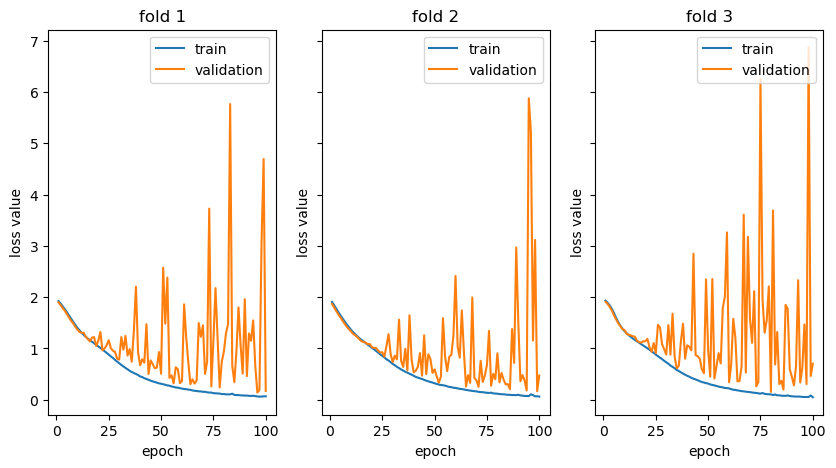

In [117]:
fig, ax = plt.subplots(1,3,figsize=(10,5),sharey=True)
t = np.arange(1, 101, 1)


ax[0].plot(t, loss_train_cnn_baseline[0],label="train")
ax[0].plot(t, loss_validation_cnn_baseline[0],label="validation")
ax[0].legend(loc="upper right")
ax[0].set(xlabel='epoch', ylabel='loss value',title='fold 1')

ax[1].plot(t, loss_train_cnn_baseline[1],label="train")
ax[1].plot(t, loss_validation_cnn_baseline[1],label="validation")
ax[1].legend(loc="upper right")
ax[1].set(xlabel='epoch', ylabel='loss value',title='fold 2')

ax[2].plot(t, loss_train_cnn_baseline[2],label="train")
ax[2].plot(t, loss_validation_cnn_baseline[2],label="validation")
ax[2].legend(loc="upper right")
ax[2].set(xlabel='epoch', ylabel='loss value',title='fold 3')


plt.show()

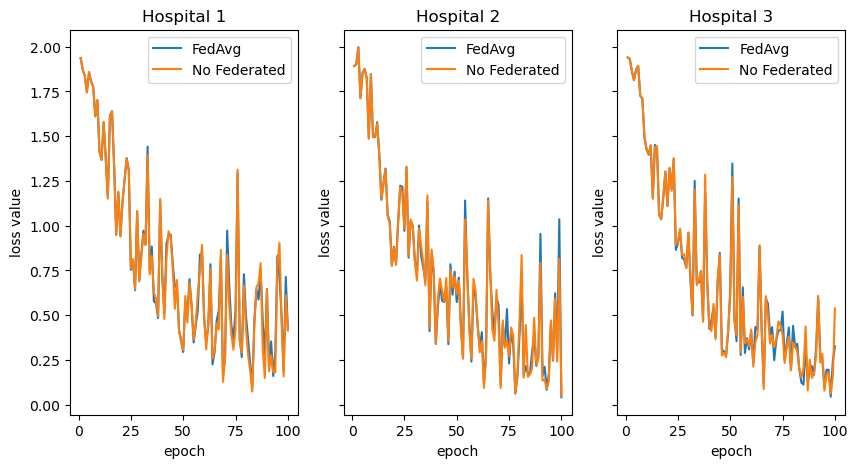

In [118]:
fig, ax = plt.subplots(1,3,figsize=(10,5),sharey=True)
t = np.arange(1, 101, 1)


ax[0].plot(t, loss_train_cnn_fedAVG[0],label="FedAvg")
ax[0].plot(t, loss_train_cnn_fedAVG[3],label="No Federated")
ax[0].legend(loc="upper right")
ax[0].set(xlabel='epoch', ylabel='loss value',title='Hospital 1')

ax[1].plot(t, loss_train_cnn_fedAVG[1],label="FedAvg")
ax[1].plot(t, loss_train_cnn_fedAVG[4],label="No Federated")
ax[1].legend(loc="upper right")
ax[1].set(xlabel='epoch', ylabel='loss value',title='Hospital 2')

ax[2].plot(t, loss_train_cnn_fedAVG[2],label="FedAvg")
ax[2].plot(t, loss_train_cnn_fedAVG[5],label="No Federated")
ax[2].legend(loc="upper right")
ax[2].set(xlabel='epoch', ylabel='loss value',title='Hospital 3')


plt.show()

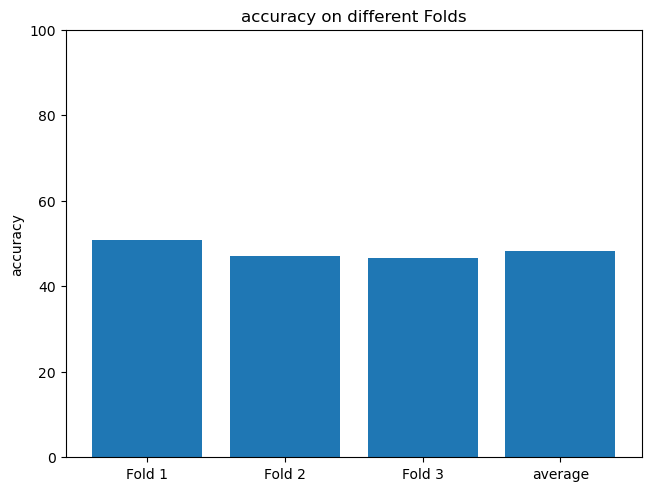

In [122]:
x = np.arange(4)

"""
avg = 0

for i in acc_baseline:
    avg += i
avg /= 3
acc_baseline.append(avg)
"""

fig, ax = plt.subplots(layout='constrained')

ax.bar(x,acc_baseline)

ax.set_ylabel('accuracy')
ax.set_title('accuracy on different Folds')
ax.set_xticks(x, ("Fold 1","Fold 2","Fold 3","average"))
ax.set_ylim(0, 100)

plt.show()

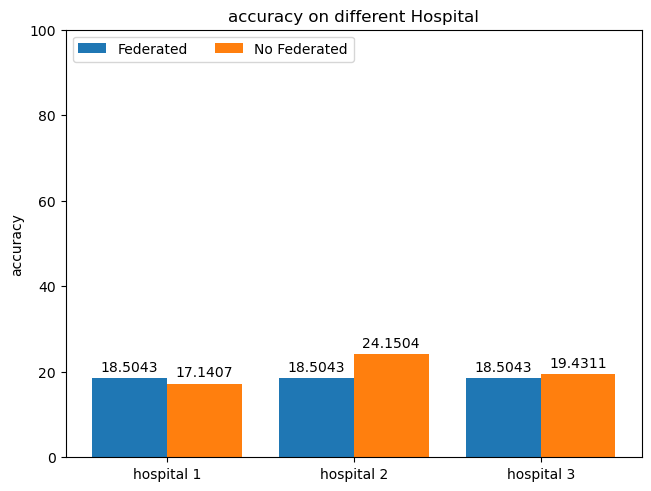

In [99]:
x = np.arange(3)  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

penguin_means = {
    'Federated': (acc_fedavg[0],acc_fedavg[1],acc_fedavg[2]),
    'No Federated': (acc_[0],acc_[1],acc_[2]),
}

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('accuracy')
ax.set_title('accuracy on different Hospital')
ax.set_xticks(x + width/2, ("hospital 1","hospital 2","hospital 3"))
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 100)

plt.show()

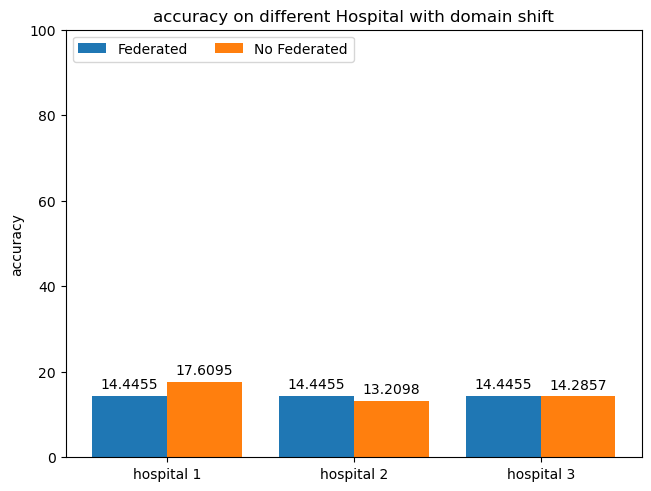

In [100]:
x = np.arange(3)  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

penguin_means = {
    'Federated': (acc_fedavg_shift[0],acc_fedavg_shift[1],acc_fedavg_shift[2]),
    'No Federated': (acc_shift[0],acc_shift[1],acc_shift[2]),
}

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('accuracy')
ax.set_title('accuracy on different Hospital with domain shift')
ax.set_xticks(x + width/2, ("hospital 1","hospital 2","hospital 3"))
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 100)

plt.show()

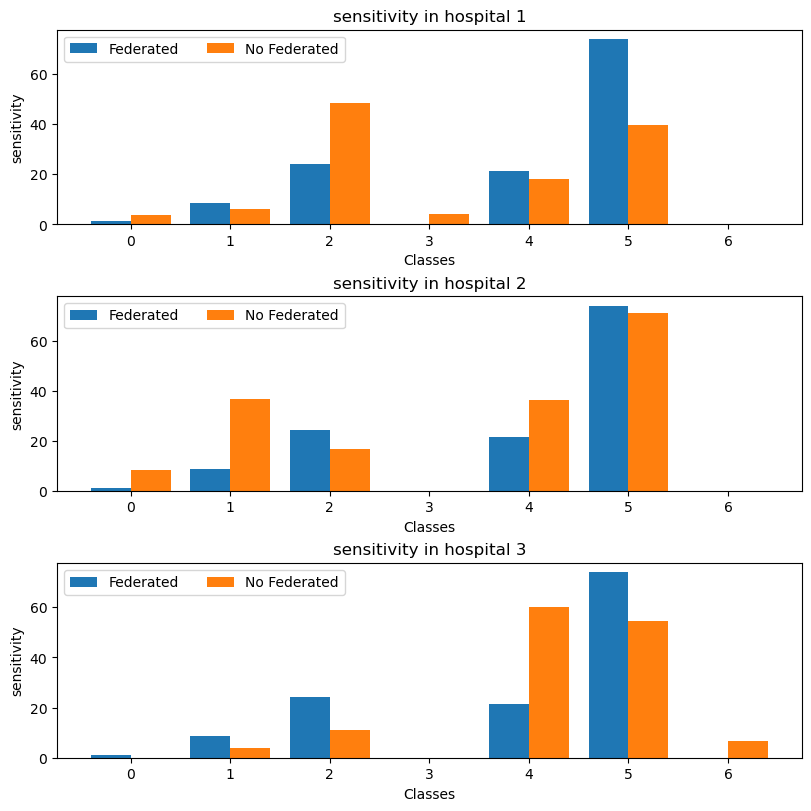

In [105]:
fig, ax = plt.subplots(3,1,figsize=(8,8),layout='constrained')



x = np.arange(7)  # the label locations
width = 0.4  # the width of the bars
multiplier = 0


penguin_means = {
    'Federated': (sens_fedavg[0],sens_fedavg[1],sens_fedavg[2]),
    'No Federated': (sens_[0],sens_[1],sens_[2]),
}

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    ax[0].bar(x+offset,measurement[0], width, label=attribute)
    ax[0].legend(loc='upper left', ncols=3)
    ax[0].set(xlabel='Classes', ylabel='sensitivity',title='sensitivity in hospital 1')
    ax[0].set_xticks(x + width/2,(0,1,2,3,4,5,6))

    ax[1].bar(x+offset,measurement[1], width, label=attribute)
    ax[1].set(xlabel='Classes', ylabel='sensitivity',title='sensitivity in hospital 2')
    ax[1].legend(loc='upper left', ncols=3)
    ax[1].set_xticks(x + width/2,(0,1,2,3,4,5,6))
    
    ax[2].bar(x+offset,measurement[2], width, label=attribute)
    ax[2].set(xlabel='Classes', ylabel='sensitivity',title='sensitivity in hospital 3')
    ax[2].legend(loc='upper left', ncols=3)
    ax[2].set_xticks(x + width/2,(0,1,2,3,4,5,6))


    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.


plt.show()

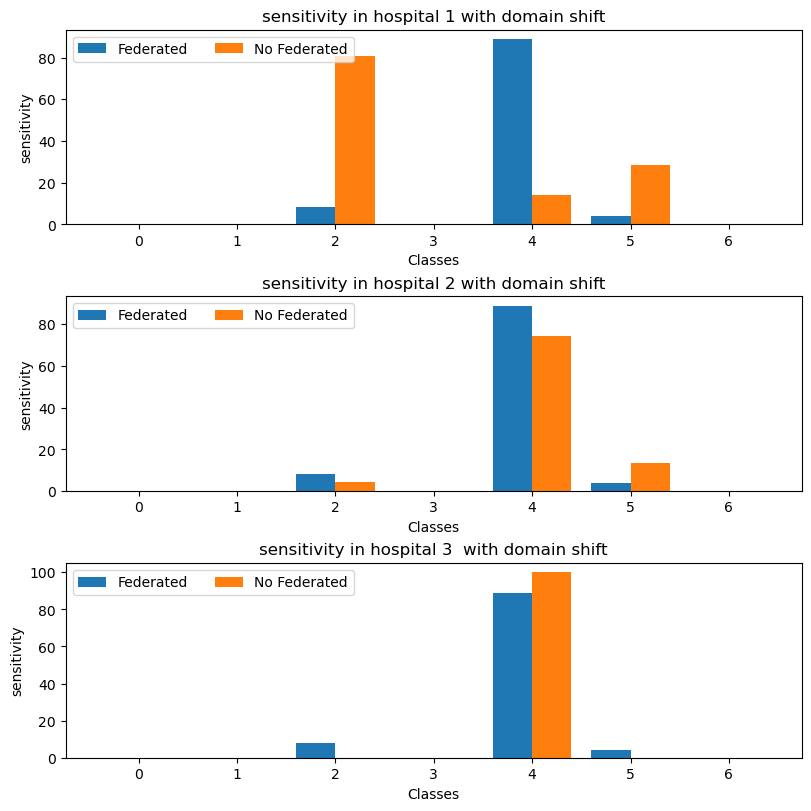

In [107]:
fig, ax = plt.subplots(3,1,figsize=(8,8),layout='constrained')



x = np.arange(7)  # the label locations
width = 0.4  # the width of the bars
multiplier = 0


penguin_means = {
    'Federated': (sens_fedavg_shift[0],sens_fedavg_shift[1],sens_fedavg_shift[2]),
    'No Federated': (sens_shift[0],sens_shift[1],sens_shift[2]),
}

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    ax[0].bar(x+offset,measurement[0], width, label=attribute)
    ax[0].legend(loc='upper left', ncols=3)
    ax[0].set(xlabel='Classes', ylabel='sensitivity',title='sensitivity in hospital 1 with domain shift')
    ax[0].set_xticks(x + width/2,(0,1,2,3,4,5,6))

    ax[1].bar(x+offset,measurement[1], width, label=attribute)
    ax[1].set(xlabel='Classes', ylabel='sensitivity',title='sensitivity in hospital 2 with domain shift')
    ax[1].legend(loc='upper left', ncols=3)
    ax[1].set_xticks(x + width/2,(0,1,2,3,4,5,6))
    
    ax[2].bar(x+offset,measurement[2], width, label=attribute)
    ax[2].set(xlabel='Classes', ylabel='sensitivity',title='sensitivity in hospital 3  with domain shift')
    ax[2].legend(loc='upper left', ncols=3)
    ax[2].set_xticks(x + width/2,(0,1,2,3,4,5,6))


    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.


plt.show()

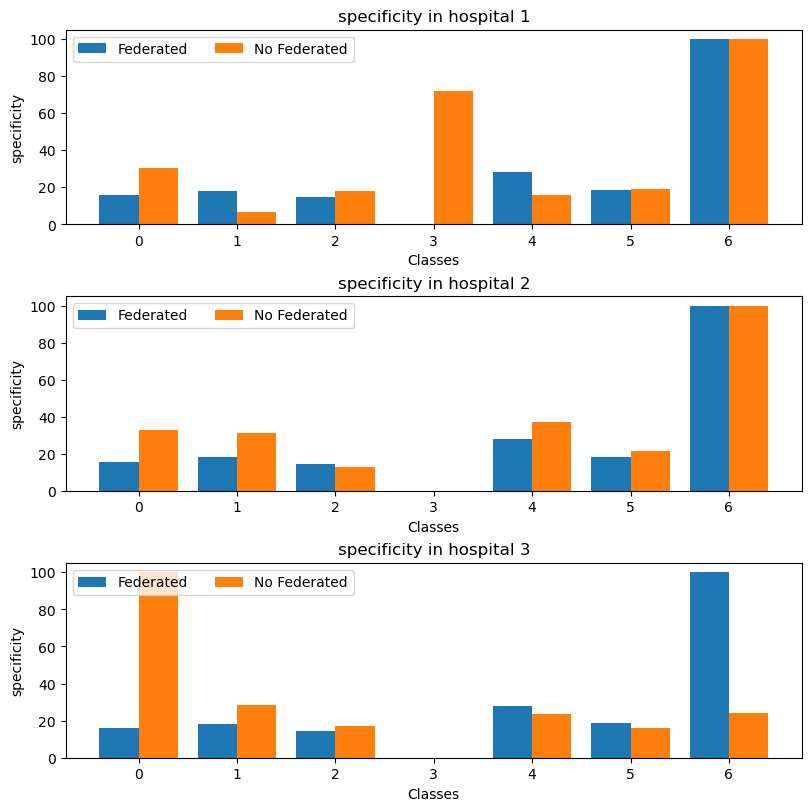

In [108]:
fig, ax = plt.subplots(3,figsize=(8,8),layout='constrained')



x = np.arange(7)  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

penguin_means = {
    'Federated': (spec_fedavg[0], spec_fedavg[1],spec_fedavg[2]),
    'No Federated': (spec_[0], spec_[1],spec_[2]),
}

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    ax[0].bar(x+offset,measurement[0], width, label=attribute)
    ax[0].legend(loc='upper left', ncols=3)
    ax[0].set(xlabel='Classes', ylabel='specificity',title='specificity in hospital 1')
    ax[0].set_xticks(x + width/2,(0,1,2,3,4,5,6))

    ax[1].bar(x+offset,measurement[1], width, label=attribute)
    ax[1].set(xlabel='Classes', ylabel='specificity',title='specificity in hospital 2')
    ax[1].legend(loc='upper left', ncols=3)
    ax[1].set_xticks(x + width/2,(0,1,2,3,4,5,6))

    ax[2].bar(x+offset,measurement[2], width, label=attribute)
    ax[2].set(xlabel='Classes', ylabel='specificity',title='specificity in hospital 3')
    ax[2].legend(loc='upper left', ncols=3)
    ax[2].set_xticks(x + width/2,(0,1,2,3,4,5,6))



    multiplier += 1


plt.show()

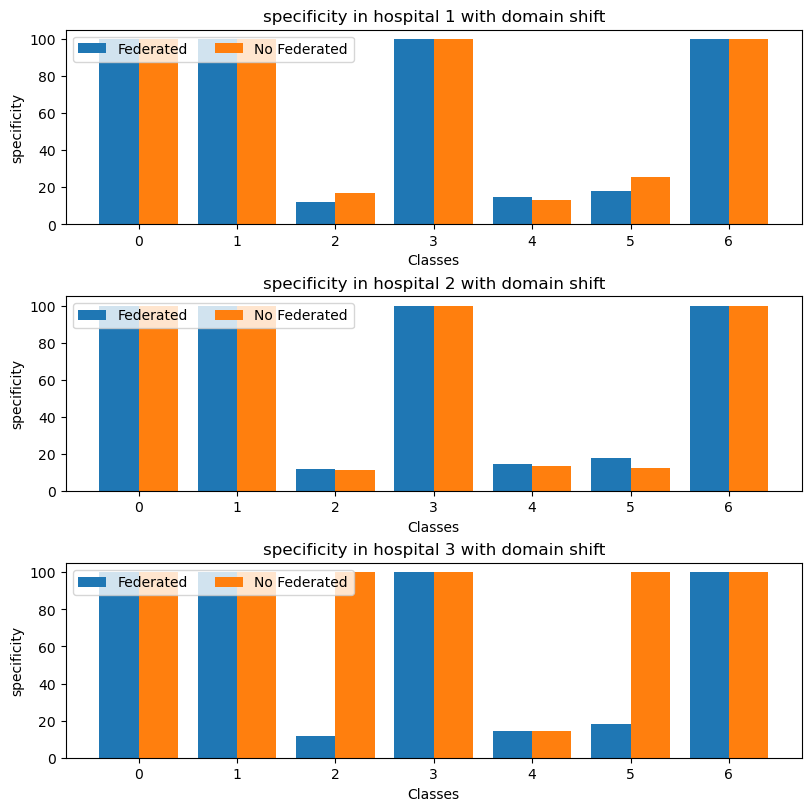

In [109]:
fig, ax = plt.subplots(3,figsize=(8,8),layout='constrained')



x = np.arange(7)  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

penguin_means = {
    'Federated': (spec_fedavg_shift[0], spec_fedavg_shift[1],spec_fedavg_shift[2]),
    'No Federated': (spec_shift[0], spec_shift[1],spec_shift[2]),
}

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    ax[0].bar(x+offset,measurement[0], width, label=attribute)
    ax[0].legend(loc='upper left', ncols=3)
    ax[0].set(xlabel='Classes', ylabel='specificity',title='specificity in hospital 1 with domain shift')
    ax[0].set_xticks(x + width/2,(0,1,2,3,4,5,6))

    ax[1].bar(x+offset,measurement[1], width, label=attribute)
    ax[1].set(xlabel='Classes', ylabel='specificity',title='specificity in hospital 2 with domain shift')
    ax[1].legend(loc='upper left', ncols=3)
    ax[1].set_xticks(x + width/2,(0,1,2,3,4,5,6))

    ax[2].bar(x+offset,measurement[2], width, label=attribute)
    ax[2].set(xlabel='Classes', ylabel='specificity',title='specificity in hospital 3 with domain shift')
    ax[2].legend(loc='upper left', ncols=3)
    ax[2].set_xticks(x + width/2,(0,1,2,3,4,5,6))



    multiplier += 1


plt.show()